In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.metrics import confusion_matrix

In [2]:

# Neural Network imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam

In [3]:
# Image augmentation importrs
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomContrast
from tensorflow.keras.layers import RandomZoom
from tensorflow.keras.layers import RandomFlip
from tensorflow.keras.layers import RandomTranslation

In [5]:
# Training Model callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

In [6]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}

    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)

    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)

    return data_path, data_index

def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=1, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels),
                                 num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
import os
import tensorflow as tf


train_paths = 'BT100/Training'
test_paths = 'BT100/Testing'


train_image_paths, train_index = get_data_labels(train_paths)

test_image_paths, test_index = get_data_labels(test_paths)


batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_image_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_image_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)


In [8]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

In [9]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 3429

Testing
Number of Labels: 1311


In [10]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label




# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label




# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

In [11]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)


Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


In [12]:
model = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model.summary()

# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 164, 164, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 50, 50, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

In [14]:
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history = model.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.4498 - loss: 1.1672 - val_accuracy: 0.6110 - val_loss: 1.1287 - learning_rate: 0.0010
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.7377 - loss: 0.6719 - val_accuracy: 0.7170 - val_loss: 0.7523 - learning_rate: 0.0010
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.8008 - loss: 0.5088 - val_accuracy: 0.7803 - val_loss: 0.6274 - learning_rate: 0.0010
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.8640 - loss: 0.3807 - val_accuracy: 0.8413 - val_loss: 0.4303 - learning_rate: 0.0010
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.8847 - loss: 0.3005 - val_accuracy: 0.8192 - val_loss: 0.5418 - learning_rate: 0.0010
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 101ms/step - accuracy: 0.8947 - loss: 0.2639 - val_accuracy: 0.8696 - val_loss: 0.4062 - learning_rate: 0.0010
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.91

In [15]:
test_loss, test_acc = model.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9709 - loss: 0.2509
Test accuracy: 96.5675%


In [16]:
from sklearn.metrics import classification_report

y_pred = model.predict(test_ds_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels as class indices instead of one-hot encoded vectors
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds_preprocessed], axis=0)
print(classification_report(true_labels, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       300
           1       0.93      0.94      0.94       306
           2       0.99      0.98      0.99       405
           3       0.96      0.99      0.97       300

    accuracy                           0.97      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.97      0.97      0.97      1311



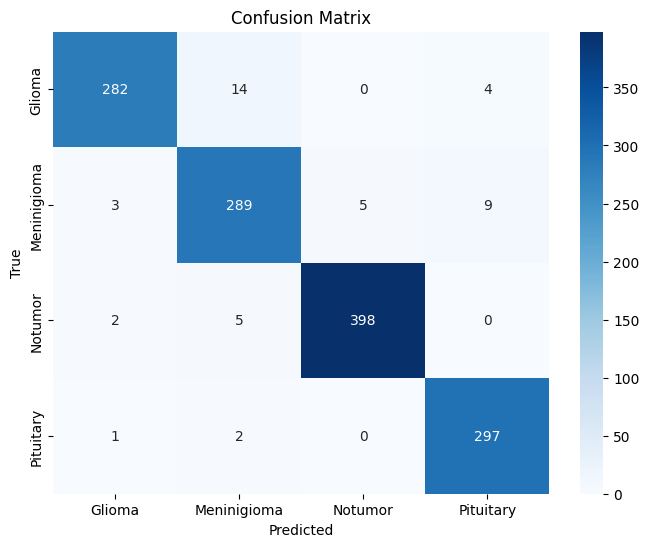

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [18]:
model.save('SSL_60-40.h5')

In [19]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
from datetime import datetime
import shutil

# Define paths
MODEL_PATH = "SSL_60-40.h5"  # Update with actual model path
UNLABELED_DATASET_PATH = "BT100/unlabelled"  # Update with actual dataset path
OUTPUT_FOLDER = "BT100/Training"
LOW_CONF_FOLDER = "BT100/low_confidence"  # Folder for low-confidence images
CONFIDENCE_THRESHOLD = 0.98
IMG_SIZE = (168, 168)  # Use the same image size as during training

# Define class names
CLASS_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]  # Update with actual class names

# Load trained model
model = tf.keras.models.load_model(MODEL_PATH)

# Ensure output folders exist
for class_name in CLASS_NAMES:
    os.makedirs(os.path.join(OUTPUT_FOLDER, class_name), exist_ok=True)
os.makedirs(LOW_CONF_FOLDER, exist_ok=True)  # Ensure low-confidence folder exists

# Get list of image files
image_files = [f for f in os.listdir(UNLABELED_DATASET_PATH) if f.endswith(('png', 'jpg', 'jpeg'))]

for img_file in tqdm(image_files):
    img_path = os.path.join(UNLABELED_DATASET_PATH, img_file)

    # Load and preprocess image
    img = load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')  # Load as grayscale
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Get predictions
    predictions = model.predict(img_array)
    class_id = np.argmax(predictions)
    confidence = np.max(predictions)

    # Debugging print statements
    print(f"{img_file} -> Class: {CLASS_NAMES[class_id]}, Confidence: {confidence:.2f}")

    # Save pseudo-labeled image if confidence is above threshold
    if confidence >= CONFIDENCE_THRESHOLD:
        class_folder = os.path.join(OUTPUT_FOLDER, CLASS_NAMES[class_id])

        # Ensure unique filenames to prevent overwriting
        unique_filename = f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_{img_file}"
        output_path = os.path.join(class_folder, unique_filename)

        print(f"Moving {img_file} to {output_path}")
        shutil.move(img_path, output_path)  # Move instead of copy
    else:
        low_conf_path = os.path.join(LOW_CONF_FOLDER, img_file)
        shutil.move(img_path, low_conf_path)
        print(f"Moved low-confidence image {img_file} to {LOW_CONF_FOLDER}")

print("✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.")


  0%|          | 0/2283 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step


  0%|          | 1/2283 [00:00<25:58,  1.46it/s]

Tr-pi_1149.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1149.jpg to BT100/Training/pituitary/20250330_185210_Tr-pi_1149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-me_1043.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1043.jpg to BT100/Training/meningioma/20250330_185210_Tr-me_1043.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 3/2283 [00:00<08:28,  4.49it/s]

Tr-gl_0780.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0780.jpg to BT100/Training/glioma/20250330_185210_Tr-gl_0780.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Tr-no_0442.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0442.jpg to BT100/Training/notumor/20250330_185210_Tr-no_0442.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 5/2283 [00:00<05:19,  7.14it/s]

Tr-pi_0917.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0917.jpg to BT100/Training/pituitary/20250330_185210_Tr-pi_0917.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-no_0110.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0110.jpg to BT100/Training/notumor/20250330_185210_Tr-no_0110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0297.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0297.jpg to BT100/Training/pituitary/20250330_185210_Tr-pi_0297.jpg


  0%|          | 7/2283 [00:01<04:08,  9.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0216.jpg -> Class: notumor, Confidence: 0.70
Moved low-confidence image Tr-me_0216.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  0%|          | 9/2283 [00:01<03:39, 10.34it/s]

Tr-pi_1058.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1058.jpg to BT100/Training/pituitary/20250330_185210_Tr-pi_1058.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_1069.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1069.jpg to BT100/Training/meningioma/20250330_185210_Tr-me_1069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  0%|          | 11/2283 [00:01<03:11, 11.88it/s]

Tr-gl_0839.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0839.jpg to BT100/Training/glioma/20250330_185211_Tr-gl_0839.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-pi_0570.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0570.jpg to BT100/Training/pituitary/20250330_185211_Tr-pi_0570.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  1%|          | 13/2283 [00:01<02:55, 12.95it/s]

Tr-gl_0325.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0325.jpg to BT100/Training/glioma/20250330_185211_Tr-gl_0325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-me_0990.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0990.jpg to BT100/Training/meningioma/20250330_185211_Tr-me_0990.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|          | 15/2283 [00:01<02:47, 13.56it/s]

Tr-pi_0874.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0874.jpg to BT100/Training/pituitary/20250330_185211_Tr-pi_0874.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-gl_0119.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0119.jpg to BT100/Training/glioma/20250330_185211_Tr-gl_0119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|          | 17/2283 [00:01<02:41, 14.03it/s]

Tr-gl_0374.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0374.jpg to BT100/Training/glioma/20250330_185211_Tr-gl_0374.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Tr-pi_1373.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1373.jpg to BT100/Training/pituitary/20250330_185211_Tr-pi_1373.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


  1%|          | 19/2283 [00:01<02:35, 14.54it/s]

Tr-gl_0688.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0688.jpg to BT100/Training/glioma/20250330_185211_Tr-gl_0688.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-pi_1389.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1389.jpg to BT100/Training/pituitary/20250330_185211_Tr-pi_1389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|          | 21/2283 [00:01<02:32, 14.79it/s]

Tr-no_0926.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0926.jpg to BT100/Training/notumor/20250330_185211_Tr-no_0926.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0350.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0350.jpg to BT100/Training/meningioma/20250330_185211_Tr-me_0350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|          | 23/2283 [00:02<02:31, 14.93it/s]

Tr-me_0753.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0753.jpg to BT100/Training/meningioma/20250330_185211_Tr-me_0753.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0604.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0604.jpg to BT100/Training/pituitary/20250330_185211_Tr-pi_0604.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|          | 25/2283 [00:02<02:49, 13.33it/s]

Tr-me_1154.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1154.jpg to BT100/Training/meningioma/20250330_185212_Tr-me_1154.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0185.jpg -> Class: notumor, Confidence: 0.75
Moved low-confidence image Tr-me_0185.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|          | 27/2283 [00:02<02:42, 13.85it/s]

Tr-me_0121.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0121.jpg to BT100/Training/meningioma/20250330_185212_Tr-me_0121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1004.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1004.jpg to BT100/Training/pituitary/20250330_185212_Tr-pi_1004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1143.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1143.jpg to BT100/Training/pituitary/20250330_185212_Tr-pi_1143.jpg


  1%|▏         | 29/2283 [00:02<02:39, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_0543.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0543.jpg to BT100/Training/notumor/20250330_185212_Tr-no_0543.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_1133.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1133.jpg to BT100/Training/meningioma/20250330_185212_Tr-gl_1133.jpg


  1%|▏         | 31/2283 [00:02<02:35, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0265.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0265.jpg to BT100/Training/glioma/20250330_185212_Tr-gl_0265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  1%|▏         | 33/2283 [00:02<02:32, 14.72it/s]

Tr-gl_0928.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0928.jpg to BT100/Training/glioma/20250330_185212_Tr-gl_0928.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_0781.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0781.jpg to BT100/Training/notumor/20250330_185212_Tr-no_0781.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 35/2283 [00:02<02:31, 14.80it/s]

Tr-pi_0881.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0881.jpg to BT100/Training/pituitary/20250330_185212_Tr-pi_0881.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0247.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0247.jpg to BT100/Training/pituitary/20250330_185212_Tr-pi_0247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 37/2283 [00:03<02:31, 14.81it/s]

Tr-no_0513.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0513.jpg to BT100/Training/notumor/20250330_185212_Tr-no_0513.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Tr-pi_1081.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1081.jpg to BT100/Training/pituitary/20250330_185212_Tr-pi_1081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  2%|▏         | 39/2283 [00:03<03:17, 11.36it/s]

Tr-me_0654.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0654.jpg to BT100/Training/meningioma/20250330_185213_Tr-me_0654.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-me_0701.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0701.jpg to BT100/Training/meningioma/20250330_185213_Tr-me_0701.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▏         | 41/2283 [00:03<03:37, 10.30it/s]

Tr-me_0635.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0635.jpg to BT100/Training/meningioma/20250330_185213_Tr-me_0635.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_1152.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1152.jpg to BT100/Training/pituitary/20250330_185213_Tr-pi_1152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  2%|▏         | 43/2283 [00:03<03:38, 10.24it/s]

Tr-me_0243.jpg -> Class: meningioma, Confidence: 0.73
Moved low-confidence image Tr-me_0243.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_0033.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0033.jpg to BT100/Training/meningioma/20250330_185213_Tr-me_0033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  2%|▏         | 45/2283 [00:04<03:49,  9.74it/s]

Tr-me_0838.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0838.jpg to BT100/Training/meningioma/20250330_185213_Tr-me_0838.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0306.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0306.jpg to BT100/Training/glioma/20250330_185213_Tr-gl_0306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 47/2283 [00:04<03:53,  9.56it/s]

Tr-no_0178.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0178.jpg to BT100/Training/notumor/20250330_185213_Tr-no_0178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▏         | 48/2283 [00:04<04:05,  9.10it/s]

Tr-gl_0418.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0418.jpg to BT100/Training/glioma/20250330_185214_Tr-gl_0418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▏         | 49/2283 [00:04<04:03,  9.18it/s]

Tr-gl_0398.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0398.jpg to BT100/Training/glioma/20250330_185214_Tr-gl_0398.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  2%|▏         | 50/2283 [00:04<04:15,  8.73it/s]

Tr-me_0233.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0233.jpg to BT100/Training/meningioma/20250330_185214_Tr-me_0233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  2%|▏         | 51/2283 [00:04<04:13,  8.80it/s]

Tr-no_0422.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0422.jpg to BT100/Training/notumor/20250330_185214_Tr-no_0422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  2%|▏         | 52/2283 [00:04<04:06,  9.04it/s]

Tr-me_0167.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0167.jpg to BT100/Training/meningioma/20250330_185214_Tr-me_0167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  2%|▏         | 53/2283 [00:04<04:22,  8.49it/s]

Tr-pi_0357.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0357.jpg to BT100/Training/pituitary/20250330_185214_Tr-pi_0357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0922.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0922.jpg to BT100/Training/pituitary/20250330_185214_Tr-pi_0922.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  2%|▏         | 55/2283 [00:05<04:00,  9.25it/s]

Tr-me_0218.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0218.jpg to BT100/Training/meningioma/20250330_185214_Tr-me_0218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0895.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0895.jpg to BT100/Training/notumor/20250330_185214_Tr-no_0895.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  2%|▏         | 57/2283 [00:05<03:30, 10.59it/s]

Tr-me_0372.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0372.jpg to BT100/Training/meningioma/20250330_185215_Tr-me_0372.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0015.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0015.jpg to BT100/Training/meningioma/20250330_185215_Tr-me_0015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  3%|▎         | 59/2283 [00:05<03:13, 11.51it/s]

Tr-no_0097.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0097.jpg to BT100/Training/notumor/20250330_185215_Tr-no_0097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1493.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1493.jpg to BT100/Training/notumor/20250330_185215_Tr-no_1493.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  3%|▎         | 61/2283 [00:05<02:57, 12.50it/s]

Tr-me_0254.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0254.jpg to BT100/Training/meningioma/20250330_185215_Tr-me_0254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_0719.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0719.jpg to BT100/Training/notumor/20250330_185215_Tr-no_0719.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  3%|▎         | 63/2283 [00:05<02:48, 13.20it/s]

Tr-gl_1164.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1164.jpg to BT100/Training/glioma/20250330_185215_Tr-gl_1164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0503.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0503.jpg to BT100/Training/meningioma/20250330_185215_Tr-me_0503.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_0011.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0011.jpg to BT100/Training/notumor/20250330_185215_Tr-no_0011.jpg


  3%|▎         | 65/2283 [00:05<02:41, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0360.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0360.jpg to BT100/Training/notumor/20250330_185215_Tr-me_0360.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  3%|▎         | 67/2283 [00:05<02:39, 13.89it/s]

Tr-pi_1280.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1280.jpg to BT100/Training/pituitary/20250330_185215_Tr-pi_1280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1263.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1263.jpg to BT100/Training/glioma/20250330_185215_Tr-gl_1263.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  3%|▎         | 69/2283 [00:06<02:51, 12.93it/s]

Tr-me_1279.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1279.jpg to BT100/Training/meningioma/20250330_185215_Tr-me_1279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_1065.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1065.jpg to BT100/Training/glioma/20250330_185215_Tr-gl_1065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  3%|▎         | 71/2283 [00:06<02:46, 13.28it/s]

Tr-me_0032.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0032.jpg to BT100/Training/meningioma/20250330_185216_Tr-me_0032.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1295.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1295.jpg to BT100/Training/notumor/20250330_185216_Tr-no_1295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  3%|▎         | 73/2283 [00:06<02:54, 12.63it/s]

Tr-gl_0359.jpg -> Class: glioma, Confidence: 0.90
Moved low-confidence image Tr-gl_0359.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-pi_0719.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0719.jpg to BT100/Training/pituitary/20250330_185216_Tr-pi_0719.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  3%|▎         | 75/2283 [00:06<02:46, 13.27it/s]

Tr-gl_0722.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0722.jpg to BT100/Training/glioma/20250330_185216_Tr-gl_0722.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_0460.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0460.jpg to BT100/Training/glioma/20250330_185216_Tr-gl_0460.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  3%|▎         | 77/2283 [00:06<02:38, 13.91it/s]

Tr-pi_0806.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0806.jpg to BT100/Training/pituitary/20250330_185216_Tr-pi_0806.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0632.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0632.jpg to BT100/Training/meningioma/20250330_185216_Tr-me_0632.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  3%|▎         | 79/2283 [00:06<02:34, 14.22it/s]

Tr-no_0690.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0690.jpg to BT100/Training/notumor/20250330_185216_Tr-no_0690.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1537.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1537.jpg to BT100/Training/notumor/20250330_185216_Tr-no_1537.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▎         | 81/2283 [00:07<02:34, 14.27it/s]

Tr-me_1281.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1281.jpg to BT100/Training/meningioma/20250330_185216_Tr-me_1281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0341.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0341.jpg to BT100/Training/meningioma/20250330_185216_Tr-me_0341.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0364.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0364.jpg to BT100/Training/notumor/20250330_185216_Tr-no_0364.jpg


  4%|▎         | 83/2283 [00:07<02:48, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_1290.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1290.jpg to BT100/Training/notumor/20250330_185216_Tr-no_1290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▎         | 85/2283 [00:07<02:42, 13.55it/s]

Tr-me_0492.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0492.jpg to BT100/Training/meningioma/20250330_185217_Tr-me_0492.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0841.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0841.jpg to BT100/Training/pituitary/20250330_185217_Tr-pi_0841.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  4%|▍         | 87/2283 [00:07<02:51, 12.80it/s]

Tr-no_0747.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0747.jpg to BT100/Training/notumor/20250330_185217_Tr-no_0747.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0747.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0747.jpg to BT100/Training/glioma/20250330_185217_Tr-gl_0747.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  4%|▍         | 89/2283 [00:07<02:44, 13.32it/s]

Tr-no_1146.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1146.jpg to BT100/Training/notumor/20250330_185217_Tr-no_1146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-me_0721.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0721.jpg to BT100/Training/meningioma/20250330_185217_Tr-me_0721.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0298.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0298.jpg to BT100/Training/glioma/20250330_185217_Tr-gl_0298.jpg


  4%|▍         | 91/2283 [00:07<02:37, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1455.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1455.jpg to BT100/Training/notumor/20250330_185217_Tr-no_1455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▍         | 93/2283 [00:07<02:36, 14.02it/s]

Tr-me_0174.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0174.jpg to BT100/Training/pituitary/20250330_185217_Tr-me_0174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1097.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1097.jpg to BT100/Training/pituitary/20250330_185217_Tr-pi_1097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▍         | 95/2283 [00:08<02:32, 14.32it/s]

Tr-gl_0733.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0733.jpg to BT100/Training/glioma/20250330_185217_Tr-gl_0733.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1213.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1213.jpg to BT100/Training/pituitary/20250330_185217_Tr-pi_1213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▍         | 97/2283 [00:08<02:47, 13.09it/s]

Tr-me_0609.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0609.jpg to BT100/Training/meningioma/20250330_185217_Tr-me_0609.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-no_1211.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1211.jpg to BT100/Training/notumor/20250330_185218_Tr-no_1211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▍         | 99/2283 [00:08<02:41, 13.54it/s]

Tr-me_0310.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0310.jpg to BT100/Training/meningioma/20250330_185218_Tr-me_0310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0952.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0952.jpg to BT100/Training/notumor/20250330_185218_Tr-no_0952.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  4%|▍         | 101/2283 [00:08<02:53, 12.57it/s]

Tr-me_0427.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0427.jpg to BT100/Training/meningioma/20250330_185218_Tr-me_0427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_0674.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0674.jpg to BT100/Training/glioma/20250330_185218_Tr-gl_0674.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  5%|▍         | 103/2283 [00:08<02:44, 13.27it/s]

Tr-gl_1003.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1003.jpg to BT100/Training/glioma/20250330_185218_Tr-gl_1003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0547.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0547.jpg to BT100/Training/pituitary/20250330_185218_Tr-pi_0547.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  5%|▍         | 105/2283 [00:08<02:55, 12.38it/s]

Tr-me_0905.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0905.jpg to BT100/Training/meningioma/20250330_185218_Tr-me_0905.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1255.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1255.jpg to BT100/Training/notumor/20250330_185218_Tr-no_1255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0820.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0820.jpg to BT100/Training/pituitary/20250330_185218_Tr-pi_0820.jpg


  5%|▍         | 107/2283 [00:09<03:02, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0181.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0181.jpg to BT100/Training/meningioma/20250330_185218_Tr-me_0181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  5%|▍         | 109/2283 [00:09<02:59, 12.14it/s]

Tr-pi_0359.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0359.jpg to BT100/Training/pituitary/20250330_185218_Tr-pi_0359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1370.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1370.jpg to BT100/Training/pituitary/20250330_185218_Tr-pi_1370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  5%|▍         | 111/2283 [00:09<02:48, 12.91it/s]

Tr-me_0309.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0309.jpg to BT100/Training/meningioma/20250330_185219_Tr-me_0309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0771.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0771.jpg to BT100/Training/notumor/20250330_185219_Tr-no_0771.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  5%|▍         | 113/2283 [00:09<02:44, 13.15it/s]

Tr-pi_0513.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0513.jpg to BT100/Training/pituitary/20250330_185219_Tr-pi_0513.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1438.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1438.jpg to BT100/Training/pituitary/20250330_185219_Tr-pi_1438.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  5%|▌         | 115/2283 [00:09<02:38, 13.70it/s]

Tr-no_1250.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1250.jpg to BT100/Training/notumor/20250330_185219_Tr-no_1250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0110.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0110.jpg to BT100/Training/glioma/20250330_185219_Tr-gl_0110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  5%|▌         | 117/2283 [00:09<02:38, 13.65it/s]

Tr-me_0211.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0211.jpg to BT100/Training/meningioma/20250330_185219_Tr-me_0211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_1113.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1113.jpg to BT100/Training/meningioma/20250330_185219_Tr-me_1113.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  5%|▌         | 119/2283 [00:09<02:34, 13.96it/s]

Tr-no_0906.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0906.jpg to BT100/Training/notumor/20250330_185219_Tr-no_0906.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0119.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0119.jpg to BT100/Training/notumor/20250330_185219_Tr-no_0119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  5%|▌         | 121/2283 [00:10<02:32, 14.15it/s]

Tr-no_1354.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1354.jpg to BT100/Training/notumor/20250330_185219_Tr-no_1354.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0674.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0674.jpg to BT100/Training/notumor/20250330_185219_Tr-no_0674.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


  5%|▌         | 123/2283 [00:10<02:48, 12.80it/s]

Tr-pi_1387.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1387.jpg to BT100/Training/pituitary/20250330_185219_Tr-pi_1387.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0223.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0223.jpg to BT100/Training/pituitary/20250330_185220_Tr-pi_0223.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  5%|▌         | 125/2283 [00:10<02:43, 13.22it/s]

Tr-no_0040.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-no_0040.jpg to BT100/Training/meningioma/20250330_185220_Tr-no_0040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0190.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0190.jpg to BT100/Training/meningioma/20250330_185220_Tr-me_0190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▌         | 127/2283 [00:10<02:42, 13.30it/s]

Tr-pi_0305.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0305.jpg to BT100/Training/pituitary/20250330_185220_Tr-pi_0305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0468.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0468.jpg to BT100/Training/notumor/20250330_185220_Tr-no_0468.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 129/2283 [00:10<02:38, 13.60it/s]

Tr-me_0894.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0894.jpg to BT100/Training/meningioma/20250330_185220_Tr-me_0894.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0928.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0928.jpg to BT100/Training/meningioma/20250330_185220_Tr-me_0928.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▌         | 131/2283 [00:10<02:32, 14.07it/s]

Tr-me_0993.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0993.jpg to BT100/Training/meningioma/20250330_185220_Tr-me_0993.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-gl_0680.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0680.jpg to BT100/Training/glioma/20250330_185220_Tr-gl_0680.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▌         | 133/2283 [00:10<02:29, 14.36it/s]

Tr-no_0605.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0605.jpg to BT100/Training/notumor/20250330_185220_Tr-no_0605.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1234.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1234.jpg to BT100/Training/pituitary/20250330_185220_Tr-pi_1234.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0882.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0882.jpg to BT100/Training/notumor/20250330_185220_Tr-no_0882.jpg


  6%|▌         | 135/2283 [00:11<02:28, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1502.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1502.jpg to BT100/Training/notumor/20250330_185220_Tr-no_1502.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  6%|▌         | 137/2283 [00:11<02:43, 13.14it/s]

Tr-pi_0317.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0317.jpg to BT100/Training/pituitary/20250330_185220_Tr-pi_0317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Tr-pi_0435.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0435.jpg to BT100/Training/pituitary/20250330_185221_Tr-pi_0435.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  6%|▌         | 139/2283 [00:11<02:37, 13.66it/s]

Tr-gl_0686.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0686.jpg to BT100/Training/glioma/20250330_185221_Tr-gl_0686.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1191.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1191.jpg to BT100/Training/notumor/20250330_185221_Tr-no_1191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▌         | 141/2283 [00:11<02:50, 12.54it/s]

Tr-gl_0330.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0330.jpg to BT100/Training/glioma/20250330_185221_Tr-gl_0330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0175.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0175.jpg to BT100/Training/pituitary/20250330_185221_Tr-pi_0175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▋         | 143/2283 [00:11<02:44, 12.98it/s]

Tr-gl_0993.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0993.jpg to BT100/Training/glioma/20250330_185221_Tr-gl_0993.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0188.jpg -> Class: glioma, Confidence: 0.60
Moved low-confidence image Tr-gl_0188.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_1287.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1287.jpg to BT100/Training/meningioma/20250330_185221_Tr-me_1287.jpg


  6%|▋         | 145/2283 [00:11<02:37, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1441.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1441.jpg to BT100/Training/notumor/20250330_185221_Tr-no_1441.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▋         | 147/2283 [00:11<02:33, 13.92it/s]

Tr-gl_0365.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0365.jpg to BT100/Training/glioma/20250330_185221_Tr-gl_0365.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_1242.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-gl_1242.jpg to BT100/Training/meningioma/20250330_185221_Tr-gl_1242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 149/2283 [00:12<02:42, 13.10it/s]

Tr-me_0368.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0368.jpg to BT100/Training/meningioma/20250330_185221_Tr-me_0368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0218.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0218.jpg to BT100/Training/notumor/20250330_185221_Tr-no_0218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


  7%|▋         | 151/2283 [00:12<02:42, 13.14it/s]

Tr-me_1066.jpg -> Class: glioma, Confidence: 0.98
Moved low-confidence image Tr-me_1066.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0865.jpg -> Class: notumor, Confidence: 0.82
Moved low-confidence image Tr-pi_0865.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 153/2283 [00:12<02:37, 13.52it/s]

Tr-gl_0815.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0815.jpg to BT100/Training/glioma/20250330_185222_Tr-gl_0815.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Tr-pi_0013.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0013.jpg to BT100/Training/pituitary/20250330_185222_Tr-pi_0013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  7%|▋         | 155/2283 [00:12<02:47, 12.67it/s]

Tr-gl_0883.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0883.jpg to BT100/Training/glioma/20250330_185222_Tr-gl_0883.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0600.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0600.jpg to BT100/Training/notumor/20250330_185222_Tr-no_0600.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  7%|▋         | 157/2283 [00:12<02:40, 13.25it/s]

Tr-me_0152.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0152.jpg to BT100/Training/meningioma/20250330_185222_Tr-me_0152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1054.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1054.jpg to BT100/Training/glioma/20250330_185222_Tr-gl_1054.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  7%|▋         | 159/2283 [00:12<02:33, 13.81it/s]

Tr-pi_1437.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1437.jpg to BT100/Training/pituitary/20250330_185222_Tr-pi_1437.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0102.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0102.jpg to BT100/Training/meningioma/20250330_185222_Tr-me_0102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 161/2283 [00:13<02:31, 14.00it/s]

Tr-me_0395.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0395.jpg to BT100/Training/meningioma/20250330_185222_Tr-me_0395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0327.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0327.jpg to BT100/Training/notumor/20250330_185222_Tr-no_0327.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  7%|▋         | 163/2283 [00:13<02:44, 12.89it/s]

Tr-me_0836.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0836.jpg to BT100/Training/meningioma/20250330_185222_Tr-me_0836.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1249.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1249.jpg to BT100/Training/notumor/20250330_185222_Tr-no_1249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 165/2283 [00:13<02:52, 12.30it/s]

Tr-gl_0216.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0216.jpg to BT100/Training/glioma/20250330_185223_Tr-gl_0216.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_1337.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1337.jpg to BT100/Training/notumor/20250330_185223_Tr-no_1337.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  7%|▋         | 167/2283 [00:13<02:42, 13.01it/s]

Tr-no_1440.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1440.jpg to BT100/Training/notumor/20250330_185223_Tr-no_1440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_1166.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1166.jpg to BT100/Training/pituitary/20250330_185223_Tr-pi_1166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  7%|▋         | 169/2283 [00:13<02:40, 13.17it/s]

Tr-no_0237.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0237.jpg to BT100/Training/notumor/20250330_185223_Tr-no_0237.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0220.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0220.jpg to BT100/Training/pituitary/20250330_185223_Tr-pi_0220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  7%|▋         | 171/2283 [00:13<02:36, 13.52it/s]

Tr-me_0749.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0749.jpg to BT100/Training/meningioma/20250330_185223_Tr-me_0749.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0529.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0529.jpg to BT100/Training/notumor/20250330_185223_Tr-no_0529.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 173/2283 [00:13<02:45, 12.76it/s]

Tr-gl_1189.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1189.jpg to BT100/Training/glioma/20250330_185223_Tr-gl_1189.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1252.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1252.jpg to BT100/Training/notumor/20250330_185223_Tr-no_1252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  8%|▊         | 175/2283 [00:14<02:54, 12.08it/s]

Tr-no_0922.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0922.jpg to BT100/Training/notumor/20250330_185223_Tr-no_0922.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0202.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0202.jpg to BT100/Training/glioma/20250330_185223_Tr-gl_0202.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 177/2283 [00:14<02:48, 12.48it/s]

Tr-gl_1002.jpg -> Class: meningioma, Confidence: 0.87
Moved low-confidence image Tr-gl_1002.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0047.jpg -> Class: meningioma, Confidence: 0.65
Moved low-confidence image Tr-gl_0047.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|▊         | 179/2283 [00:14<02:43, 12.84it/s]

Tr-me_1332.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1332.jpg to BT100/Training/meningioma/20250330_185224_Tr-me_1332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0481.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0481.jpg to BT100/Training/pituitary/20250330_185224_Tr-pi_0481.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  8%|▊         | 181/2283 [00:14<02:52, 12.18it/s]

Tr-gl_0312.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0312.jpg to BT100/Training/glioma/20250330_185224_Tr-gl_0312.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1305.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1305.jpg to BT100/Training/pituitary/20250330_185224_Tr-pi_1305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 183/2283 [00:14<02:43, 12.84it/s]

Tr-gl_0947.jpg -> Class: glioma, Confidence: 0.83
Moved low-confidence image Tr-gl_0947.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0600.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0600.jpg to BT100/Training/meningioma/20250330_185224_Tr-me_0600.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  8%|▊         | 185/2283 [00:14<02:53, 12.12it/s]

Tr-glTr_0005.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-glTr_0005.jpg to BT100/Training/glioma/20250330_185224_Tr-glTr_0005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_1091.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1091.jpg to BT100/Training/meningioma/20250330_185224_Tr-me_1091.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|▊         | 187/2283 [00:15<03:19, 10.53it/s]

Tr-gl_0161.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0161.jpg to BT100/Training/glioma/20250330_185224_Tr-gl_0161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-gl_1278.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1278.jpg to BT100/Training/glioma/20250330_185225_Tr-gl_1278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  8%|▊         | 189/2283 [00:15<03:37,  9.61it/s]

Tr-pi_0064.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0064.jpg to BT100/Training/pituitary/20250330_185225_Tr-pi_0064.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-me_0226.jpg -> Class: glioma, Confidence: 0.94
Moved low-confidence image Tr-me_0226.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  8%|▊         | 191/2283 [00:15<04:02,  8.62it/s]

Tr-me_0726.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0726.jpg to BT100/Training/meningioma/20250330_185225_Tr-me_0726.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  8%|▊         | 192/2283 [00:15<04:08,  8.43it/s]

Tr-pi_0151.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0151.jpg to BT100/Training/pituitary/20250330_185225_Tr-pi_0151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0934.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0934.jpg to BT100/Training/pituitary/20250330_185225_Tr-pi_0934.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  8%|▊         | 194/2283 [00:16<03:50,  9.07it/s]

Tr-gl_1274.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-gl_1274.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


  9%|▊         | 195/2283 [00:16<04:08,  8.39it/s]

Tr-gl_0954.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0954.jpg to BT100/Training/glioma/20250330_185225_Tr-gl_0954.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  9%|▊         | 196/2283 [00:16<04:17,  8.09it/s]

Tr-pi_0598.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0598.jpg to BT100/Training/pituitary/20250330_185226_Tr-pi_0598.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_0341.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0341.jpg to BT100/Training/pituitary/20250330_185226_Tr-pi_0341.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  9%|▊         | 198/2283 [00:16<04:08,  8.38it/s]

Tr-gl_1018.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1018.jpg to BT100/Training/glioma/20250330_185226_Tr-gl_1018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  9%|▊         | 199/2283 [00:16<04:15,  8.17it/s]

Tr-me_1156.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1156.jpg to BT100/Training/meningioma/20250330_185226_Tr-me_1156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-me_0677.jpg -> Class: meningioma, Confidence: 1.00

  9%|▉         | 200/2283 [00:16<04:25,  7.85it/s]


Moving Tr-me_0677.jpg to BT100/Training/meningioma/20250330_185226_Tr-me_0677.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0661.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0661.jpg to BT100/Training/notumor/20250330_185226_Tr-no_0661.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  9%|▉         | 202/2283 [00:17<03:47,  9.13it/s]

Tr-pi_0012.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0012.jpg to BT100/Training/pituitary/20250330_185226_Tr-pi_0012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  9%|▉         | 203/2283 [00:17<03:48,  9.09it/s]

Tr-no_0801.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0801.jpg to BT100/Training/notumor/20250330_185226_Tr-no_0801.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0214.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0214.jpg to BT100/Training/pituitary/20250330_185226_Tr-pi_0214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  9%|▉         | 205/2283 [00:17<03:17, 10.52it/s]

Tr-me_0039.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0039.jpg to BT100/Training/meningioma/20250330_185226_Tr-me_0039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0633.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0633.jpg to BT100/Training/pituitary/20250330_185227_Tr-pi_0633.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  9%|▉         | 207/2283 [00:17<03:13, 10.75it/s]

Tr-gl_1299.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1299.jpg to BT100/Training/glioma/20250330_185227_Tr-gl_1299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0488.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0488.jpg to BT100/Training/glioma/20250330_185227_Tr-gl_0488.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


  9%|▉         | 209/2283 [00:17<02:55, 11.79it/s]

Tr-pi_0366.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0366.jpg to BT100/Training/pituitary/20250330_185227_Tr-pi_0366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0195.jpg -> Class: meningioma, Confidence: 0.93
Moved low-confidence image Tr-me_0195.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  9%|▉         | 211/2283 [00:17<02:47, 12.34it/s]

Tr-no_1092.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1092.jpg to BT100/Training/notumor/20250330_185227_Tr-no_1092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0495.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0495.jpg to BT100/Training/pituitary/20250330_185227_Tr-pi_0495.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  9%|▉         | 213/2283 [00:17<02:40, 12.87it/s]

Tr-no_1077.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1077.jpg to BT100/Training/notumor/20250330_185227_Tr-no_1077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0313.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0313.jpg to BT100/Training/glioma/20250330_185227_Tr-gl_0313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  9%|▉         | 215/2283 [00:18<02:37, 13.15it/s]

Tr-no_1226.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1226.jpg to BT100/Training/notumor/20250330_185227_Tr-no_1226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0072.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0072.jpg to BT100/Training/meningioma/20250330_185227_Tr-me_0072.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 10%|▉         | 217/2283 [00:18<03:01, 11.38it/s]

Tr-me_0947.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0947.jpg to BT100/Training/meningioma/20250330_185227_Tr-me_0947.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_0941.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0941.jpg to BT100/Training/pituitary/20250330_185228_Tr-pi_0941.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|▉         | 219/2283 [00:18<02:49, 12.17it/s]

Tr-pi_1428.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1428.jpg to BT100/Training/pituitary/20250330_185228_Tr-pi_1428.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_1086.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1086.jpg to BT100/Training/meningioma/20250330_185228_Tr-me_1086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 10%|▉         | 221/2283 [00:18<02:41, 12.76it/s]

Tr-me_0028.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0028.jpg to BT100/Training/meningioma/20250330_185228_Tr-me_0028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0887.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0887.jpg to BT100/Training/notumor/20250330_185228_Tr-no_0887.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 10%|▉         | 223/2283 [00:18<02:35, 13.25it/s]

Tr-me_0340.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_0340.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_1304.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1304.jpg to BT100/Training/notumor/20250330_185228_Tr-no_1304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 10%|▉         | 225/2283 [00:18<02:36, 13.15it/s]

Tr-gl_0726.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0726.jpg to BT100/Training/glioma/20250330_185228_Tr-gl_0726.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0598.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0598.jpg to BT100/Training/glioma/20250330_185228_Tr-gl_0598.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 10%|▉         | 227/2283 [00:18<02:32, 13.46it/s]

Tr-gl_1216.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1216.jpg to BT100/Training/glioma/20250330_185228_Tr-gl_1216.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0745.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0745.jpg to BT100/Training/meningioma/20250330_185228_Tr-me_0745.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|█         | 229/2283 [00:19<02:40, 12.77it/s]

Tr-me_1038.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1038.jpg to BT100/Training/meningioma/20250330_185228_Tr-me_1038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1205.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1205.jpg to BT100/Training/glioma/20250330_185228_Tr-gl_1205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|█         | 231/2283 [00:19<02:49, 12.13it/s]

Tr-no_0828.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0828.jpg to BT100/Training/notumor/20250330_185229_Tr-no_0828.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0084.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0084.jpg to BT100/Training/notumor/20250330_185229_Tr-no_0084.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 10%|█         | 233/2283 [00:19<02:40, 12.79it/s]

Tr-pi_0526.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0526.jpg to BT100/Training/pituitary/20250330_185229_Tr-pi_0526.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0583.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0583.jpg to BT100/Training/glioma/20250330_185229_Tr-gl_0583.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 10%|█         | 235/2283 [00:19<02:32, 13.44it/s]

Tr-no_1232.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1232.jpg to BT100/Training/notumor/20250330_185229_Tr-no_1232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0239.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0239.jpg to BT100/Training/notumor/20250330_185229_Tr-me_0239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 10%|█         | 237/2283 [00:19<02:28, 13.77it/s]

Tr-gl_0685.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0685.jpg to BT100/Training/glioma/20250330_185229_Tr-gl_0685.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0816.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0816.jpg to BT100/Training/notumor/20250330_185229_Tr-no_0816.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 10%|█         | 239/2283 [00:19<02:27, 13.83it/s]

Tr-no_0809.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0809.jpg to BT100/Training/notumor/20250330_185229_Tr-no_0809.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0313.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0313.jpg to BT100/Training/pituitary/20250330_185229_Tr-me_0313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█         | 241/2283 [00:20<02:23, 14.22it/s]

Tr-gl_0496.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0496.jpg to BT100/Training/glioma/20250330_185229_Tr-gl_0496.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1290.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1290.jpg to BT100/Training/pituitary/20250330_185229_Tr-pi_1290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 11%|█         | 243/2283 [00:20<02:38, 12.85it/s]

Tr-no_0519.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0519.jpg to BT100/Training/notumor/20250330_185229_Tr-no_0519.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0180.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0180.jpg to BT100/Training/meningioma/20250330_185229_Tr-me_0180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 11%|█         | 245/2283 [00:20<02:33, 13.24it/s]

Tr-pi_0499.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0499.jpg to BT100/Training/pituitary/20250330_185230_Tr-pi_0499.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_0366.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0366.jpg to BT100/Training/notumor/20250330_185230_Tr-no_0366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 11%|█         | 247/2283 [00:20<02:41, 12.60it/s]

Tr-pi_1093.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1093.jpg to BT100/Training/pituitary/20250330_185230_Tr-pi_1093.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0667.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0667.jpg to BT100/Training/meningioma/20250330_185230_Tr-me_0667.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█         | 249/2283 [00:20<02:37, 12.90it/s]

Tr-no_0075.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0075.jpg to BT100/Training/notumor/20250330_185230_Tr-no_0075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0551.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0551.jpg to BT100/Training/pituitary/20250330_185230_Tr-pi_0551.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 11%|█         | 251/2283 [00:20<02:35, 13.10it/s]

Tr-pi_0388.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0388.jpg to BT100/Training/pituitary/20250330_185230_Tr-pi_0388.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1078.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1078.jpg to BT100/Training/meningioma/20250330_185230_Tr-me_1078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 11%|█         | 253/2283 [00:20<02:30, 13.45it/s]

Tr-gl_0277.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0277.jpg to BT100/Training/glioma/20250330_185230_Tr-gl_0277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0791.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0791.jpg to BT100/Training/pituitary/20250330_185230_Tr-pi_0791.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 11%|█         | 255/2283 [00:21<02:26, 13.83it/s]

Tr-no_0967.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0967.jpg to BT100/Training/notumor/20250330_185230_Tr-no_0967.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_1066.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1066.jpg to BT100/Training/pituitary/20250330_185230_Tr-pi_1066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█▏        | 257/2283 [00:21<02:31, 13.40it/s]

Tr-me_0916.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0916.jpg to BT100/Training/meningioma/20250330_185230_Tr-me_0916.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-me_0405.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0405.jpg to BT100/Training/meningioma/20250330_185231_Tr-me_0405.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 11%|█▏        | 259/2283 [00:21<02:27, 13.72it/s]

Tr-gl_0175.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0175.jpg to BT100/Training/glioma/20250330_185231_Tr-gl_0175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0235.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0235.jpg to BT100/Training/notumor/20250330_185231_Tr-no_0235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 11%|█▏        | 261/2283 [00:21<02:39, 12.71it/s]

Tr-pi_0581.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0581.jpg to BT100/Training/pituitary/20250330_185231_Tr-pi_0581.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0075.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0075.jpg to BT100/Training/pituitary/20250330_185231_Tr-pi_0075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 12%|█▏        | 263/2283 [00:21<02:33, 13.15it/s]

Tr-pi_0465.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0465.jpg to BT100/Training/pituitary/20250330_185231_Tr-pi_0465.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1138.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1138.jpg to BT100/Training/pituitary/20250330_185231_Tr-pi_1138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 265/2283 [00:21<02:54, 11.58it/s]

Tr-me_0634.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0634.jpg to BT100/Training/meningioma/20250330_185231_Tr-me_0634.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0437.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0437.jpg to BT100/Training/notumor/20250330_185231_Tr-no_0437.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 12%|█▏        | 267/2283 [00:22<02:44, 12.27it/s]

Tr-pi_0480.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0480.jpg to BT100/Training/pituitary/20250330_185231_Tr-pi_0480.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0252.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0252.jpg to BT100/Training/pituitary/20250330_185231_Tr-pi_0252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 269/2283 [00:22<02:51, 11.77it/s]

Tr-pi_0878.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0878.jpg to BT100/Training/pituitary/20250330_185231_Tr-pi_0878.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-no_1131.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1131.jpg to BT100/Training/notumor/20250330_185232_Tr-no_1131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 12%|█▏        | 271/2283 [00:22<02:40, 12.50it/s]

Tr-gl_0481.jpg -> Class: glioma, Confidence: 0.93
Moved low-confidence image Tr-gl_0481.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0371.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0371.jpg to BT100/Training/meningioma/20250330_185232_Tr-me_0371.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 12%|█▏        | 273/2283 [00:22<02:36, 12.84it/s]

Tr-pi_1054.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1054.jpg to BT100/Training/pituitary/20250330_185232_Tr-pi_1054.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0422.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0422.jpg to BT100/Training/pituitary/20250330_185232_Tr-pi_0422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 12%|█▏        | 275/2283 [00:22<02:30, 13.32it/s]

Tr-no_1546.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1546.jpg to BT100/Training/notumor/20250330_185232_Tr-no_1546.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-meTr_0002.jpg -> Class: meningioma, Confidence: 0.84
Moved low-confidence image Tr-meTr_0002.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 277/2283 [00:22<02:26, 13.72it/s]

Tr-pi_0992.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0992.jpg to BT100/Training/pituitary/20250330_185232_Tr-pi_0992.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0497.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0497.jpg to BT100/Training/notumor/20250330_185232_Tr-no_0497.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 279/2283 [00:22<02:25, 13.75it/s]

Tr-no_1478.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1478.jpg to BT100/Training/notumor/20250330_185232_Tr-no_1478.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1419.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1419.jpg to BT100/Training/notumor/20250330_185232_Tr-no_1419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 12%|█▏        | 281/2283 [00:23<02:23, 13.94it/s]

Tr-gl_0576.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0576.jpg to BT100/Training/glioma/20250330_185232_Tr-gl_0576.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0600.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0600.jpg to BT100/Training/glioma/20250330_185232_Tr-gl_0600.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 283/2283 [00:23<02:28, 13.50it/s]

Tr-me_0389.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0389.jpg to BT100/Training/meningioma/20250330_185232_Tr-me_0389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1221.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1221.jpg to BT100/Training/pituitary/20250330_185233_Tr-pi_1221.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 285/2283 [00:23<02:27, 13.55it/s]

Tr-no_0748.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0748.jpg to BT100/Training/notumor/20250330_185233_Tr-no_0748.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0392.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0392.jpg to BT100/Training/glioma/20250330_185233_Tr-gl_0392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|█▎        | 287/2283 [00:23<02:49, 11.77it/s]

Tr-pi_0812.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0812.jpg to BT100/Training/pituitary/20250330_185233_Tr-pi_0812.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0258.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0258.jpg to BT100/Training/pituitary/20250330_185233_Tr-pi_0258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█▎        | 289/2283 [00:23<02:39, 12.47it/s]

Tr-gl_0196.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0196.jpg to BT100/Training/glioma/20250330_185233_Tr-gl_0196.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-pi_1073.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_1073.jpg to BT100/Training/pituitary/20250330_185233_Tr-pi_1073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 13%|█▎        | 291/2283 [00:23<02:37, 12.68it/s]

Tr-gl_0862.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0862.jpg to BT100/Training/glioma/20250330_185233_Tr-gl_0862.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0825.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0825.jpg to BT100/Training/glioma/20250330_185233_Tr-gl_0825.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 13%|█▎        | 293/2283 [00:24<02:43, 12.18it/s]

Tr-me_1198.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1198.jpg to BT100/Training/meningioma/20250330_185233_Tr-me_1198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1483.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1483.jpg to BT100/Training/notumor/20250330_185233_Tr-no_1483.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|█▎        | 295/2283 [00:24<02:41, 12.32it/s]

Tr-no_0849.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0849.jpg to BT100/Training/notumor/20250330_185233_Tr-no_0849.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0069.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0069.jpg to BT100/Training/glioma/20250330_185234_Tr-gl_0069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 13%|█▎        | 297/2283 [00:24<02:36, 12.66it/s]

Tr-gl_0208.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0208.jpg to BT100/Training/glioma/20250330_185234_Tr-gl_0208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_1074.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_1074.jpg to BT100/Training/pituitary/20250330_185234_Tr-pi_1074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█▎        | 299/2283 [00:24<02:44, 12.08it/s]

Tr-no_1568.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1568.jpg to BT100/Training/notumor/20250330_185234_Tr-no_1568.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0715.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0715.jpg to BT100/Training/glioma/20250330_185234_Tr-gl_0715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 13%|█▎        | 301/2283 [00:24<02:35, 12.75it/s]

Tr-no_1475.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1475.jpg to BT100/Training/notumor/20250330_185234_Tr-no_1475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1203.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1203.jpg to BT100/Training/glioma/20250330_185234_Tr-gl_1203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 13%|█▎        | 303/2283 [00:24<02:52, 11.45it/s]

Tr-no_0208.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0208.jpg to BT100/Training/notumor/20250330_185234_Tr-no_0208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0265.jpg -> Class: notumor, Confidence: 0.92
Moved low-confidence image Tr-no_0265.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 13%|█▎        | 305/2283 [00:25<02:53, 11.40it/s]

Tr-me_1333.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1333.jpg to BT100/Training/meningioma/20250330_185234_Tr-me_1333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0389.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0389.jpg to BT100/Training/notumor/20250330_185234_Tr-no_0389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 13%|█▎        | 307/2283 [00:25<02:59, 10.99it/s]

Tr-no_1136.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1136.jpg to BT100/Training/notumor/20250330_185235_Tr-no_1136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0298.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0298.jpg to BT100/Training/meningioma/20250330_185235_Tr-me_0298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 14%|█▎        | 309/2283 [00:25<02:49, 11.63it/s]

Tr-no_1274.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1274.jpg to BT100/Training/notumor/20250330_185235_Tr-no_1274.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0623.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0623.jpg to BT100/Training/glioma/20250330_185235_Tr-gl_0623.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|█▎        | 311/2283 [00:25<02:56, 11.18it/s]

Tr-pi_1189.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1189.jpg to BT100/Training/pituitary/20250330_185235_Tr-pi_1189.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1071.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1071.jpg to BT100/Training/glioma/20250330_185235_Tr-gl_1071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 14%|█▎        | 313/2283 [00:25<02:44, 11.98it/s]

Tr-pi_0795.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0795.jpg to BT100/Training/pituitary/20250330_185235_Tr-pi_0795.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_0304.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0304.jpg to BT100/Training/pituitary/20250330_185235_Tr-pi_0304.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 14%|█▍        | 315/2283 [00:25<02:49, 11.62it/s]

Tr-no_0802.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0802.jpg to BT100/Training/notumor/20250330_185235_Tr-no_0802.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0194.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0194.jpg to BT100/Training/notumor/20250330_185235_Tr-no_0194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 14%|█▍        | 317/2283 [00:26<02:44, 11.96it/s]

Tr-me_0231.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0231.jpg to BT100/Training/meningioma/20250330_185235_Tr-me_0231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0633.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0633.jpg to BT100/Training/notumor/20250330_185235_Tr-no_0633.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 14%|█▍        | 319/2283 [00:26<02:41, 12.13it/s]

Tr-pi_1453.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1453.jpg to BT100/Training/pituitary/20250330_185236_Tr-pi_1453.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0764.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0764.jpg to BT100/Training/pituitary/20250330_185236_Tr-pi_0764.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 14%|█▍        | 321/2283 [00:26<02:53, 11.33it/s]

Tr-pi_0999.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0999.jpg to BT100/Training/pituitary/20250330_185236_Tr-pi_0999.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0634.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0634.jpg to BT100/Training/pituitary/20250330_185236_Tr-pi_0634.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 14%|█▍        | 323/2283 [00:26<02:44, 11.90it/s]

Tr-me_0871.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0871.jpg to BT100/Training/meningioma/20250330_185236_Tr-me_0871.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1165.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1165.jpg to BT100/Training/pituitary/20250330_185236_Tr-pi_1165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 14%|█▍        | 325/2283 [00:26<02:37, 12.47it/s]

Tr-no_1494.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1494.jpg to BT100/Training/notumor/20250330_185236_Tr-no_1494.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0673.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0673.jpg to BT100/Training/pituitary/20250330_185236_Tr-pi_0673.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 14%|█▍        | 327/2283 [00:26<02:33, 12.77it/s]

Tr-pi_0815.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0815.jpg to BT100/Training/pituitary/20250330_185236_Tr-pi_0815.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-meTr_0008.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0008.jpg to BT100/Training/meningioma/20250330_185236_Tr-meTr_0008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 14%|█▍        | 329/2283 [00:27<03:12, 10.16it/s]

Tr-gl_0524.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-gl_0524.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0354.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0354.jpg to BT100/Training/glioma/20250330_185237_Tr-gl_0354.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█▍        | 331/2283 [00:27<03:23,  9.58it/s]

Tr-gl_0861.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0861.jpg to BT100/Training/glioma/20250330_185237_Tr-gl_0861.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-pi_0393.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0393.jpg to BT100/Training/pituitary/20250330_185237_Tr-pi_0393.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 15%|█▍        | 333/2283 [00:27<03:34,  9.10it/s]

Tr-me_0565.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0565.jpg to BT100/Training/meningioma/20250330_185237_Tr-me_0565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 15%|█▍        | 334/2283 [00:27<03:34,  9.08it/s]

Tr-no_0787.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0787.jpg to BT100/Training/notumor/20250330_185237_Tr-no_0787.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 15%|█▍        | 335/2283 [00:27<03:40,  8.82it/s]

Tr-me_0771.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0771.jpg to BT100/Training/meningioma/20250330_185237_Tr-me_0771.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 15%|█▍        | 336/2283 [00:28<03:55,  8.28it/s]

Tr-me_0325.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0325.jpg to BT100/Training/meningioma/20250330_185237_Tr-me_0325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 15%|█▍        | 337/2283 [00:28<04:09,  7.80it/s]

Tr-no_0448.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0448.jpg to BT100/Training/notumor/20250330_185237_Tr-no_0448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 15%|█▍        | 338/2283 [00:28<04:14,  7.63it/s]

Tr-gl_1128.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1128.jpg to BT100/Training/glioma/20250330_185238_Tr-gl_1128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 15%|█▍        | 339/2283 [00:28<04:02,  8.02it/s]

Tr-me_0633.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0633.jpg to BT100/Training/meningioma/20250330_185238_Tr-me_0633.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 15%|█▍        | 340/2283 [00:28<04:13,  7.66it/s]

Tr-gl_0051.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0051.jpg to BT100/Training/glioma/20250330_185238_Tr-gl_0051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█▍        | 341/2283 [00:28<04:22,  7.39it/s]

Tr-gl_0420.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0420.jpg to BT100/Training/glioma/20250330_185238_Tr-gl_0420.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█▍        | 342/2283 [00:28<04:25,  7.32it/s]

Tr-gl_0230.jpg -> Class: glioma, Confidence: 0.81
Moved low-confidence image Tr-gl_0230.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0714.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0714.jpg to BT100/Training/glioma/20250330_185238_Tr-gl_0714.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 15%|█▌        | 344/2283 [00:29<03:50,  8.40it/s]

Tr-me_0730.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0730.jpg to BT100/Training/meningioma/20250330_185238_Tr-me_0730.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 15%|█▌        | 345/2283 [00:29<03:53,  8.28it/s]

Tr-pi_0735.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0735.jpg to BT100/Training/pituitary/20250330_185238_Tr-pi_0735.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 15%|█▌        | 346/2283 [00:29<03:53,  8.30it/s]

Tr-gl_1303.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1303.jpg to BT100/Training/glioma/20250330_185239_Tr-gl_1303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 15%|█▌        | 347/2283 [00:29<03:47,  8.50it/s]

Tr-no_0565.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0565.jpg to BT100/Training/notumor/20250330_185239_Tr-no_0565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0500.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0500.jpg to BT100/Training/meningioma/20250330_185239_Tr-me_0500.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 15%|█▌        | 349/2283 [00:29<03:10, 10.17it/s]

Tr-no_0557.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0557.jpg to BT100/Training/notumor/20250330_185239_Tr-no_0557.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_1209.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1209.jpg to BT100/Training/glioma/20250330_185239_Tr-gl_1209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 15%|█▌        | 351/2283 [00:29<02:49, 11.42it/s]

Tr-gl_1011.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1011.jpg to BT100/Training/glioma/20250330_185239_Tr-gl_1011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0793.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0793.jpg to BT100/Training/notumor/20250330_185239_Tr-no_0793.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 15%|█▌        | 353/2283 [00:29<02:35, 12.38it/s]

Tr-me_0626.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0626.jpg to BT100/Training/meningioma/20250330_185239_Tr-me_0626.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0831.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0831.jpg to BT100/Training/pituitary/20250330_185239_Tr-me_0831.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 16%|█▌        | 355/2283 [00:30<02:44, 11.70it/s]

Tr-gl_0655.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0655.jpg to BT100/Training/glioma/20250330_185239_Tr-gl_0655.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_0896.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0896.jpg to BT100/Training/meningioma/20250330_185239_Tr-me_0896.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▌        | 357/2283 [00:30<03:07, 10.27it/s]

Tr-no_1124.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1124.jpg to BT100/Training/notumor/20250330_185240_Tr-no_1124.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1293.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1293.jpg to BT100/Training/notumor/20250330_185240_Tr-no_1293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 16%|█▌        | 359/2283 [00:30<03:04, 10.43it/s]

Tr-no_0763.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0763.jpg to BT100/Training/notumor/20250330_185240_Tr-no_0763.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0475.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0475.jpg to BT100/Training/notumor/20250330_185240_Tr-no_0475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▌        | 361/2283 [00:30<02:51, 11.23it/s]

Tr-gl_1076.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1076.jpg to BT100/Training/glioma/20250330_185240_Tr-gl_1076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0448.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0448.jpg to BT100/Training/glioma/20250330_185240_Tr-gl_0448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▌        | 363/2283 [00:30<02:52, 11.12it/s]

Tr-gl_0585.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0585.jpg to BT100/Training/glioma/20250330_185240_Tr-gl_0585.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0616.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0616.jpg to BT100/Training/pituitary/20250330_185240_Tr-pi_0616.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 16%|█▌        | 365/2283 [00:31<02:52, 11.09it/s]

Tr-pi_1021.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1021.jpg to BT100/Training/pituitary/20250330_185240_Tr-pi_1021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0035.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-pi_0035.jpg to BT100/Training/meningioma/20250330_185240_Tr-pi_0035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 16%|█▌        | 367/2283 [00:31<02:55, 10.94it/s]

Tr-pi_1398.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1398.jpg to BT100/Training/pituitary/20250330_185240_Tr-pi_1398.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0539.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0539.jpg to BT100/Training/meningioma/20250330_185241_Tr-me_0539.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 16%|█▌        | 369/2283 [00:31<03:08, 10.15it/s]

Tr-pi_0327.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0327.jpg to BT100/Training/pituitary/20250330_185241_Tr-pi_0327.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1369.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1369.jpg to BT100/Training/notumor/20250330_185241_Tr-no_1369.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 16%|█▋        | 371/2283 [00:31<03:09, 10.08it/s]

Tr-no_0270.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0270.jpg to BT100/Training/notumor/20250330_185241_Tr-no_0270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0368.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0368.jpg to BT100/Training/pituitary/20250330_185241_Tr-pi_0368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 16%|█▋        | 373/2283 [00:31<02:54, 10.97it/s]

Tr-gl_1102.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1102.jpg to BT100/Training/glioma/20250330_185241_Tr-gl_1102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-piTr_0009.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0009.jpg to BT100/Training/pituitary/20250330_185241_Tr-piTr_0009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 16%|█▋        | 375/2283 [00:31<02:42, 11.73it/s]

Tr-no_1438.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1438.jpg to BT100/Training/notumor/20250330_185241_Tr-no_1438.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0177.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0177.jpg to BT100/Training/glioma/20250330_185241_Tr-gl_0177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 377/2283 [00:32<02:46, 11.45it/s]

Tr-no_1335.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1335.jpg to BT100/Training/notumor/20250330_185241_Tr-no_1335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0558.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0558.jpg to BT100/Training/pituitary/20250330_185241_Tr-pi_0558.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 379/2283 [00:32<02:40, 11.85it/s]

Tr-no_1245.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1245.jpg to BT100/Training/notumor/20250330_185241_Tr-no_1245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_1083.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1083.jpg to BT100/Training/pituitary/20250330_185242_Tr-pi_1083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 17%|█▋        | 381/2283 [00:32<02:36, 12.17it/s]

Tr-no_0685.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0685.jpg to BT100/Training/notumor/20250330_185242_Tr-no_0685.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0367.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0367.jpg to BT100/Training/meningioma/20250330_185242_Tr-me_0367.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 17%|█▋        | 383/2283 [00:32<02:31, 12.55it/s]

Tr-pi_0417.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0417.jpg to BT100/Training/pituitary/20250330_185242_Tr-pi_0417.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0363.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0363.jpg to BT100/Training/glioma/20250330_185242_Tr-gl_0363.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 17%|█▋        | 385/2283 [00:32<02:27, 12.89it/s]

Tr-no_1188.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1188.jpg to BT100/Training/notumor/20250330_185242_Tr-no_1188.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0018.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0018.jpg to BT100/Training/meningioma/20250330_185242_Tr-me_0018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 17%|█▋        | 387/2283 [00:32<02:22, 13.33it/s]

Tr-pi_0372.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0372.jpg to BT100/Training/pituitary/20250330_185242_Tr-pi_0372.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0597.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0597.jpg to BT100/Training/pituitary/20250330_185242_Tr-pi_0597.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0587.jpg -> Class: notumor, Confidence: 1.00

 17%|█▋        | 389/2283 [00:33<02:31, 12.49it/s]


Moving Tr-no_0587.jpg to BT100/Training/notumor/20250330_185242_Tr-no_0587.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1128.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1128.jpg to BT100/Training/meningioma/20250330_185242_Tr-me_1128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 391/2283 [00:33<02:44, 11.47it/s]

Tr-gl_0855.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0855.jpg to BT100/Training/glioma/20250330_185242_Tr-gl_0855.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0709.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0709.jpg to BT100/Training/notumor/20250330_185243_Tr-no_0709.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 17%|█▋        | 393/2283 [00:33<03:02, 10.35it/s]

Tr-me_0995.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0995.jpg to BT100/Training/meningioma/20250330_185243_Tr-me_0995.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1201.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1201.jpg to BT100/Training/pituitary/20250330_185243_Tr-pi_1201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 17%|█▋        | 395/2283 [00:33<02:49, 11.11it/s]

Tr-gl_0356.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0356.jpg to BT100/Training/glioma/20250330_185243_Tr-gl_0356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0295.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0295.jpg to BT100/Training/pituitary/20250330_185243_Tr-pi_0295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 17%|█▋        | 397/2283 [00:33<02:50, 11.05it/s]

Tr-pi_1134.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1134.jpg to BT100/Training/pituitary/20250330_185243_Tr-pi_1134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1045.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1045.jpg to BT100/Training/glioma/20250330_185243_Tr-gl_1045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 17%|█▋        | 399/2283 [00:34<02:51, 10.99it/s]

Tr-no_0022.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0022.jpg to BT100/Training/notumor/20250330_185243_Tr-no_0022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0625.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0625.jpg to BT100/Training/glioma/20250330_185243_Tr-gl_0625.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|█▊        | 401/2283 [00:34<02:58, 10.57it/s]

Tr-me_0078.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0078.jpg to BT100/Training/meningioma/20250330_185243_Tr-me_0078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1243.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1243.jpg to BT100/Training/pituitary/20250330_185243_Tr-pi_1243.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 403/2283 [00:34<02:54, 10.77it/s]

Tr-no_1407.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1407.jpg to BT100/Training/notumor/20250330_185244_Tr-no_1407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0482.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0482.jpg to BT100/Training/pituitary/20250330_185244_Tr-pi_0482.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 405/2283 [00:34<02:56, 10.63it/s]

Tr-no_1371.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1371.jpg to BT100/Training/notumor/20250330_185244_Tr-no_1371.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0316.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0316.jpg to BT100/Training/notumor/20250330_185244_Tr-no_0316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 18%|█▊        | 407/2283 [00:34<02:57, 10.57it/s]

Tr-me_0521.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0521.jpg to BT100/Training/meningioma/20250330_185244_Tr-me_0521.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0445.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0445.jpg to BT100/Training/glioma/20250330_185244_Tr-gl_0445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 18%|█▊        | 409/2283 [00:34<02:55, 10.69it/s]

Tr-me_0191.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0191.jpg to BT100/Training/meningioma/20250330_185244_Tr-me_0191.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0519.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0519.jpg to BT100/Training/pituitary/20250330_185244_Tr-pi_0519.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 18%|█▊        | 411/2283 [00:35<02:57, 10.54it/s]

Tr-me_0123.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0123.jpg to BT100/Training/meningioma/20250330_185244_Tr-me_0123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_1252.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1252.jpg to BT100/Training/meningioma/20250330_185244_Tr-me_1252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 18%|█▊        | 413/2283 [00:35<02:55, 10.64it/s]

Tr-no_0333.jpg -> Class: meningioma, Confidence: 0.88
Moved low-confidence image Tr-no_0333.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0710.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0710.jpg to BT100/Training/meningioma/20250330_185245_Tr-me_0710.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 18%|█▊        | 415/2283 [00:35<02:43, 11.40it/s]

Tr-no_0715.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0715.jpg to BT100/Training/notumor/20250330_185245_Tr-no_0715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1219.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1219.jpg to BT100/Training/notumor/20250330_185245_Tr-no_1219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 417/2283 [00:35<02:47, 11.15it/s]

Tr-no_1349.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1349.jpg to BT100/Training/notumor/20250330_185245_Tr-no_1349.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1418.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1418.jpg to BT100/Training/notumor/20250330_185245_Tr-no_1418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 18%|█▊        | 419/2283 [00:35<02:49, 10.99it/s]

Tr-me_1121.jpg -> Class: meningioma, Confidence: 0.93
Moved low-confidence image Tr-me_1121.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0453.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0453.jpg to BT100/Training/pituitary/20250330_185245_Tr-pi_0453.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 421/2283 [00:36<02:49, 10.98it/s]

Tr-me_0271.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_0271.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0874.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0874.jpg to BT100/Training/notumor/20250330_185245_Tr-no_0874.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 19%|█▊        | 423/2283 [00:36<02:49, 10.96it/s]

Tr-gl_0160.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0160.jpg to BT100/Training/glioma/20250330_185245_Tr-gl_0160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0394.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0394.jpg to BT100/Training/meningioma/20250330_185246_Tr-me_0394.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 19%|█▊        | 425/2283 [00:36<02:53, 10.74it/s]

Tr-pi_0648.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0648.jpg to BT100/Training/pituitary/20250330_185246_Tr-pi_0648.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0721.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0721.jpg to BT100/Training/pituitary/20250330_185246_Tr-pi_0721.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 19%|█▊        | 427/2283 [00:36<02:40, 11.55it/s]

Tr-pi_1194.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1194.jpg to BT100/Training/pituitary/20250330_185246_Tr-pi_1194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0493.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0493.jpg to BT100/Training/pituitary/20250330_185246_Tr-pi_0493.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 19%|█▉        | 429/2283 [00:36<02:37, 11.76it/s]

Tr-no_1422.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1422.jpg to BT100/Training/notumor/20250330_185246_Tr-no_1422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0408.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0408.jpg to BT100/Training/meningioma/20250330_185246_Tr-me_0408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 19%|█▉        | 431/2283 [00:36<02:31, 12.25it/s]

Tr-me_0922.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0922.jpg to BT100/Training/meningioma/20250330_185246_Tr-me_0922.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0181.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0181.jpg to BT100/Training/notumor/20250330_185246_Tr-no_0181.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 19%|█▉        | 433/2283 [00:37<02:29, 12.34it/s]

Tr-gl_0237.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0237.jpg to BT100/Training/glioma/20250330_185246_Tr-gl_0237.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0071.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0071.jpg to BT100/Training/notumor/20250330_185246_Tr-no_0071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 19%|█▉        | 435/2283 [00:37<02:51, 10.80it/s]

Tr-no_0423.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0423.jpg to BT100/Training/notumor/20250330_185246_Tr-no_0423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0925.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0925.jpg to BT100/Training/pituitary/20250330_185247_Tr-pi_0925.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 19%|█▉        | 437/2283 [00:37<02:42, 11.35it/s]

Tr-me_1096.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1096.jpg to BT100/Training/meningioma/20250330_185247_Tr-me_1096.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_1589.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1589.jpg to BT100/Training/notumor/20250330_185247_Tr-no_1589.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 19%|█▉        | 439/2283 [00:37<02:34, 11.97it/s]

Tr-no_1235.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1235.jpg to BT100/Training/notumor/20250330_185247_Tr-no_1235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1448.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1448.jpg to BT100/Training/notumor/20250330_185247_Tr-no_1448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 19%|█▉        | 441/2283 [00:37<02:41, 11.38it/s]

Tr-me_0880.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0880.jpg to BT100/Training/meningioma/20250330_185247_Tr-me_0880.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1297.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1297.jpg to BT100/Training/notumor/20250330_185247_Tr-no_1297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 19%|█▉        | 443/2283 [00:38<02:58, 10.29it/s]

Tr-gl_1207.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1207.jpg to BT100/Training/glioma/20250330_185247_Tr-gl_1207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1155.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1155.jpg to BT100/Training/glioma/20250330_185247_Tr-gl_1155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 19%|█▉        | 445/2283 [00:38<03:01, 10.10it/s]

Tr-noTr_0003.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0003.jpg to BT100/Training/notumor/20250330_185247_Tr-noTr_0003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1189.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1189.jpg to BT100/Training/notumor/20250330_185248_Tr-no_1189.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 20%|█▉        | 447/2283 [00:38<02:58, 10.29it/s]

Tr-no_0818.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0818.jpg to BT100/Training/notumor/20250330_185248_Tr-no_0818.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1103.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1103.jpg to BT100/Training/pituitary/20250330_185248_Tr-pi_1103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 20%|█▉        | 449/2283 [00:38<02:46, 10.99it/s]

Tr-pi_0277.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0277.jpg to BT100/Training/pituitary/20250330_185248_Tr-pi_0277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_0939.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0939.jpg to BT100/Training/meningioma/20250330_185248_Tr-me_0939.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|█▉        | 451/2283 [00:38<02:36, 11.73it/s]

Tr-me_0764.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0764.jpg to BT100/Training/meningioma/20250330_185248_Tr-me_0764.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0645.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0645.jpg to BT100/Training/glioma/20250330_185248_Tr-gl_0645.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|█▉        | 453/2283 [00:38<02:53, 10.57it/s]

Tr-pi_1228.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1228.jpg to BT100/Training/pituitary/20250330_185248_Tr-pi_1228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Tr-me_0566.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0566.jpg to BT100/Training/meningioma/20250330_185248_Tr-me_0566.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 20%|█▉        | 455/2283 [00:39<03:21,  9.07it/s]

Tr-pi_1268.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1268.jpg to BT100/Training/pituitary/20250330_185248_Tr-pi_1268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|█▉        | 456/2283 [00:39<03:18,  9.19it/s]

Tr-no_1506.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1506.jpg to BT100/Training/notumor/20250330_185249_Tr-no_1506.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|██        | 457/2283 [00:39<03:20,  9.11it/s]

Tr-no_1278.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1278.jpg to BT100/Training/notumor/20250330_185249_Tr-no_1278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 20%|██        | 458/2283 [00:39<03:34,  8.51it/s]

Tr-pi_0019.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0019.jpg to BT100/Training/pituitary/20250330_185249_Tr-pi_0019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_1194.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1194.jpg to BT100/Training/meningioma/20250330_185249_Tr-me_1194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 20%|██        | 460/2283 [00:39<03:32,  8.58it/s]

Tr-pi_0272.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0272.jpg to BT100/Training/pituitary/20250330_185249_Tr-pi_0272.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|██        | 461/2283 [00:39<03:40,  8.28it/s]

Tr-no_1462.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1462.jpg to BT100/Training/notumor/20250330_185249_Tr-no_1462.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-pi_0722.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0722.jpg to BT100/Training/pituitary/20250330_185249_Tr-pi_0722.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 20%|██        | 463/2283 [00:40<03:29,  8.68it/s]

Tr-no_0374.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0374.jpg to BT100/Training/notumor/20250330_185249_Tr-no_0374.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 20%|██        | 464/2283 [00:40<03:36,  8.40it/s]

Tr-me_0255.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0255.jpg to BT100/Training/meningioma/20250330_185250_Tr-me_0255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Tr-pi_0112.jpg -> Class: pituitary, Confidence: 1.00

 20%|██        | 465/2283 [00:40<03:47,  8.00it/s]


Moving Tr-pi_0112.jpg to BT100/Training/pituitary/20250330_185250_Tr-pi_0112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 20%|██        | 466/2283 [00:40<03:57,  7.64it/s]

Tr-gl_1262.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1262.jpg to BT100/Training/glioma/20250330_185250_Tr-gl_1262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 20%|██        | 467/2283 [00:40<04:02,  7.49it/s]

Tr-no_0924.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0924.jpg to BT100/Training/notumor/20250330_185250_Tr-no_0924.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|██        | 468/2283 [00:40<04:03,  7.45it/s]

Tr-no_1113.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1113.jpg to BT100/Training/notumor/20250330_185250_Tr-no_1113.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1166.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1166.jpg to BT100/Training/notumor/20250330_185250_Tr-no_1166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 21%|██        | 470/2283 [00:41<03:36,  8.37it/s]

Tr-no_1213.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1213.jpg to BT100/Training/notumor/20250330_185250_Tr-no_1213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 21%|██        | 471/2283 [00:41<03:33,  8.47it/s]

Tr-no_1246.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1246.jpg to BT100/Training/notumor/20250330_185250_Tr-no_1246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██        | 472/2283 [00:41<03:32,  8.51it/s]

Tr-me_0483.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0483.jpg to BT100/Training/meningioma/20250330_185251_Tr-me_0483.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██        | 473/2283 [00:41<03:29,  8.64it/s]

Tr-gl_0209.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0209.jpg to BT100/Training/glioma/20250330_185251_Tr-gl_0209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1005.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1005.jpg to BT100/Training/notumor/20250330_185251_Tr-no_1005.jpg


 21%|██        | 474/2283 [00:41<03:44,  8.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1233.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1233.jpg to BT100/Training/notumor/20250330_185251_Tr-no_1233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 21%|██        | 476/2283 [00:41<03:04,  9.77it/s]

Tr-me_0603.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0603.jpg to BT100/Training/meningioma/20250330_185251_Tr-me_0603.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 21%|██        | 477/2283 [00:41<03:10,  9.47it/s]

Tr-no_0017.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0017.jpg to BT100/Training/notumor/20250330_185251_Tr-no_0017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0803.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0803.jpg to BT100/Training/meningioma/20250330_185251_Tr-me_0803.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 21%|██        | 479/2283 [00:41<02:50, 10.60it/s]

Tr-no_0123.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0123.jpg to BT100/Training/notumor/20250330_185251_Tr-no_0123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0483.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0483.jpg to BT100/Training/pituitary/20250330_185251_Tr-pi_0483.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 21%|██        | 481/2283 [00:42<03:06,  9.67it/s]

Tr-me_0948.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0948.jpg to BT100/Training/meningioma/20250330_185251_Tr-me_0948.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0303.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0303.jpg to BT100/Training/pituitary/20250330_185252_Tr-pi_0303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 21%|██        | 483/2283 [00:42<03:01,  9.93it/s]

Tr-gl_1062.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1062.jpg to BT100/Training/glioma/20250330_185252_Tr-gl_1062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_1208.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1208.jpg to BT100/Training/meningioma/20250330_185252_Tr-gl_1208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 21%|██        | 485/2283 [00:42<02:55, 10.27it/s]

Tr-pi_0681.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0681.jpg to BT100/Training/pituitary/20250330_185252_Tr-pi_0681.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Tr-gl_0068.jpg -> Class: pituitary, Confidence: 0.83
Moved low-confidence image Tr-gl_0068.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 21%|██▏       | 487/2283 [00:42<02:39, 11.24it/s]

Tr-me_0421.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0421.jpg to BT100/Training/meningioma/20250330_185252_Tr-me_0421.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Tr-no_0467.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0467.jpg to BT100/Training/notumor/20250330_185252_Tr-no_0467.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0356.jpg -> Class: pituitary, Confidence: 1.00

 21%|██▏       | 489/2283 [00:42<02:45, 10.85it/s]


Moving Tr-pi_0356.jpg to BT100/Training/pituitary/20250330_185252_Tr-pi_0356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0123.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0123.jpg to BT100/Training/glioma/20250330_185252_Tr-gl_0123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 22%|██▏       | 491/2283 [00:43<02:47, 10.72it/s]

Tr-gl_0276.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0276.jpg to BT100/Training/glioma/20250330_185252_Tr-gl_0276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_1274.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1274.jpg to BT100/Training/pituitary/20250330_185252_Tr-pi_1274.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0757.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0757.jpg to BT100/Training/glioma/20250330_185253_Tr-gl_0757.jpg


 22%|██▏       | 493/2283 [00:43<02:50, 10.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0264.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0264.jpg to BT100/Training/pituitary/20250330_185253_Tr-pi_0264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|██▏       | 495/2283 [00:43<03:01,  9.84it/s]

Tr-pi_0195.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0195.jpg to BT100/Training/pituitary/20250330_185253_Tr-pi_0195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0159.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0159.jpg to BT100/Training/pituitary/20250330_185253_Tr-pi_0159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 22%|██▏       | 497/2283 [00:43<02:44, 10.84it/s]

Tr-gl_0818.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0818.jpg to BT100/Training/glioma/20250330_185253_Tr-gl_0818.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0345.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0345.jpg to BT100/Training/meningioma/20250330_185253_Tr-me_0345.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██▏       | 499/2283 [00:43<02:34, 11.57it/s]

Tr-gl_1090.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1090.jpg to BT100/Training/glioma/20250330_185253_Tr-gl_1090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_1097.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1097.jpg to BT100/Training/glioma/20250330_185253_Tr-gl_1097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 22%|██▏       | 501/2283 [00:44<02:40, 11.11it/s]

Tr-pi_0705.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0705.jpg to BT100/Training/pituitary/20250330_185253_Tr-pi_0705.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0015.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0015.jpg to BT100/Training/notumor/20250330_185253_Tr-no_0015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 503/2283 [00:44<02:37, 11.33it/s]

Tr-me_0491.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0491.jpg to BT100/Training/meningioma/20250330_185253_Tr-me_0491.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0669.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0669.jpg to BT100/Training/glioma/20250330_185253_Tr-gl_0669.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 22%|██▏       | 505/2283 [00:44<02:40, 11.09it/s]

Tr-no_0185.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0185.jpg to BT100/Training/notumor/20250330_185254_Tr-no_0185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0050.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0050.jpg to BT100/Training/notumor/20250330_185254_Tr-no_0050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 507/2283 [00:44<02:43, 10.84it/s]

Tr-pi_1156.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1156.jpg to BT100/Training/pituitary/20250330_185254_Tr-pi_1156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0326.jpg -> Class: pituitary, Confidence: 0.89
Moved low-confidence image Tr-gl_0326.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 22%|██▏       | 509/2283 [00:44<02:33, 11.56it/s]

Tr-meTr_0004.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0004.jpg to BT100/Training/meningioma/20250330_185254_Tr-meTr_0004.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1434.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1434.jpg to BT100/Training/pituitary/20250330_185254_Tr-pi_1434.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 22%|██▏       | 511/2283 [00:44<02:25, 12.15it/s]

Tr-no_0596.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0596.jpg to BT100/Training/notumor/20250330_185254_Tr-no_0596.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0781.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0781.jpg to BT100/Training/pituitary/20250330_185254_Tr-pi_0781.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 22%|██▏       | 513/2283 [00:45<02:45, 10.71it/s]

Tr-no_0958.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0958.jpg to BT100/Training/notumor/20250330_185254_Tr-no_0958.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0291.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0291.jpg to BT100/Training/pituitary/20250330_185254_Tr-pi_0291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 23%|██▎       | 515/2283 [00:45<02:50, 10.37it/s]

Tr-pi_0241.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0241.jpg to BT100/Training/pituitary/20250330_185255_Tr-pi_0241.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0430.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0430.jpg to BT100/Training/pituitary/20250330_185255_Tr-pi_0430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 517/2283 [00:45<02:58,  9.87it/s]

Tr-pi_0796.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0796.jpg to BT100/Training/pituitary/20250330_185255_Tr-pi_0796.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0959.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0959.jpg to BT100/Training/meningioma/20250330_185255_Tr-me_0959.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 23%|██▎       | 519/2283 [00:45<02:57,  9.97it/s]

Tr-pi_0668.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0668.jpg to BT100/Training/pituitary/20250330_185255_Tr-pi_0668.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0045.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0045.jpg to BT100/Training/pituitary/20250330_185255_Tr-pi_0045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 23%|██▎       | 521/2283 [00:45<02:44, 10.74it/s]

Tr-me_0569.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0569.jpg to BT100/Training/meningioma/20250330_185255_Tr-me_0569.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0982.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0982.jpg to BT100/Training/pituitary/20250330_185255_Tr-pi_0982.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 23%|██▎       | 523/2283 [00:46<02:32, 11.51it/s]

Tr-gl_0184.jpg -> Class: glioma, Confidence: 0.88
Moved low-confidence image Tr-gl_0184.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0129.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0129.jpg to BT100/Training/meningioma/20250330_185255_Tr-me_0129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 525/2283 [00:46<02:50, 10.30it/s]

Tr-no_0024.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0024.jpg to BT100/Training/notumor/20250330_185255_Tr-no_0024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0297.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0297.jpg to BT100/Training/glioma/20250330_185256_Tr-gl_0297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 527/2283 [00:46<02:49, 10.34it/s]

Tr-pi_0900.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0900.jpg to BT100/Training/pituitary/20250330_185256_Tr-pi_0900.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0239.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0239.jpg to BT100/Training/glioma/20250330_185256_Tr-gl_0239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 23%|██▎       | 529/2283 [00:46<02:40, 10.91it/s]

Tr-pi_0760.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0760.jpg to BT100/Training/pituitary/20250330_185256_Tr-pi_0760.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0548.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0548.jpg to BT100/Training/pituitary/20250330_185256_Tr-pi_0548.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 23%|██▎       | 531/2283 [00:46<02:53, 10.11it/s]

Tr-no_1432.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1432.jpg to BT100/Training/notumor/20250330_185256_Tr-no_1432.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0621.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0621.jpg to BT100/Training/meningioma/20250330_185256_Tr-me_0621.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 23%|██▎       | 533/2283 [00:47<02:51, 10.23it/s]

Tr-pi_0935.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0935.jpg to BT100/Training/pituitary/20250330_185256_Tr-pi_0935.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1468.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1468.jpg to BT100/Training/notumor/20250330_185256_Tr-no_1468.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 23%|██▎       | 535/2283 [00:47<02:42, 10.74it/s]

Tr-gl_0644.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0644.jpg to BT100/Training/glioma/20250330_185256_Tr-gl_0644.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1061.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1061.jpg to BT100/Training/glioma/20250330_185257_Tr-gl_1061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▎       | 537/2283 [00:47<02:44, 10.61it/s]

Tr-no_1495.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1495.jpg to BT100/Training/notumor/20250330_185257_Tr-no_1495.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0969.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0969.jpg to BT100/Training/pituitary/20250330_185257_Tr-pi_0969.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▎       | 539/2283 [00:47<02:55,  9.95it/s]

Tr-pi_1064.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1064.jpg to BT100/Training/pituitary/20250330_185257_Tr-pi_1064.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0170.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0170.jpg to BT100/Training/notumor/20250330_185257_Tr-no_0170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▎       | 541/2283 [00:47<03:00,  9.64it/s]

Tr-no_0268.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0268.jpg to BT100/Training/notumor/20250330_185257_Tr-no_0268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1258.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1258.jpg to BT100/Training/pituitary/20250330_185257_Tr-pi_1258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▍       | 543/2283 [00:48<02:45, 10.52it/s]

Tr-no_0498.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0498.jpg to BT100/Training/notumor/20250330_185257_Tr-no_0498.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_1099.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1099.jpg to BT100/Training/pituitary/20250330_185257_Tr-pi_1099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 545/2283 [00:48<02:48, 10.32it/s]

Tr-pi_0458.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0458.jpg to BT100/Training/pituitary/20250330_185257_Tr-pi_0458.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0909.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0909.jpg to BT100/Training/pituitary/20250330_185258_Tr-pi_0909.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 24%|██▍       | 547/2283 [00:48<02:35, 11.20it/s]

Tr-me_0941.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0941.jpg to BT100/Training/meningioma/20250330_185258_Tr-me_0941.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0102.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0102.jpg to BT100/Training/glioma/20250330_185258_Tr-gl_0102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 24%|██▍       | 549/2283 [00:48<02:41, 10.73it/s]

Tr-no_0101.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0101.jpg to BT100/Training/notumor/20250330_185258_Tr-no_0101.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0920.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0920.jpg to BT100/Training/notumor/20250330_185258_Tr-no_0920.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▍       | 551/2283 [00:48<02:43, 10.57it/s]

Tr-no_1035.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1035.jpg to BT100/Training/notumor/20250330_185258_Tr-no_1035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0505.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0505.jpg to BT100/Training/notumor/20250330_185258_Tr-no_0505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 24%|██▍       | 553/2283 [00:48<02:45, 10.43it/s]

Tr-no_0639.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0639.jpg to BT100/Training/notumor/20250330_185258_Tr-no_0639.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1534.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1534.jpg to BT100/Training/notumor/20250330_185258_Tr-no_1534.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 24%|██▍       | 555/2283 [00:49<02:46, 10.41it/s]

Tr-me_0349.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0349.jpg to BT100/Training/meningioma/20250330_185258_Tr-me_0349.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_0468.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0468.jpg to BT100/Training/pituitary/20250330_185258_Tr-pi_0468.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 24%|██▍       | 557/2283 [00:49<02:48, 10.22it/s]

Tr-no_1135.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1135.jpg to BT100/Training/notumor/20250330_185259_Tr-no_1135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1420.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1420.jpg to BT100/Training/pituitary/20250330_185259_Tr-pi_1420.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 24%|██▍       | 559/2283 [00:49<02:46, 10.36it/s]

Tr-gl_1015.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-gl_1015.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0659.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0659.jpg to BT100/Training/pituitary/20250330_185259_Tr-pi_0659.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 25%|██▍       | 561/2283 [00:49<02:38, 10.84it/s]

Tr-me_0973.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0973.jpg to BT100/Training/meningioma/20250330_185259_Tr-me_0973.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0144.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0144.jpg to BT100/Training/meningioma/20250330_185259_Tr-me_0144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 25%|██▍       | 563/2283 [00:49<02:40, 10.71it/s]

Tr-gl_0138.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0138.jpg to BT100/Training/glioma/20250330_185259_Tr-gl_0138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0039.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0039.jpg to BT100/Training/notumor/20250330_185259_Tr-no_0039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▍       | 565/2283 [00:50<02:41, 10.61it/s]

Tr-me_1025.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_1025.jpg to BT100/Training/meningioma/20250330_185259_Tr-me_1025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0650.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0650.jpg to BT100/Training/meningioma/20250330_185259_Tr-me_0650.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 25%|██▍       | 567/2283 [00:50<02:46, 10.29it/s]

Tr-pi_1136.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1136.jpg to BT100/Training/pituitary/20250330_185300_Tr-pi_1136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1536.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1536.jpg to BT100/Training/notumor/20250330_185300_Tr-no_1536.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 25%|██▍       | 569/2283 [00:50<02:43, 10.48it/s]

Tr-gl_0211.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0211.jpg to BT100/Training/glioma/20250330_185300_Tr-gl_0211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0283.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0283.jpg to BT100/Training/glioma/20250330_185300_Tr-gl_0283.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 25%|██▌       | 571/2283 [00:50<02:43, 10.48it/s]

Tr-no_0850.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0850.jpg to BT100/Training/notumor/20250330_185300_Tr-no_0850.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0255.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0255.jpg to BT100/Training/pituitary/20250330_185300_Tr-pi_0255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 25%|██▌       | 573/2283 [00:50<02:46, 10.27it/s]

Tr-me_0168.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0168.jpg to BT100/Training/meningioma/20250330_185300_Tr-me_0168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_0608.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0608.jpg to BT100/Training/glioma/20250330_185300_Tr-gl_0608.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 25%|██▌       | 575/2283 [00:51<03:00,  9.44it/s]

Tr-pi_0397.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0397.jpg to BT100/Training/pituitary/20250330_185300_Tr-pi_0397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 25%|██▌       | 576/2283 [00:51<03:06,  9.18it/s]

Tr-pi_1010.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1010.jpg to BT100/Training/pituitary/20250330_185300_Tr-pi_1010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|██▌       | 577/2283 [00:51<03:07,  9.08it/s]

Tr-pi_1324.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1324.jpg to BT100/Training/pituitary/20250330_185301_Tr-pi_1324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 25%|██▌       | 578/2283 [00:51<03:19,  8.53it/s]

Tr-no_0638.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0638.jpg to BT100/Training/notumor/20250330_185301_Tr-no_0638.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▌       | 579/2283 [00:51<03:25,  8.30it/s]

Tr-pi_0890.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0890.jpg to BT100/Training/pituitary/20250330_185301_Tr-pi_0890.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 25%|██▌       | 580/2283 [00:51<03:33,  7.96it/s]

Tr-gl_1300.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1300.jpg to BT100/Training/glioma/20250330_185301_Tr-gl_1300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▌       | 581/2283 [00:51<03:23,  8.35it/s]

Tr-no_0957.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0957.jpg to BT100/Training/notumor/20250330_185301_Tr-no_0957.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▌       | 582/2283 [00:52<03:15,  8.71it/s]

Tr-pi_0290.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0290.jpg to BT100/Training/pituitary/20250330_185301_Tr-pi_0290.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 26%|██▌       | 583/2283 [00:52<03:29,  8.12it/s]

Tr-no_0657.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0657.jpg to BT100/Training/notumor/20250330_185301_Tr-no_0657.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 26%|██▌       | 584/2283 [00:52<03:44,  7.56it/s]

Tr-me_0358.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0358.jpg to BT100/Training/meningioma/20250330_185301_Tr-me_0358.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 26%|██▌       | 585/2283 [00:52<03:44,  7.56it/s]

Tr-no_1075.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1075.jpg to BT100/Training/notumor/20250330_185302_Tr-no_1075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 26%|██▌       | 586/2283 [00:52<03:55,  7.20it/s]

Tr-me_1296.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1296.jpg to BT100/Training/meningioma/20250330_185302_Tr-me_1296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 26%|██▌       | 587/2283 [00:52<04:03,  6.97it/s]

Tr-me_0146.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0146.jpg to BT100/Training/meningioma/20250330_185302_Tr-me_0146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 26%|██▌       | 588/2283 [00:52<04:10,  6.75it/s]

Tr-me_1319.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1319.jpg to BT100/Training/meningioma/20250330_185302_Tr-me_1319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 26%|██▌       | 589/2283 [00:53<03:55,  7.18it/s]

Tr-gl_0889.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0889.jpg to BT100/Training/glioma/20250330_185302_Tr-gl_0889.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_1163.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1163.jpg to BT100/Training/notumor/20250330_185302_Tr-no_1163.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 26%|██▌       | 591/2283 [00:53<03:13,  8.74it/s]

Tr-pi_0971.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0971.jpg to BT100/Training/pituitary/20250330_185302_Tr-pi_0971.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▌       | 592/2283 [00:53<03:14,  8.71it/s]

Tr-pi_0951.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0951.jpg to BT100/Training/pituitary/20250330_185303_Tr-pi_0951.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|██▌       | 593/2283 [00:53<03:11,  8.81it/s]

Tr-pi_1007.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1007.jpg to BT100/Training/pituitary/20250330_185303_Tr-pi_1007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0773.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0773.jpg to BT100/Training/notumor/20250330_185303_Tr-no_0773.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|██▌       | 595/2283 [00:53<02:44, 10.29it/s]

Tr-pi_1335.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1335.jpg to BT100/Training/pituitary/20250330_185303_Tr-pi_1335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1267.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1267.jpg to BT100/Training/glioma/20250330_185303_Tr-gl_1267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 26%|██▌       | 597/2283 [00:53<02:46, 10.13it/s]

Tr-me_0891.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0891.jpg to BT100/Training/meningioma/20250330_185303_Tr-me_0891.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_1277.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1277.jpg to BT100/Training/notumor/20250330_185303_Tr-no_1277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 26%|██▌       | 599/2283 [00:53<02:47, 10.07it/s]

Tr-gl_0088.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0088.jpg to BT100/Training/glioma/20250330_185303_Tr-gl_0088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0234.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0234.jpg to BT100/Training/glioma/20250330_185303_Tr-gl_0234.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 26%|██▋       | 601/2283 [00:54<02:51,  9.79it/s]

Tr-no_1047.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1047.jpg to BT100/Training/notumor/20250330_185303_Tr-no_1047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▋       | 602/2283 [00:54<02:55,  9.58it/s]

Tr-no_0365.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0365.jpg to BT100/Training/notumor/20250330_185303_Tr-no_0365.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1183.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1183.jpg to BT100/Training/meningioma/20250330_185304_Tr-me_1183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 26%|██▋       | 604/2283 [00:54<02:38, 10.60it/s]

Tr-pi_1173.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1173.jpg to BT100/Training/pituitary/20250330_185304_Tr-pi_1173.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1328.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1328.jpg to BT100/Training/meningioma/20250330_185304_Tr-me_1328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 606/2283 [00:54<02:49,  9.89it/s]

Tr-gl_0820.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0820.jpg to BT100/Training/glioma/20250330_185304_Tr-gl_0820.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0757.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0757.jpg to BT100/Training/notumor/20250330_185304_Tr-no_0757.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██▋       | 608/2283 [00:54<02:49,  9.91it/s]

Tr-no_1214.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1214.jpg to BT100/Training/notumor/20250330_185304_Tr-no_1214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0239.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0239.jpg to BT100/Training/pituitary/20250330_185304_Tr-pi_0239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0751.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0751.jpg to BT100/Training/notumor/20250330_185304_Tr-no_0751.jpg


 27%|██▋       | 610/2283 [00:55<02:47,  9.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0717.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0717.jpg to BT100/Training/notumor/20250330_185304_Tr-no_0717.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 612/2283 [00:55<02:57,  9.43it/s]

Tr-pi_1078.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1078.jpg to BT100/Training/pituitary/20250330_185305_Tr-pi_1078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 613/2283 [00:55<03:00,  9.25it/s]

Tr-pi_0864.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0864.jpg to BT100/Training/pituitary/20250330_185305_Tr-pi_0864.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 27%|██▋       | 614/2283 [00:55<03:05,  9.01it/s]

Tr-me_0691.jpg -> Class: glioma, Confidence: 0.92
Moved low-confidence image Tr-me_0691.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0943.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0943.jpg to BT100/Training/notumor/20250330_185305_Tr-no_0943.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 27%|██▋       | 616/2283 [00:55<02:42, 10.25it/s]

Tr-me_0740.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0740.jpg to BT100/Training/meningioma/20250330_185305_Tr-me_0740.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1026.jpg -> Class: glioma, Confidence: 0.92
Moved low-confidence image Tr-gl_1026.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 618/2283 [00:55<02:29, 11.14it/s]

Tr-pi_0955.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0955.jpg to BT100/Training/pituitary/20250330_185305_Tr-pi_0955.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0285.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0285.jpg to BT100/Training/pituitary/20250330_185305_Tr-pi_0285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 27%|██▋       | 620/2283 [00:56<02:36, 10.64it/s]

Tr-me_0280.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0280.jpg to BT100/Training/meningioma/20250330_185305_Tr-me_0280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0217.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0217.jpg to BT100/Training/meningioma/20250330_185305_Tr-me_0217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 622/2283 [00:56<02:46,  9.99it/s]

Tr-no_0615.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0615.jpg to BT100/Training/notumor/20250330_185305_Tr-no_0615.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0411.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0411.jpg to BT100/Training/pituitary/20250330_185306_Tr-pi_0411.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 27%|██▋       | 624/2283 [00:56<02:42, 10.23it/s]

Tr-no_1356.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1356.jpg to BT100/Training/notumor/20250330_185306_Tr-no_1356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0515.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-pi_0515.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 27%|██▋       | 626/2283 [00:56<02:51,  9.68it/s]

Tr-me_1233.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1233.jpg to BT100/Training/meningioma/20250330_185306_Tr-me_1233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 27%|██▋       | 627/2283 [00:56<02:55,  9.42it/s]

Tr-pi_0637.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0637.jpg to BT100/Training/pituitary/20250330_185306_Tr-pi_0637.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0387.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-no_0387.jpg to BT100/Training/meningioma/20250330_185306_Tr-no_0387.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 28%|██▊       | 629/2283 [00:56<02:39, 10.34it/s]

Tr-me_1057.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1057.jpg to BT100/Training/meningioma/20250330_185306_Tr-me_1057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0136.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0136.jpg to BT100/Training/notumor/20250330_185306_Tr-no_0136.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 28%|██▊       | 631/2283 [00:57<02:39, 10.34it/s]

Tr-pi_1128.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1128.jpg to BT100/Training/pituitary/20250330_185306_Tr-pi_1128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0766.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0766.jpg to BT100/Training/glioma/20250330_185306_Tr-gl_0766.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 28%|██▊       | 633/2283 [00:57<02:40, 10.27it/s]

Tr-me_1045.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1045.jpg to BT100/Training/meningioma/20250330_185307_Tr-me_1045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0477.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0477.jpg to BT100/Training/pituitary/20250330_185307_Tr-pi_0477.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 28%|██▊       | 635/2283 [00:57<02:31, 10.90it/s]

Tr-pi_1261.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1261.jpg to BT100/Training/pituitary/20250330_185307_Tr-pi_1261.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1247.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1247.jpg to BT100/Training/pituitary/20250330_185307_Tr-pi_1247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 28%|██▊       | 637/2283 [00:57<02:32, 10.77it/s]

Tr-gl_0912.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0912.jpg to BT100/Training/glioma/20250330_185307_Tr-gl_0912.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0035.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0035.jpg to BT100/Training/meningioma/20250330_185307_Tr-me_0035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 28%|██▊       | 639/2283 [00:57<02:34, 10.65it/s]

Tr-pi_0119.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0119.jpg to BT100/Training/pituitary/20250330_185307_Tr-pi_0119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0205.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0205.jpg to BT100/Training/glioma/20250330_185307_Tr-gl_0205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 28%|██▊       | 641/2283 [00:58<02:37, 10.42it/s]

Tr-me_0659.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0659.jpg to BT100/Training/meningioma/20250330_185307_Tr-me_0659.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-me_1188.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1188.jpg to BT100/Training/meningioma/20250330_185307_Tr-me_1188.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 28%|██▊       | 643/2283 [00:58<02:38, 10.34it/s]

Tr-gl_0305.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0305.jpg to BT100/Training/meningioma/20250330_185308_Tr-gl_0305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0232.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0232.jpg to BT100/Training/pituitary/20250330_185308_Tr-pi_0232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 28%|██▊       | 645/2283 [00:58<02:30, 10.90it/s]

Tr-no_1540.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1540.jpg to BT100/Training/notumor/20250330_185308_Tr-no_1540.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0266.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-me_0266.jpg to BT100/Training/pituitary/20250330_185308_Tr-me_0266.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 28%|██▊       | 647/2283 [00:58<02:32, 10.70it/s]

Tr-pi_0825.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0825.jpg to BT100/Training/pituitary/20250330_185308_Tr-pi_0825.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_1008.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1008.jpg to BT100/Training/pituitary/20250330_185308_Tr-pi_1008.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 28%|██▊       | 649/2283 [00:58<02:33, 10.67it/s]

Tr-no_0452.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0452.jpg to BT100/Training/notumor/20250330_185308_Tr-no_0452.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0161.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0161.jpg to BT100/Training/notumor/20250330_185308_Tr-no_0161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 29%|██▊       | 651/2283 [00:59<02:41, 10.13it/s]

Tr-pi_0893.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0893.jpg to BT100/Training/pituitary/20250330_185308_Tr-pi_0893.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_1089.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1089.jpg to BT100/Training/pituitary/20250330_185308_Tr-pi_1089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 29%|██▊       | 653/2283 [00:59<02:39, 10.19it/s]

Tr-no_1230.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1230.jpg to BT100/Training/notumor/20250330_185308_Tr-no_1230.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0681.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0681.jpg to BT100/Training/meningioma/20250330_185309_Tr-me_0681.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▊       | 655/2283 [00:59<02:40, 10.16it/s]

Tr-gl_1096.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1096.jpg to BT100/Training/glioma/20250330_185309_Tr-gl_1096.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0264.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0264.jpg to BT100/Training/notumor/20250330_185309_Tr-no_0264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 657/2283 [00:59<02:50,  9.53it/s]

Tr-no_0796.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0796.jpg to BT100/Training/notumor/20250330_185309_Tr-no_0796.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 29%|██▉       | 658/2283 [00:59<02:54,  9.33it/s]

Tr-no_0370.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0370.jpg to BT100/Training/notumor/20250330_185309_Tr-no_0370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 29%|██▉       | 659/2283 [00:59<02:57,  9.16it/s]

Tr-me_0640.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0640.jpg to BT100/Training/meningioma/20250330_185309_Tr-me_0640.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 29%|██▉       | 660/2283 [01:00<03:02,  8.92it/s]

Tr-me_0579.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0579.jpg to BT100/Training/meningioma/20250330_185309_Tr-me_0579.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 29%|██▉       | 661/2283 [01:00<03:05,  8.74it/s]

Tr-no_0658.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0658.jpg to BT100/Training/notumor/20250330_185309_Tr-no_0658.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 29%|██▉       | 662/2283 [01:00<03:07,  8.67it/s]

Tr-pi_0187.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0187.jpg to BT100/Training/pituitary/20250330_185309_Tr-pi_0187.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 29%|██▉       | 663/2283 [01:00<03:07,  8.64it/s]

Tr-no_1044.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1044.jpg to BT100/Training/notumor/20250330_185310_Tr-no_1044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1178.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1178.jpg to BT100/Training/pituitary/20250330_185310_Tr-pi_1178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 29%|██▉       | 665/2283 [01:00<02:55,  9.23it/s]

Tr-no_0251.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0251.jpg to BT100/Training/notumor/20250330_185310_Tr-no_0251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0157.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0157.jpg to BT100/Training/pituitary/20250330_185310_Tr-pi_0157.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 29%|██▉       | 667/2283 [01:00<02:50,  9.48it/s]

Tr-no_1140.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1140.jpg to BT100/Training/notumor/20250330_185310_Tr-no_1140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1274.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1274.jpg to BT100/Training/meningioma/20250330_185310_Tr-me_1274.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 29%|██▉       | 669/2283 [01:00<02:34, 10.41it/s]

Tr-me_0224.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0224.jpg to BT100/Training/meningioma/20250330_185310_Tr-me_0224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_1218.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1218.jpg to BT100/Training/meningioma/20250330_185310_Tr-me_1218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▉       | 671/2283 [01:01<02:49,  9.51it/s]

Tr-gl_0595.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0595.jpg to BT100/Training/glioma/20250330_185310_Tr-gl_0595.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0971.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0971.jpg to BT100/Training/glioma/20250330_185311_Tr-gl_0971.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 29%|██▉       | 673/2283 [01:01<02:34, 10.43it/s]

Tr-no_0338.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0338.jpg to BT100/Training/notumor/20250330_185311_Tr-no_0338.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_1330.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1330.jpg to BT100/Training/meningioma/20250330_185311_Tr-me_1330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 30%|██▉       | 675/2283 [01:01<02:34, 10.37it/s]

Tr-no_1525.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1525.jpg to BT100/Training/notumor/20250330_185311_Tr-no_1525.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0496.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0496.jpg to BT100/Training/pituitary/20250330_185311_Tr-me_0496.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|██▉       | 677/2283 [01:01<02:34, 10.42it/s]

Tr-no_0746.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0746.jpg to BT100/Training/notumor/20250330_185311_Tr-no_0746.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1143.jpg -> Class: glioma, Confidence: 0.81
Moved low-confidence image Tr-gl_1143.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 30%|██▉       | 679/2283 [01:01<02:25, 11.06it/s]

Tr-gl_0348.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0348.jpg to BT100/Training/glioma/20250330_185311_Tr-gl_0348.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0690.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0690.jpg to BT100/Training/pituitary/20250330_185311_Tr-pi_0690.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0401.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0401.jpg to BT100/Training/pituitary/20250330_185311_Tr-pi_0401.jpg


 30%|██▉       | 681/2283 [01:02<02:29, 10.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0739.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0739.jpg to BT100/Training/pituitary/20250330_185311_Tr-pi_0739.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|██▉       | 683/2283 [01:02<02:43,  9.78it/s]

Tr-me_0108.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0108.jpg to BT100/Training/meningioma/20250330_185312_Tr-me_0108.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1271.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1271.jpg to BT100/Training/notumor/20250330_185312_Tr-no_1271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 30%|███       | 685/2283 [01:02<02:31, 10.54it/s]

Tr-no_1358.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1358.jpg to BT100/Training/notumor/20250330_185312_Tr-no_1358.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0696.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0696.jpg to BT100/Training/meningioma/20250330_185312_Tr-me_0696.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 30%|███       | 687/2283 [01:02<02:23, 11.15it/s]

Tr-pi_0415.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0415.jpg to BT100/Training/pituitary/20250330_185312_Tr-pi_0415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0873.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0873.jpg to BT100/Training/notumor/20250330_185312_Tr-no_0873.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|███       | 689/2283 [01:02<02:34, 10.29it/s]

Tr-pi_0621.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0621.jpg to BT100/Training/pituitary/20250330_185312_Tr-pi_0621.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0364.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0364.jpg to BT100/Training/pituitary/20250330_185312_Tr-pi_0364.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 30%|███       | 691/2283 [01:03<02:40,  9.91it/s]

Tr-no_0057.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0057.jpg to BT100/Training/notumor/20250330_185312_Tr-no_0057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Tr-gl_0741.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0741.jpg to BT100/Training/glioma/20250330_185312_Tr-gl_0741.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 30%|███       | 693/2283 [01:03<02:55,  9.06it/s]

Tr-me_0090.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0090.jpg to BT100/Training/meningioma/20250330_185313_Tr-me_0090.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 30%|███       | 694/2283 [01:03<02:55,  9.04it/s]

Tr-gl_0606.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0606.jpg to BT100/Training/glioma/20250330_185313_Tr-gl_0606.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|███       | 695/2283 [01:03<03:02,  8.68it/s]

Tr-pi_0729.jpg -> Class: pituitary, Confidence: 0.98
Moving Tr-pi_0729.jpg to BT100/Training/pituitary/20250330_185313_Tr-pi_0729.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|███       | 696/2283 [01:03<03:10,  8.31it/s]

Tr-gl_0474.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0474.jpg to BT100/Training/glioma/20250330_185313_Tr-gl_0474.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0927.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0927.jpg to BT100/Training/pituitary/20250330_185313_Tr-pi_0927.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|███       | 698/2283 [01:04<03:08,  8.39it/s]

Tr-gl_0966.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0966.jpg to BT100/Training/glioma/20250330_185313_Tr-gl_0966.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|███       | 699/2283 [01:04<03:12,  8.22it/s]

Tr-me_0409.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0409.jpg to BT100/Training/meningioma/20250330_185313_Tr-me_0409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 31%|███       | 700/2283 [01:04<03:10,  8.30it/s]

Tr-pi_0228.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0228.jpg to BT100/Training/pituitary/20250330_185313_Tr-pi_0228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 31%|███       | 701/2283 [01:04<03:20,  7.89it/s]

Tr-no_1222.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1222.jpg to BT100/Training/notumor/20250330_185314_Tr-no_1222.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|███       | 702/2283 [01:04<03:18,  7.95it/s]

Tr-me_0785.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0785.jpg to BT100/Training/meningioma/20250330_185314_Tr-me_0785.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 31%|███       | 703/2283 [01:04<03:27,  7.60it/s]

Tr-no_1452.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1452.jpg to BT100/Training/notumor/20250330_185314_Tr-no_1452.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 31%|███       | 704/2283 [01:05<06:00,  4.38it/s]

Tr-gl_0033.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0033.jpg to BT100/Training/glioma/20250330_185314_Tr-gl_0033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 31%|███       | 705/2283 [01:05<05:12,  5.04it/s]

Tr-gl_0511.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0511.jpg to BT100/Training/glioma/20250330_185314_Tr-gl_0511.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0273.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0273.jpg to BT100/Training/notumor/20250330_185315_Tr-no_0273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 31%|███       | 707/2283 [01:05<03:57,  6.63it/s]

Tr-no_0089.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0089.jpg to BT100/Training/notumor/20250330_185315_Tr-no_0089.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1127.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1127.jpg to BT100/Training/glioma/20250330_185315_Tr-gl_1127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 31%|███       | 709/2283 [01:05<03:23,  7.72it/s]

Tr-no_1402.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1402.jpg to BT100/Training/notumor/20250330_185315_Tr-no_1402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 31%|███       | 710/2283 [01:05<03:19,  7.90it/s]

Tr-no_0623.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0623.jpg to BT100/Training/notumor/20250330_185315_Tr-no_0623.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 31%|███       | 711/2283 [01:05<03:15,  8.05it/s]

Tr-no_0343.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0343.jpg to BT100/Training/notumor/20250330_185315_Tr-no_0343.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 31%|███       | 712/2283 [01:05<03:12,  8.15it/s]

Tr-no_1395.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1395.jpg to BT100/Training/notumor/20250330_185315_Tr-no_1395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1559.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1559.jpg to BT100/Training/notumor/20250330_185315_Tr-no_1559.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 31%|███▏      | 714/2283 [01:06<02:56,  8.90it/s]

Tr-pi_1036.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1036.jpg to BT100/Training/pituitary/20250330_185315_Tr-pi_1036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0281.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0281.jpg to BT100/Training/glioma/20250330_185315_Tr-gl_0281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 31%|███▏      | 716/2283 [01:06<02:38,  9.90it/s]

Tr-gl_0070.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0070.jpg to BT100/Training/glioma/20250330_185316_Tr-gl_0070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0269.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0269.jpg to BT100/Training/glioma/20250330_185316_Tr-gl_0269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0824.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0824.jpg to BT100/Training/meningioma/20250330_185316_Tr-me_0824.jpg


 31%|███▏      | 718/2283 [01:06<02:37,  9.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1404.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1404.jpg to BT100/Training/notumor/20250330_185316_Tr-no_1404.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 32%|███▏      | 720/2283 [01:06<02:24, 10.79it/s]

Tr-pi_1260.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1260.jpg to BT100/Training/pituitary/20250330_185316_Tr-pi_1260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_1082.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1082.jpg to BT100/Training/meningioma/20250330_185316_Tr-me_1082.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 722/2283 [01:06<02:36,  9.97it/s]

Tr-me_0205.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0205.jpg to BT100/Training/meningioma/20250330_185316_Tr-me_0205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0222.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0222.jpg to BT100/Training/notumor/20250330_185316_Tr-no_0222.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 32%|███▏      | 724/2283 [01:07<02:36,  9.96it/s]

Tr-gl_0173.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0173.jpg to BT100/Training/glioma/20250330_185316_Tr-gl_0173.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0588.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0588.jpg to BT100/Training/meningioma/20250330_185316_Tr-me_0588.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 32%|███▏      | 726/2283 [01:07<02:42,  9.60it/s]

Tr-me_1227.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1227.jpg to BT100/Training/meningioma/20250330_185317_Tr-me_1227.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 727/2283 [01:07<02:46,  9.33it/s]

Tr-no_1327.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1327.jpg to BT100/Training/notumor/20250330_185317_Tr-no_1327.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 32%|███▏      | 728/2283 [01:07<02:53,  8.98it/s]

Tr-gl_0376.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0376.jpg to BT100/Training/glioma/20250330_185317_Tr-gl_0376.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 729/2283 [01:07<02:56,  8.81it/s]

Tr-gl_0062.jpg -> Class: glioma, Confidence: 0.98
Moved low-confidence image Tr-gl_0062.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1092.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1092.jpg to BT100/Training/meningioma/20250330_185317_Tr-me_1092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 32%|███▏      | 731/2283 [01:07<02:35,  9.97it/s]

Tr-me_0291.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0291.jpg to BT100/Training/meningioma/20250330_185317_Tr-me_0291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 32%|███▏      | 732/2283 [01:08<02:42,  9.56it/s]

Tr-gl_0607.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0607.jpg to BT100/Training/glioma/20250330_185317_Tr-gl_0607.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 32%|███▏      | 733/2283 [01:08<02:47,  9.25it/s]

Tr-no_1227.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1227.jpg to BT100/Training/notumor/20250330_185317_Tr-no_1227.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 32%|███▏      | 734/2283 [01:08<02:55,  8.81it/s]

Tr-me_0234.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0234.jpg to BT100/Training/meningioma/20250330_185317_Tr-me_0234.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0584.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0584.jpg to BT100/Training/meningioma/20250330_185318_Tr-me_0584.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 32%|███▏      | 736/2283 [01:08<02:43,  9.47it/s]

Tr-pi_1107.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1107.jpg to BT100/Training/pituitary/20250330_185318_Tr-pi_1107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0926.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0926.jpg to BT100/Training/meningioma/20250330_185318_Tr-me_0926.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1020.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1020.jpg to BT100/Training/notumor/20250330_185318_Tr-no_1020.jpg


 32%|███▏      | 738/2283 [01:08<02:28, 10.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_1028.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1028.jpg to BT100/Training/meningioma/20250330_185318_Tr-me_1028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 740/2283 [01:08<02:31, 10.19it/s]

Tr-gl_1192.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1192.jpg to BT100/Training/glioma/20250330_185318_Tr-gl_1192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0063.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0063.jpg to BT100/Training/glioma/20250330_185318_Tr-gl_0063.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 742/2283 [01:09<02:33, 10.06it/s]

Tr-no_0274.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0274.jpg to BT100/Training/notumor/20250330_185318_Tr-no_0274.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1126.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1126.jpg to BT100/Training/meningioma/20250330_185318_Tr-me_1126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 744/2283 [01:09<02:41,  9.52it/s]

Tr-gl_0146.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0146.jpg to BT100/Training/glioma/20250330_185318_Tr-gl_0146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0870.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0870.jpg to BT100/Training/glioma/20250330_185319_Tr-gl_0870.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 33%|███▎      | 746/2283 [01:09<02:39,  9.63it/s]

Tr-gl_1256.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1256.jpg to BT100/Training/glioma/20250330_185319_Tr-gl_1256.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_1571.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1571.jpg to BT100/Training/notumor/20250330_185319_Tr-no_1571.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 33%|███▎      | 748/2283 [01:09<02:27, 10.39it/s]

Tr-pi_0023.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0023.jpg to BT100/Training/pituitary/20250330_185319_Tr-pi_0023.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1220.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1220.jpg to BT100/Training/notumor/20250330_185319_Tr-no_1220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 33%|███▎      | 750/2283 [01:09<02:36,  9.81it/s]

Tr-no_0300.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0300.jpg to BT100/Training/notumor/20250330_185319_Tr-no_0300.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0404.jpg -> Class: meningioma, Confidence: 0.59
Moved low-confidence image Tr-pi_0404.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 752/2283 [01:10<02:34,  9.88it/s]

Tr-gl_1184.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1184.jpg to BT100/Training/glioma/20250330_185319_Tr-gl_1184.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_1313.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1313.jpg to BT100/Training/glioma/20250330_185319_Tr-gl_1313.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 754/2283 [01:10<02:41,  9.44it/s]

Tr-me_0092.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0092.jpg to BT100/Training/meningioma/20250330_185319_Tr-me_0092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 33%|███▎      | 755/2283 [01:10<02:46,  9.16it/s]

Tr-pi_1419.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1419.jpg to BT100/Training/pituitary/20250330_185320_Tr-pi_1419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1200.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1200.jpg to BT100/Training/meningioma/20250330_185320_Tr-gl_1200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 33%|███▎      | 757/2283 [01:10<02:40,  9.53it/s]

Tr-no_1384.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1384.jpg to BT100/Training/notumor/20250330_185320_Tr-no_1384.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 758/2283 [01:10<02:44,  9.28it/s]

Tr-gl_0597.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0597.jpg to BT100/Training/glioma/20250330_185320_Tr-gl_0597.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0428.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0428.jpg to BT100/Training/pituitary/20250330_185320_Tr-pi_0428.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 33%|███▎      | 760/2283 [01:10<02:39,  9.57it/s]

Tr-gl_1001.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1001.jpg to BT100/Training/glioma/20250330_185320_Tr-gl_1001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0301.jpg -> Class: notumor, Confidence: 0.86
Moved low-confidence image Tr-no_0301.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 33%|███▎      | 762/2283 [01:11<02:36,  9.73it/s]

Tr-pi_0455.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0455.jpg to BT100/Training/pituitary/20250330_185320_Tr-pi_0455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 33%|███▎      | 763/2283 [01:11<02:44,  9.26it/s]

Tr-me_0232.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0232.jpg to BT100/Training/meningioma/20250330_185320_Tr-me_0232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0462.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0462.jpg to BT100/Training/pituitary/20250330_185321_Tr-pi_0462.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▎      | 765/2283 [01:11<02:41,  9.39it/s]

Tr-me_0080.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0080.jpg to BT100/Training/meningioma/20250330_185321_Tr-me_0080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_1238.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1238.jpg to BT100/Training/glioma/20250330_185321_Tr-gl_1238.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▎      | 767/2283 [01:11<02:25, 10.39it/s]

Tr-no_0567.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0567.jpg to BT100/Training/notumor/20250330_185321_Tr-no_0567.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0858.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0858.jpg to BT100/Training/pituitary/20250330_185321_Tr-pi_0858.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 34%|███▎      | 769/2283 [01:11<02:35,  9.71it/s]

Tr-gl_0561.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0561.jpg to BT100/Training/glioma/20250330_185321_Tr-gl_0561.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▎      | 770/2283 [01:11<02:41,  9.38it/s]

Tr-me_0827.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0827.jpg to BT100/Training/meningioma/20250330_185321_Tr-me_0827.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0902.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0902.jpg to BT100/Training/glioma/20250330_185321_Tr-gl_0902.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▍      | 772/2283 [01:12<02:35,  9.73it/s]

Tr-pi_0331.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0331.jpg to BT100/Training/pituitary/20250330_185321_Tr-pi_0331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 34%|███▍      | 773/2283 [01:12<02:41,  9.34it/s]

Tr-pi_0894.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0894.jpg to BT100/Training/pituitary/20250330_185321_Tr-pi_0894.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0165.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0165.jpg to BT100/Training/notumor/20250330_185322_Tr-no_0165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 34%|███▍      | 775/2283 [01:12<02:37,  9.58it/s]

Tr-pi_1276.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1276.jpg to BT100/Training/pituitary/20250330_185322_Tr-pi_1276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 34%|███▍      | 776/2283 [01:12<02:42,  9.26it/s]

Tr-gl_0936.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0936.jpg to BT100/Training/glioma/20250330_185322_Tr-gl_0936.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 34%|███▍      | 777/2283 [01:12<02:47,  9.01it/s]

Tr-no_0552.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0552.jpg to BT100/Training/notumor/20250330_185322_Tr-no_0552.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▍      | 778/2283 [01:12<02:50,  8.83it/s]

Tr-me_0238.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0238.jpg to BT100/Training/meningioma/20250330_185322_Tr-me_0238.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▍      | 779/2283 [01:12<02:53,  8.68it/s]

Tr-no_0397.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0397.jpg to BT100/Training/notumor/20250330_185322_Tr-no_0397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 34%|███▍      | 780/2283 [01:13<02:54,  8.61it/s]

Tr-no_0662.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0662.jpg to BT100/Training/notumor/20250330_185322_Tr-no_0662.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 34%|███▍      | 781/2283 [01:13<03:09,  7.95it/s]

Tr-gl_0057.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0057.jpg to BT100/Training/glioma/20250330_185322_Tr-gl_0057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▍      | 782/2283 [01:13<03:06,  8.07it/s]

Tr-pi_1348.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1348.jpg to BT100/Training/pituitary/20250330_185323_Tr-pi_1348.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-gl_0830.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0830.jpg to BT100/Training/glioma/20250330_185323_Tr-gl_0830.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 34%|███▍      | 784/2283 [01:13<02:54,  8.61it/s]

Tr-gl_1260.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-gl_1260.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0559.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0559.jpg to BT100/Training/meningioma/20250330_185323_Tr-me_0559.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 34%|███▍      | 786/2283 [01:13<02:42,  9.19it/s]

Tr-no_0431.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0431.jpg to BT100/Training/notumor/20250330_185323_Tr-no_0431.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 34%|███▍      | 787/2283 [01:13<02:45,  9.05it/s]

Tr-gl_1161.jpg -> Class: glioma, Confidence: 0.56
Moved low-confidence image Tr-gl_1161.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▍      | 788/2283 [01:13<02:50,  8.74it/s]

Tr-gl_0012.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0012.jpg to BT100/Training/glioma/20250330_185323_Tr-gl_0012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1392.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1392.jpg to BT100/Training/notumor/20250330_185323_Tr-no_1392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 35%|███▍      | 790/2283 [01:14<02:45,  9.05it/s]

Tr-pi_0682.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0682.jpg to BT100/Training/pituitary/20250330_185323_Tr-pi_0682.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0376.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0376.jpg to BT100/Training/meningioma/20250330_185323_Tr-me_0376.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 35%|███▍      | 792/2283 [01:14<02:37,  9.48it/s]

Tr-pi_1114.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1114.jpg to BT100/Training/pituitary/20250330_185324_Tr-pi_1114.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 35%|███▍      | 793/2283 [01:14<02:44,  9.06it/s]

Tr-gl_0058.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0058.jpg to BT100/Training/glioma/20250330_185324_Tr-gl_0058.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▍      | 794/2283 [01:14<02:47,  8.91it/s]

Tr-pi_0712.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0712.jpg to BT100/Training/pituitary/20250330_185324_Tr-pi_0712.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▍      | 795/2283 [01:14<02:50,  8.74it/s]

Tr-pi_0687.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0687.jpg to BT100/Training/pituitary/20250330_185324_Tr-pi_0687.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 35%|███▍      | 796/2283 [01:14<02:51,  8.68it/s]

Tr-no_0429.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0429.jpg to BT100/Training/notumor/20250330_185324_Tr-no_0429.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 35%|███▍      | 797/2283 [01:15<02:51,  8.64it/s]

Tr-no_0180.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0180.jpg to BT100/Training/notumor/20250330_185324_Tr-no_0180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 35%|███▍      | 798/2283 [01:15<02:54,  8.51it/s]

Tr-pi_0137.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0137.jpg to BT100/Training/pituitary/20250330_185324_Tr-pi_0137.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 35%|███▍      | 799/2283 [01:15<03:09,  7.82it/s]

Tr-pi_1219.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1219.jpg to BT100/Training/pituitary/20250330_185324_Tr-pi_1219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 35%|███▌      | 800/2283 [01:15<03:06,  7.95it/s]

Tr-no_0314.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0314.jpg to BT100/Training/notumor/20250330_185325_Tr-no_0314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 35%|███▌      | 801/2283 [01:15<03:25,  7.20it/s]

Tr-gl_0575.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0575.jpg to BT100/Training/glioma/20250330_185325_Tr-gl_0575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 35%|███▌      | 802/2283 [01:15<03:29,  7.08it/s]

Tr-no_1530.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1530.jpg to BT100/Training/notumor/20250330_185325_Tr-no_1530.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 35%|███▌      | 803/2283 [01:15<03:19,  7.42it/s]

Tr-gl_0207.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0207.jpg to BT100/Training/glioma/20250330_185325_Tr-gl_0207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▌      | 804/2283 [01:15<03:24,  7.24it/s]

Tr-no_0758.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0758.jpg to BT100/Training/notumor/20250330_185325_Tr-no_0758.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Tr-pi_0614.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0614.jpg to BT100/Training/pituitary/20250330_185325_Tr-pi_0614.jpg


 35%|███▌      | 805/2283 [01:16<03:25,  7.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▌      | 806/2283 [01:16<03:27,  7.13it/s]

Tr-pi_1163.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1163.jpg to BT100/Training/pituitary/20250330_185325_Tr-pi_1163.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0333.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0333.jpg to BT100/Training/glioma/20250330_185326_Tr-gl_0333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▌      | 808/2283 [01:16<03:12,  7.68it/s]

Tr-gl_1145.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-gl_1145.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 35%|███▌      | 809/2283 [01:16<03:01,  8.10it/s]

Tr-no_0735.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0735.jpg to BT100/Training/notumor/20250330_185326_Tr-no_0735.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 35%|███▌      | 810/2283 [01:16<02:55,  8.41it/s]

Tr-pi_0253.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0253.jpg to BT100/Training/pituitary/20250330_185326_Tr-pi_0253.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 36%|███▌      | 811/2283 [01:16<02:53,  8.49it/s]

Tr-me_1302.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1302.jpg to BT100/Training/meningioma/20250330_185326_Tr-me_1302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 36%|███▌      | 812/2283 [01:16<03:09,  7.78it/s]

Tr-me_1174.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1174.jpg to BT100/Training/meningioma/20250330_185326_Tr-me_1174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 36%|███▌      | 813/2283 [01:17<03:05,  7.94it/s]

Tr-me_0236.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0236.jpg to BT100/Training/meningioma/20250330_185326_Tr-me_0236.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 36%|███▌      | 814/2283 [01:17<03:15,  7.52it/s]

Tr-gl_0785.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0785.jpg to BT100/Training/glioma/20250330_185326_Tr-gl_0785.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 36%|███▌      | 815/2283 [01:17<03:20,  7.32it/s]

Tr-no_0825.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0825.jpg to BT100/Training/notumor/20250330_185327_Tr-no_0825.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 36%|███▌      | 816/2283 [01:17<03:23,  7.19it/s]

Tr-pi_0834.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0834.jpg to BT100/Training/pituitary/20250330_185327_Tr-pi_0834.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 36%|███▌      | 817/2283 [01:17<03:18,  7.37it/s]

Tr-pi_0473.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0473.jpg to BT100/Training/pituitary/20250330_185327_Tr-pi_0473.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▌      | 818/2283 [01:17<03:11,  7.65it/s]

Tr-no_1485.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1485.jpg to BT100/Training/notumor/20250330_185327_Tr-no_1485.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 819/2283 [01:17<03:03,  7.97it/s]

Tr-no_0691.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0691.jpg to BT100/Training/notumor/20250330_185327_Tr-no_0691.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0521.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0521.jpg to BT100/Training/pituitary/20250330_185327_Tr-pi_0521.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 36%|███▌      | 821/2283 [01:18<02:45,  8.82it/s]

Tr-gl_0243.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0243.jpg to BT100/Training/glioma/20250330_185327_Tr-gl_0243.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 36%|███▌      | 822/2283 [01:18<02:41,  9.05it/s]

Tr-pi_0749.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0749.jpg to BT100/Training/pituitary/20250330_185327_Tr-pi_0749.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▌      | 823/2283 [01:18<02:44,  8.86it/s]

Tr-gl_0712.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0712.jpg to BT100/Training/glioma/20250330_185328_Tr-gl_0712.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0016.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0016.jpg to BT100/Training/meningioma/20250330_185328_Tr-me_0016.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▌      | 825/2283 [01:18<02:22, 10.22it/s]

Tr-me_0911.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0911.jpg to BT100/Training/meningioma/20250330_185328_Tr-me_0911.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0311.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0311.jpg to BT100/Training/pituitary/20250330_185328_Tr-pi_0311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 36%|███▌      | 827/2283 [01:18<02:31,  9.60it/s]

Tr-pi_0816.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0816.jpg to BT100/Training/pituitary/20250330_185328_Tr-pi_0816.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_1159.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1159.jpg to BT100/Training/notumor/20250330_185328_Tr-no_1159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 36%|███▋      | 829/2283 [01:18<02:27,  9.85it/s]

Tr-pi_0189.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0189.jpg to BT100/Training/pituitary/20250330_185328_Tr-pi_0189.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0651.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0651.jpg to BT100/Training/glioma/20250330_185328_Tr-gl_0651.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 36%|███▋      | 831/2283 [01:19<02:25,  9.97it/s]

Tr-pi_1347.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1347.jpg to BT100/Training/pituitary/20250330_185328_Tr-pi_1347.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_1387.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1387.jpg to BT100/Training/notumor/20250330_185328_Tr-no_1387.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 36%|███▋      | 833/2283 [01:19<02:29,  9.71it/s]

Tr-me_0971.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0971.jpg to BT100/Training/meningioma/20250330_185329_Tr-me_0971.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_1094.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1094.jpg to BT100/Training/meningioma/20250330_185329_Tr-me_1094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 37%|███▋      | 835/2283 [01:19<02:25,  9.97it/s]

Tr-gl_1163.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1163.jpg to BT100/Training/glioma/20250330_185329_Tr-gl_1163.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 836/2283 [01:19<02:31,  9.55it/s]

Tr-no_0447.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0447.jpg to BT100/Training/notumor/20250330_185329_Tr-no_0447.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 837/2283 [01:19<02:37,  9.20it/s]

Tr-no_0038.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0038.jpg to BT100/Training/notumor/20250330_185329_Tr-no_0038.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0487.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0487.jpg to BT100/Training/pituitary/20250330_185329_Tr-pi_0487.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 839/2283 [01:19<02:31,  9.54it/s]

Tr-pi_0296.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0296.jpg to BT100/Training/pituitary/20250330_185329_Tr-pi_0296.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 840/2283 [01:20<02:36,  9.24it/s]

Tr-gl_0541.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0541.jpg to BT100/Training/glioma/20250330_185329_Tr-gl_0541.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 37%|███▋      | 841/2283 [01:20<02:42,  8.89it/s]

Tr-me_0122.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0122.jpg to BT100/Training/meningioma/20250330_185329_Tr-me_0122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1332.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1332.jpg to BT100/Training/notumor/20250330_185329_Tr-no_1332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 843/2283 [01:20<02:32,  9.47it/s]

Tr-gl_0793.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0793.jpg to BT100/Training/glioma/20250330_185330_Tr-gl_0793.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 37%|███▋      | 844/2283 [01:20<02:36,  9.20it/s]

Tr-no_0209.jpg -> Class: glioma, Confidence: 0.95
Moved low-confidence image Tr-no_0209.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 845/2283 [01:20<02:38,  9.05it/s]

Tr-gl_1021.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1021.jpg to BT100/Training/glioma/20250330_185330_Tr-gl_1021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 37%|███▋      | 846/2283 [01:20<02:42,  8.84it/s]

Tr-me_0419.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0419.jpg to BT100/Training/meningioma/20250330_185330_Tr-me_0419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_1106.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1106.jpg to BT100/Training/meningioma/20250330_185330_Tr-me_1106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 848/2283 [01:20<02:22, 10.05it/s]

Tr-me_0264.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-me_0264.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_1363.jpg -> Class: pituitary, Confidence: 0.91
Moved low-confidence image Tr-pi_1363.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 37%|███▋      | 850/2283 [01:21<02:24,  9.94it/s]

Tr-gl_0080.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0080.jpg to BT100/Training/glioma/20250330_185330_Tr-gl_0080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 37%|███▋      | 851/2283 [01:21<02:34,  9.28it/s]

Tr-me_1325.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1325.jpg to BT100/Training/meningioma/20250330_185330_Tr-me_1325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 37%|███▋      | 852/2283 [01:21<02:39,  8.95it/s]

Tr-no_1066.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1066.jpg to BT100/Training/notumor/20250330_185331_Tr-no_1066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1195.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1195.jpg to BT100/Training/meningioma/20250330_185331_Tr-me_1195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 37%|███▋      | 854/2283 [01:21<02:31,  9.41it/s]

Tr-me_0594.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0594.jpg to BT100/Training/notumor/20250330_185331_Tr-me_0594.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 37%|███▋      | 855/2283 [01:21<02:35,  9.19it/s]

Tr-me_0085.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0085.jpg to BT100/Training/meningioma/20250330_185331_Tr-me_0085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 37%|███▋      | 856/2283 [01:21<02:38,  9.00it/s]

Tr-me_1278.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1278.jpg to BT100/Training/meningioma/20250330_185331_Tr-me_1278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0328.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0328.jpg to BT100/Training/glioma/20250330_185331_Tr-gl_0328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 38%|███▊      | 858/2283 [01:21<02:31,  9.43it/s]

Tr-pi_1175.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1175.jpg to BT100/Training/pituitary/20250330_185331_Tr-pi_1175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 859/2283 [01:22<02:34,  9.23it/s]

Tr-no_0884.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0884.jpg to BT100/Training/notumor/20250330_185331_Tr-no_0884.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 860/2283 [01:22<02:44,  8.66it/s]

Tr-gl_0346.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0346.jpg to BT100/Training/glioma/20250330_185331_Tr-gl_0346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 38%|███▊      | 861/2283 [01:22<02:47,  8.51it/s]

Tr-gl_0094.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0094.jpg to BT100/Training/glioma/20250330_185332_Tr-gl_0094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 862/2283 [01:22<02:47,  8.48it/s]

Tr-me_0820.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0820.jpg to BT100/Training/meningioma/20250330_185332_Tr-me_0820.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0718.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0718.jpg to BT100/Training/meningioma/20250330_185332_Tr-me_0718.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 38%|███▊      | 864/2283 [01:22<02:36,  9.09it/s]

Tr-pi_0695.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0695.jpg to BT100/Training/pituitary/20250330_185332_Tr-pi_0695.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███▊      | 865/2283 [01:22<02:38,  8.92it/s]

Tr-gl_0817.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0817.jpg to BT100/Training/glioma/20250330_185332_Tr-gl_0817.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0350.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0350.jpg to BT100/Training/glioma/20250330_185332_Tr-gl_0350.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███▊      | 867/2283 [01:23<02:29,  9.45it/s]

Tr-no_0255.jpg -> Class: notumor, Confidence: 0.87
Moved low-confidence image Tr-no_0255.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0510.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0510.jpg to BT100/Training/pituitary/20250330_185332_Tr-pi_0510.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 38%|███▊      | 869/2283 [01:23<02:21, 10.00it/s]

Tr-me_0693.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0693.jpg to BT100/Training/meningioma/20250330_185332_Tr-me_0693.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███▊      | 870/2283 [01:23<02:27,  9.58it/s]

Tr-me_0447.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0447.jpg to BT100/Training/meningioma/20250330_185333_Tr-me_0447.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_1146.jpg -> Class: glioma, Confidence: 0.90
Moved low-confidence image Tr-gl_1146.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0628.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0628.jpg to BT100/Training/notumor/20250330_185333_Tr-no_0628.jpg


 38%|███▊      | 872/2283 [01:23<02:25,  9.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 873/2283 [01:23<02:30,  9.35it/s]

Tr-me_0460.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0460.jpg to BT100/Training/meningioma/20250330_185333_Tr-me_0460.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 38%|███▊      | 874/2283 [01:23<02:38,  8.90it/s]

Tr-no_1376.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1376.jpg to BT100/Training/notumor/20250330_185333_Tr-no_1376.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1366.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1366.jpg to BT100/Training/notumor/20250330_185333_Tr-no_1366.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 38%|███▊      | 876/2283 [01:23<02:29,  9.42it/s]

Tr-me_0900.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0900.jpg to BT100/Training/meningioma/20250330_185333_Tr-me_0900.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 877/2283 [01:24<02:33,  9.15it/s]

Tr-me_0904.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0904.jpg to BT100/Training/meningioma/20250330_185333_Tr-me_0904.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 38%|███▊      | 878/2283 [01:24<02:40,  8.73it/s]

Tr-gl_0268.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0268.jpg to BT100/Training/glioma/20250330_185333_Tr-gl_0268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▊      | 879/2283 [01:24<02:42,  8.64it/s]

Tr-pi_1251.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1251.jpg to BT100/Training/pituitary/20250330_185334_Tr-pi_1251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▊      | 880/2283 [01:24<02:43,  8.58it/s]

Tr-no_1415.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1415.jpg to BT100/Training/notumor/20250330_185334_Tr-no_1415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▊      | 881/2283 [01:24<02:44,  8.54it/s]

Tr-gl_1285.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1285.jpg to BT100/Training/glioma/20250330_185334_Tr-gl_1285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▊      | 882/2283 [01:24<02:43,  8.57it/s]

Tr-no_0456.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0456.jpg to BT100/Training/notumor/20250330_185334_Tr-no_0456.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_1151.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1151.jpg to BT100/Training/notumor/20250330_185334_Tr-no_1151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|███▊      | 884/2283 [01:24<02:36,  8.93it/s]

Tr-pi_0057.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0057.jpg to BT100/Training/pituitary/20250330_185334_Tr-pi_0057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▉      | 885/2283 [01:25<02:39,  8.78it/s]

Tr-pi_0932.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0932.jpg to BT100/Training/pituitary/20250330_185334_Tr-pi_0932.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 39%|███▉      | 886/2283 [01:25<02:41,  8.63it/s]

Tr-gl_0975.jpg -> Class: glioma, Confidence: 0.98
Moved low-confidence image Tr-gl_0975.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 39%|███▉      | 887/2283 [01:25<02:45,  8.44it/s]

Tr-gl_1110.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1110.jpg to BT100/Training/glioma/20250330_185334_Tr-gl_1110.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0390.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0390.jpg to BT100/Training/notumor/20250330_185335_Tr-no_0390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▉      | 889/2283 [01:25<02:31,  9.22it/s]

Tr-gl_1144.jpg -> Class: meningioma, Confidence: 0.90
Moved low-confidence image Tr-gl_1144.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0597.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0597.jpg to BT100/Training/notumor/20250330_185335_Tr-no_0597.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▉      | 891/2283 [01:25<02:25,  9.55it/s]

Tr-no_0494.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0494.jpg to BT100/Training/notumor/20250330_185335_Tr-no_0494.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 39%|███▉      | 892/2283 [01:25<02:28,  9.36it/s]

Tr-no_1328.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1328.jpg to BT100/Training/notumor/20250330_185335_Tr-no_1328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 39%|███▉      | 893/2283 [01:25<02:31,  9.15it/s]

Tr-gl_0927.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0927.jpg to BT100/Training/glioma/20250330_185335_Tr-gl_0927.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0626.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0626.jpg to BT100/Training/pituitary/20250330_185335_Tr-pi_0626.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▉      | 895/2283 [01:26<02:15, 10.23it/s]

Tr-me_0768.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0768.jpg to BT100/Training/meningioma/20250330_185335_Tr-me_0768.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0478.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0478.jpg to BT100/Training/glioma/20250330_185335_Tr-gl_0478.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 39%|███▉      | 897/2283 [01:26<02:13, 10.40it/s]

Tr-gl_1305.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1305.jpg to BT100/Training/glioma/20250330_185335_Tr-gl_1305.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0876.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0876.jpg to BT100/Training/notumor/20250330_185336_Tr-no_0876.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 39%|███▉      | 899/2283 [01:26<02:16, 10.12it/s]

Tr-me_0767.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0767.jpg to BT100/Training/meningioma/20250330_185336_Tr-me_0767.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0423.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0423.jpg to BT100/Training/meningioma/20250330_185336_Tr-me_0423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 39%|███▉      | 901/2283 [01:26<02:15, 10.20it/s]

Tr-no_1490.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1490.jpg to BT100/Training/notumor/20250330_185336_Tr-no_1490.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-piTr_0000.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0000.jpg to BT100/Training/pituitary/20250330_185336_Tr-piTr_0000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 40%|███▉      | 903/2283 [01:26<02:16, 10.15it/s]

Tr-pi_0840.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0840.jpg to BT100/Training/pituitary/20250330_185336_Tr-pi_0840.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0765.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0765.jpg to BT100/Training/pituitary/20250330_185336_Tr-pi_0765.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 40%|███▉      | 905/2283 [01:27<02:14, 10.23it/s]

Tr-no_1469.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1469.jpg to BT100/Training/notumor/20250330_185336_Tr-no_1469.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_1282.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1282.jpg to BT100/Training/notumor/20250330_185336_Tr-no_1282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 40%|███▉      | 907/2283 [01:27<02:09, 10.63it/s]

Tr-gl_1086.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1086.jpg to BT100/Training/glioma/20250330_185336_Tr-gl_1086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_1047.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1047.jpg to BT100/Training/pituitary/20250330_185337_Tr-pi_1047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 40%|███▉      | 909/2283 [01:27<02:21,  9.74it/s]

Tr-pi_0544.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0544.jpg to BT100/Training/pituitary/20250330_185337_Tr-pi_0544.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 40%|███▉      | 910/2283 [01:27<02:26,  9.40it/s]

Tr-pi_0389.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0389.jpg to BT100/Training/pituitary/20250330_185337_Tr-pi_0389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 40%|███▉      | 911/2283 [01:27<02:37,  8.70it/s]

Tr-gl_0232.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0232.jpg to BT100/Training/glioma/20250330_185337_Tr-gl_0232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|███▉      | 912/2283 [01:27<02:43,  8.38it/s]

Tr-pi_0339.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0339.jpg to BT100/Training/pituitary/20250330_185337_Tr-pi_0339.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|███▉      | 913/2283 [01:27<02:50,  8.02it/s]

Tr-gl_0453.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0453.jpg to BT100/Training/glioma/20250330_185337_Tr-gl_0453.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|████      | 914/2283 [01:28<02:53,  7.87it/s]

Tr-pi_0287.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0287.jpg to BT100/Training/pituitary/20250330_185337_Tr-pi_0287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 40%|████      | 915/2283 [01:28<03:03,  7.45it/s]

Tr-me_1260.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1260.jpg to BT100/Training/meningioma/20250330_185337_Tr-me_1260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 40%|████      | 916/2283 [01:28<03:03,  7.45it/s]

Tr-no_1088.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1088.jpg to BT100/Training/notumor/20250330_185338_Tr-no_1088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 40%|████      | 917/2283 [01:28<02:55,  7.80it/s]

Tr-me_0160.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0160.jpg to BT100/Training/meningioma/20250330_185338_Tr-me_0160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 40%|████      | 918/2283 [01:28<02:58,  7.65it/s]

Tr-gl_0151.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0151.jpg to BT100/Training/glioma/20250330_185338_Tr-gl_0151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|████      | 919/2283 [01:28<02:58,  7.63it/s]

Tr-me_0576.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0576.jpg to BT100/Training/meningioma/20250330_185338_Tr-me_0576.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 40%|████      | 920/2283 [01:28<02:58,  7.65it/s]

Tr-me_1253.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1253.jpg to BT100/Training/meningioma/20250330_185338_Tr-me_1253.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 40%|████      | 921/2283 [01:29<02:56,  7.70it/s]

Tr-pi_0572.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0572.jpg to BT100/Training/pituitary/20250330_185338_Tr-pi_0572.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 40%|████      | 922/2283 [01:29<03:07,  7.25it/s]

Tr-no_1138.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1138.jpg to BT100/Training/notumor/20250330_185338_Tr-no_1138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 40%|████      | 923/2283 [01:29<02:53,  7.86it/s]

Tr-no_0909.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0909.jpg to BT100/Training/notumor/20250330_185338_Tr-no_0909.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 40%|████      | 924/2283 [01:29<02:57,  7.64it/s]

Tr-pi_1267.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1267.jpg to BT100/Training/pituitary/20250330_185339_Tr-pi_1267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 41%|████      | 925/2283 [01:29<03:01,  7.48it/s]

Tr-no_1413.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1413.jpg to BT100/Training/notumor/20250330_185339_Tr-no_1413.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 41%|████      | 926/2283 [01:29<03:03,  7.40it/s]

Tr-no_0863.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0863.jpg to BT100/Training/notumor/20250330_185339_Tr-no_0863.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████      | 927/2283 [01:29<03:06,  7.28it/s]

Tr-me_0965.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0965.jpg to BT100/Training/meningioma/20250330_185339_Tr-me_0965.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 928/2283 [01:29<02:51,  7.91it/s]

Tr-gl_0642.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0642.jpg to BT100/Training/glioma/20250330_185339_Tr-gl_0642.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 929/2283 [01:30<02:47,  8.06it/s]

Tr-pi_1041.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1041.jpg to BT100/Training/pituitary/20250330_185339_Tr-pi_1041.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████      | 930/2283 [01:30<02:45,  8.16it/s]

Tr-me_0920.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0920.jpg to BT100/Training/meningioma/20250330_185339_Tr-me_0920.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1232.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1232.jpg to BT100/Training/glioma/20250330_185339_Tr-gl_1232.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 41%|████      | 932/2283 [01:30<02:19,  9.67it/s]

Tr-no_1352.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1352.jpg to BT100/Training/notumor/20250330_185340_Tr-no_1352.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 41%|████      | 933/2283 [01:30<02:25,  9.28it/s]

Tr-me_0105.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0105.jpg to BT100/Training/meningioma/20250330_185340_Tr-me_0105.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0022.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0022.jpg to BT100/Training/pituitary/20250330_185340_Tr-pi_0022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 41%|████      | 935/2283 [01:30<02:11, 10.28it/s]

Tr-pi_0670.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0670.jpg to BT100/Training/pituitary/20250330_185340_Tr-pi_0670.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0848.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0848.jpg to BT100/Training/notumor/20250330_185340_Tr-no_0848.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0575.jpg -> Class: notumor, Confidence: 1.00

 41%|████      | 937/2283 [01:30<02:12, 10.13it/s]


Moving Tr-no_0575.jpg to BT100/Training/notumor/20250330_185340_Tr-no_0575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|████      | 938/2283 [01:30<02:18,  9.69it/s]

Tr-no_0992.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0992.jpg to BT100/Training/notumor/20250330_185340_Tr-no_0992.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 41%|████      | 939/2283 [01:31<02:23,  9.35it/s]

Tr-gl_0563.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0563.jpg to BT100/Training/glioma/20250330_185340_Tr-gl_0563.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 41%|████      | 940/2283 [01:31<02:22,  9.45it/s]

Tr-no_0949.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0949.jpg to BT100/Training/notumor/20250330_185340_Tr-no_0949.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████      | 941/2283 [01:31<02:27,  9.10it/s]

Tr-me_0932.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0932.jpg to BT100/Training/meningioma/20250330_185341_Tr-me_0932.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0176.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0176.jpg to BT100/Training/notumor/20250330_185341_Tr-no_0176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 41%|████▏     | 943/2283 [01:31<02:20,  9.57it/s]

Tr-no_0368.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0368.jpg to BT100/Training/notumor/20250330_185341_Tr-no_0368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 41%|████▏     | 944/2283 [01:31<02:27,  9.09it/s]

Tr-pi_1029.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1029.jpg to BT100/Training/pituitary/20250330_185341_Tr-pi_1029.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0949.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0949.jpg to BT100/Training/glioma/20250330_185341_Tr-gl_0949.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 41%|████▏     | 946/2283 [01:31<02:21,  9.47it/s]

Tr-pi_0819.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0819.jpg to BT100/Training/pituitary/20250330_185341_Tr-pi_0819.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0556.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0556.jpg to BT100/Training/notumor/20250330_185341_Tr-no_0556.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 948/2283 [01:32<02:13, 10.02it/s]

Tr-no_0495.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0495.jpg to BT100/Training/notumor/20250330_185341_Tr-no_0495.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 949/2283 [01:32<02:18,  9.63it/s]

Tr-gl_0573.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0573.jpg to BT100/Training/glioma/20250330_185341_Tr-gl_0573.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 950/2283 [01:32<02:26,  9.11it/s]

Tr-pi_0205.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0205.jpg to BT100/Training/pituitary/20250330_185341_Tr-pi_0205.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 951/2283 [01:32<02:28,  8.96it/s]

Tr-no_1109.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1109.jpg to BT100/Training/notumor/20250330_185342_Tr-no_1109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 952/2283 [01:32<02:31,  8.81it/s]

Tr-me_0171.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0171.jpg to BT100/Training/meningioma/20250330_185342_Tr-me_0171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 42%|████▏     | 953/2283 [01:32<02:32,  8.69it/s]

Tr-gl_0930.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0930.jpg to BT100/Training/glioma/20250330_185342_Tr-gl_0930.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0228.jpg -> Class: glioma, Confidence: 0.86
Moved low-confidence image Tr-gl_0228.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 955/2283 [01:32<02:22,  9.34it/s]

Tr-gl_0048.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-gl_0048.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0926.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0926.jpg to BT100/Training/glioma/20250330_185342_Tr-gl_0926.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 957/2283 [01:32<02:11, 10.10it/s]

Tr-no_0972.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0972.jpg to BT100/Training/notumor/20250330_185342_Tr-no_0972.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0257.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0257.jpg to BT100/Training/meningioma/20250330_185342_Tr-me_0257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 959/2283 [01:33<02:15,  9.81it/s]

Tr-pi_0130.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0130.jpg to BT100/Training/pituitary/20250330_185342_Tr-pi_0130.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 960/2283 [01:33<02:18,  9.52it/s]

Tr-pi_0392.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0392.jpg to BT100/Training/pituitary/20250330_185343_Tr-pi_0392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 961/2283 [01:33<02:23,  9.18it/s]

Tr-pi_0947.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0947.jpg to BT100/Training/pituitary/20250330_185343_Tr-pi_0947.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 962/2283 [01:33<02:26,  8.99it/s]

Tr-pi_0262.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0262.jpg to BT100/Training/pituitary/20250330_185343_Tr-pi_0262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 963/2283 [01:33<02:29,  8.80it/s]

Tr-pi_0945.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0945.jpg to BT100/Training/pituitary/20250330_185343_Tr-pi_0945.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 964/2283 [01:33<02:32,  8.66it/s]

Tr-gl_0279.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0279.jpg to BT100/Training/glioma/20250330_185343_Tr-gl_0279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 42%|████▏     | 965/2283 [01:33<02:34,  8.54it/s]

Tr-pi_0476.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0476.jpg to BT100/Training/pituitary/20250330_185343_Tr-pi_0476.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 42%|████▏     | 966/2283 [01:34<02:35,  8.48it/s]

Tr-gl_0289.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0289.jpg to BT100/Training/glioma/20250330_185343_Tr-gl_0289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 967/2283 [01:34<02:35,  8.48it/s]

Tr-gl_0746.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0746.jpg to BT100/Training/glioma/20250330_185343_Tr-gl_0746.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 42%|████▏     | 968/2283 [01:34<02:39,  8.24it/s]

Tr-no_0851.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0851.jpg to BT100/Training/notumor/20250330_185343_Tr-no_0851.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 42%|████▏     | 969/2283 [01:34<02:40,  8.18it/s]

Tr-no_0727.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0727.jpg to BT100/Training/notumor/20250330_185344_Tr-no_0727.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 42%|████▏     | 970/2283 [01:34<02:40,  8.17it/s]

Tr-pi_0813.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0813.jpg to BT100/Training/pituitary/20250330_185344_Tr-pi_0813.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0683.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0683.jpg to BT100/Training/meningioma/20250330_185344_Tr-me_0683.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 972/2283 [01:34<02:28,  8.81it/s]

Tr-gl_1037.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1037.jpg to BT100/Training/glioma/20250330_185344_Tr-gl_1037.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 973/2283 [01:34<02:30,  8.70it/s]

Tr-me_0788.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0788.jpg to BT100/Training/meningioma/20250330_185344_Tr-me_0788.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 974/2283 [01:34<02:32,  8.57it/s]

Tr-gl_0280.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0280.jpg to BT100/Training/glioma/20250330_185344_Tr-gl_0280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 43%|████▎     | 975/2283 [01:35<02:37,  8.30it/s]

Tr-me_0526.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0526.jpg to BT100/Training/meningioma/20250330_185344_Tr-me_0526.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 976/2283 [01:35<02:42,  8.06it/s]

Tr-pi_0837.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0837.jpg to BT100/Training/pituitary/20250330_185344_Tr-pi_0837.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 43%|████▎     | 977/2283 [01:35<02:39,  8.17it/s]

Tr-pi_0624.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0624.jpg to BT100/Training/pituitary/20250330_185345_Tr-pi_0624.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0017.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0017.jpg to BT100/Training/glioma/20250330_185345_Tr-gl_0017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0113.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0113.jpg to BT100/Training/meningioma/20250330_185345_Tr-me_0113.jpg


 43%|████▎     | 979/2283 [01:35<02:26,  8.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1325.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1325.jpg to BT100/Training/notumor/20250330_185345_Tr-no_1325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 981/2283 [01:35<02:20,  9.26it/s]

Tr-me_0977.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0977.jpg to BT100/Training/meningioma/20250330_185345_Tr-me_0977.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 43%|████▎     | 982/2283 [01:35<02:23,  9.09it/s]

Tr-gl_0264.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0264.jpg to BT100/Training/glioma/20250330_185345_Tr-gl_0264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 43%|████▎     | 983/2283 [01:36<02:27,  8.83it/s]

Tr-me_1270.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_1270.jpg to BT100/Training/pituitary/20250330_185345_Tr-me_1270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-gl_0581.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0581.jpg to BT100/Training/glioma/20250330_185345_Tr-gl_0581.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 43%|████▎     | 985/2283 [01:36<02:27,  8.82it/s]

Tr-me_0864.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0864.jpg to BT100/Training/meningioma/20250330_185345_Tr-me_0864.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0544.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0544.jpg to BT100/Training/notumor/20250330_185346_Tr-no_0544.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 987/2283 [01:36<02:10,  9.96it/s]

Tr-pi_1377.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1377.jpg to BT100/Training/pituitary/20250330_185346_Tr-pi_1377.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0114.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0114.jpg to BT100/Training/pituitary/20250330_185346_Tr-pi_0114.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 989/2283 [01:36<02:02, 10.55it/s]

Tr-no_1331.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1331.jpg to BT100/Training/notumor/20250330_185346_Tr-no_1331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0311.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0311.jpg to BT100/Training/glioma/20250330_185346_Tr-gl_0311.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 991/2283 [01:36<02:11,  9.84it/s]

Tr-no_1210.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1210.jpg to BT100/Training/notumor/20250330_185346_Tr-no_1210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 43%|████▎     | 992/2283 [01:36<02:17,  9.36it/s]

Tr-no_0509.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0509.jpg to BT100/Training/notumor/20250330_185346_Tr-no_0509.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-glTr_0001.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-glTr_0001.jpg to BT100/Training/glioma/20250330_185346_Tr-glTr_0001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 44%|████▎     | 994/2283 [01:37<02:04, 10.32it/s]

Tr-gl_0016.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0016.jpg to BT100/Training/glioma/20250330_185346_Tr-gl_0016.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Tr-pi_0779.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0779.jpg to BT100/Training/pituitary/20250330_185346_Tr-pi_0779.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▎     | 996/2283 [01:37<02:14,  9.56it/s]

Tr-pi_1262.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1262.jpg to BT100/Training/pituitary/20250330_185347_Tr-pi_1262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_1044.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1044.jpg to BT100/Training/glioma/20250330_185347_Tr-gl_1044.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 44%|████▎     | 998/2283 [01:37<02:13,  9.66it/s]

Tr-pi_0227.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0227.jpg to BT100/Training/pituitary/20250330_185347_Tr-pi_0227.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0877.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0877.jpg to BT100/Training/glioma/20250330_185347_Tr-gl_0877.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 44%|████▍     | 1000/2283 [01:37<02:03, 10.40it/s]

Tr-gl_0399.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0399.jpg to BT100/Training/glioma/20250330_185347_Tr-gl_0399.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0826.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0826.jpg to BT100/Training/pituitary/20250330_185347_Tr-pi_0826.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 1002/2283 [01:37<02:04, 10.29it/s]

Tr-gl_0458.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0458.jpg to BT100/Training/glioma/20250330_185347_Tr-gl_0458.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0935.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0935.jpg to BT100/Training/notumor/20250330_185347_Tr-no_0935.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 44%|████▍     | 1004/2283 [01:38<02:05, 10.15it/s]

Tr-no_0987.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0987.jpg to BT100/Training/notumor/20250330_185347_Tr-no_0987.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Tr-gl_0487.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0487.jpg to BT100/Training/glioma/20250330_185347_Tr-gl_0487.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 1006/2283 [01:38<02:08,  9.96it/s]

Tr-pi_0289.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0289.jpg to BT100/Training/pituitary/20250330_185347_Tr-pi_0289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0394.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0394.jpg to BT100/Training/notumor/20250330_185348_Tr-no_0394.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 44%|████▍     | 1008/2283 [01:38<02:07,  9.99it/s]

Tr-gl_1316.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1316.jpg to BT100/Training/glioma/20250330_185348_Tr-gl_1316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0654.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0654.jpg to BT100/Training/notumor/20250330_185348_Tr-no_0654.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▍     | 1010/2283 [01:38<02:09,  9.83it/s]

Tr-gl_0427.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0427.jpg to BT100/Training/glioma/20250330_185348_Tr-gl_0427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 44%|████▍     | 1011/2283 [01:38<02:14,  9.44it/s]

Tr-pi_0916.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0916.jpg to BT100/Training/pituitary/20250330_185348_Tr-pi_0916.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 1012/2283 [01:38<02:19,  9.08it/s]

Tr-me_1104.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1104.jpg to BT100/Training/meningioma/20250330_185348_Tr-me_1104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 44%|████▍     | 1013/2283 [01:39<02:21,  8.95it/s]

Tr-gl_0768.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0768.jpg to BT100/Training/glioma/20250330_185348_Tr-gl_0768.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_1257.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1257.jpg to BT100/Training/meningioma/20250330_185348_Tr-me_1257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 1015/2283 [01:39<02:12,  9.54it/s]

Tr-pi_1176.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1176.jpg to BT100/Training/pituitary/20250330_185348_Tr-pi_1176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 45%|████▍     | 1016/2283 [01:39<02:18,  9.14it/s]

Tr-no_0878.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0878.jpg to BT100/Training/notumor/20250330_185349_Tr-no_0878.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0226.jpg -> Class: glioma, Confidence: 0.60
Moved low-confidence image Tr-gl_0226.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|████▍     | 1018/2283 [01:39<02:08,  9.87it/s]

Tr-gl_1092.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1092.jpg to BT100/Training/glioma/20250330_185349_Tr-gl_1092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 1019/2283 [01:39<02:15,  9.33it/s]

Tr-gl_0965.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0965.jpg to BT100/Training/glioma/20250330_185349_Tr-gl_0965.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▍     | 1020/2283 [01:39<02:20,  8.99it/s]

Tr-no_0036.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0036.jpg to BT100/Training/notumor/20250330_185349_Tr-no_0036.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▍     | 1021/2283 [01:39<02:25,  8.68it/s]

Tr-no_0062.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0062.jpg to BT100/Training/notumor/20250330_185349_Tr-no_0062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 45%|████▍     | 1022/2283 [01:40<02:23,  8.77it/s]

Tr-gl_0190.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0190.jpg to BT100/Training/glioma/20250330_185349_Tr-gl_0190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 45%|████▍     | 1023/2283 [01:40<02:35,  8.12it/s]

Tr-pi_0441.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0441.jpg to BT100/Training/pituitary/20250330_185349_Tr-pi_0441.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 45%|████▍     | 1024/2283 [01:40<02:33,  8.18it/s]

Tr-noTr_0006.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0006.jpg to BT100/Training/notumor/20250330_185350_Tr-noTr_0006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|████▍     | 1025/2283 [01:40<02:33,  8.20it/s]

Tr-pi_0691.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0691.jpg to BT100/Training/pituitary/20250330_185350_Tr-pi_0691.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▍     | 1026/2283 [01:40<02:39,  7.90it/s]

Tr-no_0931.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0931.jpg to BT100/Training/notumor/20250330_185350_Tr-no_0931.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 1027/2283 [01:40<02:39,  7.90it/s]

Tr-no_0745.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0745.jpg to BT100/Training/notumor/20250330_185350_Tr-no_0745.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 45%|████▌     | 1028/2283 [01:40<02:45,  7.58it/s]

Tr-no_1172.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1172.jpg to BT100/Training/notumor/20250330_185350_Tr-no_1172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|████▌     | 1029/2283 [01:41<02:53,  7.22it/s]

Tr-pi_1409.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1409.jpg to BT100/Training/pituitary/20250330_185350_Tr-pi_1409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 45%|████▌     | 1030/2283 [01:41<02:46,  7.52it/s]

Tr-pi_1240.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1240.jpg to BT100/Training/pituitary/20250330_185350_Tr-pi_1240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 45%|████▌     | 1031/2283 [01:41<02:58,  7.02it/s]

Tr-gl_0891.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0891.jpg to BT100/Training/glioma/20250330_185350_Tr-gl_0891.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 45%|████▌     | 1032/2283 [01:41<02:50,  7.33it/s]

Tr-pi_0575.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0575.jpg to BT100/Training/pituitary/20250330_185351_Tr-pi_0575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 45%|████▌     | 1033/2283 [01:41<02:45,  7.57it/s]

Tr-pi_0087.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0087.jpg to BT100/Training/pituitary/20250330_185351_Tr-pi_0087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 45%|████▌     | 1034/2283 [01:41<02:50,  7.34it/s]

Tr-gl_0183.jpg -> Class: glioma, Confidence: 0.91
Moved low-confidence image Tr-gl_0183.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0712.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0712.jpg to BT100/Training/meningioma/20250330_185351_Tr-me_0712.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 45%|████▌     | 1036/2283 [01:41<02:42,  7.67it/s]

Tr-pi_0757.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0757.jpg to BT100/Training/pituitary/20250330_185351_Tr-pi_0757.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 45%|████▌     | 1037/2283 [01:42<02:39,  7.81it/s]

Tr-pi_1207.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1207.jpg to BT100/Training/pituitary/20250330_185351_Tr-pi_1207.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 45%|████▌     | 1038/2283 [01:42<02:42,  7.67it/s]

Tr-gl_0406.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0406.jpg to BT100/Training/glioma/20250330_185351_Tr-gl_0406.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 46%|████▌     | 1039/2283 [01:42<02:43,  7.59it/s]

Tr-me_1338.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1338.jpg to BT100/Training/meningioma/20250330_185352_Tr-me_1338.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 1040/2283 [01:42<02:32,  8.14it/s]

Tr-no_1375.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1375.jpg to BT100/Training/notumor/20250330_185352_Tr-no_1375.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 1041/2283 [01:42<02:32,  8.13it/s]

Tr-pi_0991.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0991.jpg to BT100/Training/pituitary/20250330_185352_Tr-pi_0991.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0857.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0857.jpg to BT100/Training/glioma/20250330_185352_Tr-gl_0857.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0026.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0026.jpg to BT100/Training/pituitary/20250330_185352_Tr-pi_0026.jpg


 46%|████▌     | 1043/2283 [01:42<02:19,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 1044/2283 [01:42<02:22,  8.67it/s]

Tr-pi_0511.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0511.jpg to BT100/Training/pituitary/20250330_185352_Tr-pi_0511.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 1045/2283 [01:42<02:25,  8.49it/s]

Tr-me_0293.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0293.jpg to BT100/Training/meningioma/20250330_185352_Tr-me_0293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▌     | 1046/2283 [01:43<02:26,  8.45it/s]

Tr-pi_0316.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0316.jpg to BT100/Training/pituitary/20250330_185352_Tr-pi_0316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 1047/2283 [01:43<02:30,  8.22it/s]

Tr-no_1592.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1592.jpg to BT100/Training/notumor/20250330_185352_Tr-no_1592.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▌     | 1048/2283 [01:43<02:29,  8.24it/s]

Tr-me_0245.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0245.jpg to BT100/Training/meningioma/20250330_185353_Tr-me_0245.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 46%|████▌     | 1049/2283 [01:43<02:40,  7.71it/s]

Tr-pi_0074.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0074.jpg to BT100/Training/pituitary/20250330_185353_Tr-pi_0074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▌     | 1050/2283 [01:43<02:35,  7.91it/s]

Tr-pi_0021.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0021.jpg to BT100/Training/pituitary/20250330_185353_Tr-pi_0021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 1051/2283 [01:43<02:32,  8.08it/s]

Tr-pi_0138.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0138.jpg to BT100/Training/pituitary/20250330_185353_Tr-pi_0138.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0860.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0860.jpg to BT100/Training/meningioma/20250330_185353_Tr-me_0860.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 46%|████▌     | 1053/2283 [01:43<02:18,  8.88it/s]

Tr-gl_0983.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0983.jpg to BT100/Training/glioma/20250330_185353_Tr-gl_0983.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0231.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0231.jpg to BT100/Training/notumor/20250330_185353_Tr-no_0231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 46%|████▌     | 1055/2283 [01:44<02:12,  9.25it/s]

Tr-no_1177.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1177.jpg to BT100/Training/notumor/20250330_185353_Tr-no_1177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-me_0854.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0854.jpg to BT100/Training/meningioma/20250330_185353_Tr-me_0854.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▋     | 1057/2283 [01:44<02:08,  9.52it/s]

Tr-me_0184.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0184.jpg to BT100/Training/meningioma/20250330_185354_Tr-me_0184.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▋     | 1058/2283 [01:44<02:12,  9.23it/s]

Tr-me_0435.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0435.jpg to BT100/Training/meningioma/20250330_185354_Tr-me_0435.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0599.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0599.jpg to BT100/Training/glioma/20250330_185354_Tr-gl_0599.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 46%|████▋     | 1060/2283 [01:44<02:01, 10.09it/s]

Tr-me_0552.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0552.jpg to BT100/Training/meningioma/20250330_185354_Tr-me_0552.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0569.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0569.jpg to BT100/Training/pituitary/20250330_185354_Tr-pi_0569.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 47%|████▋     | 1062/2283 [01:44<01:54, 10.68it/s]

Tr-gl_0233.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0233.jpg to BT100/Training/glioma/20250330_185354_Tr-gl_0233.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0390.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0390.jpg to BT100/Training/glioma/20250330_185354_Tr-gl_0390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 1064/2283 [01:45<02:04,  9.75it/s]

Tr-no_1575.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1575.jpg to BT100/Training/notumor/20250330_185354_Tr-no_1575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 1065/2283 [01:45<02:09,  9.41it/s]

Tr-no_0729.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0729.jpg to BT100/Training/notumor/20250330_185354_Tr-no_0729.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 1066/2283 [01:45<02:14,  9.06it/s]

Tr-me_0738.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0738.jpg to BT100/Training/meningioma/20250330_185354_Tr-me_0738.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 1067/2283 [01:45<02:17,  8.85it/s]

Tr-no_0636.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0636.jpg to BT100/Training/notumor/20250330_185355_Tr-no_0636.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 1068/2283 [01:45<02:22,  8.52it/s]

Tr-me_0055.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0055.jpg to BT100/Training/meningioma/20250330_185355_Tr-me_0055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 1069/2283 [01:45<02:23,  8.47it/s]

Tr-gl_0241.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0241.jpg to BT100/Training/glioma/20250330_185355_Tr-gl_0241.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1489.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1489.jpg to BT100/Training/notumor/20250330_185355_Tr-no_1489.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 47%|████▋     | 1071/2283 [01:45<02:13,  9.07it/s]

Tr-gl_0159.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0159.jpg to BT100/Training/glioma/20250330_185355_Tr-gl_0159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 47%|████▋     | 1072/2283 [01:45<02:17,  8.84it/s]

Tr-no_1396.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1396.jpg to BT100/Training/notumor/20250330_185355_Tr-no_1396.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 1073/2283 [01:46<02:19,  8.69it/s]

Tr-pi_0333.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0333.jpg to BT100/Training/pituitary/20250330_185355_Tr-pi_0333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0720.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0720.jpg to BT100/Training/notumor/20250330_185355_Tr-no_0720.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 1075/2283 [01:46<02:07,  9.45it/s]

Tr-gl_1179.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1179.jpg to BT100/Training/glioma/20250330_185355_Tr-gl_1179.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 47%|████▋     | 1076/2283 [01:46<02:14,  8.98it/s]

Tr-pi_1294.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1294.jpg to BT100/Training/pituitary/20250330_185356_Tr-pi_1294.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 47%|████▋     | 1077/2283 [01:46<02:16,  8.85it/s]

Tr-no_0430.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0430.jpg to BT100/Training/notumor/20250330_185356_Tr-no_0430.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 1078/2283 [01:46<02:18,  8.70it/s]

Tr-no_0789.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0789.jpg to BT100/Training/notumor/20250330_185356_Tr-no_0789.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_1121.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1121.jpg to BT100/Training/notumor/20250330_185356_Tr-no_1121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 1080/2283 [01:46<02:09,  9.26it/s]

Tr-gl_0331.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0331.jpg to BT100/Training/glioma/20250330_185356_Tr-gl_0331.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_1155.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1155.jpg to BT100/Training/pituitary/20250330_185356_Tr-pi_1155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 47%|████▋     | 1082/2283 [01:47<02:06,  9.48it/s]

Tr-me_0501.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0501.jpg to BT100/Training/meningioma/20250330_185356_Tr-me_0501.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 1083/2283 [01:47<02:08,  9.33it/s]

Tr-gl_0641.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0641.jpg to BT100/Training/glioma/20250330_185356_Tr-gl_0641.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0120.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0120.jpg to BT100/Training/meningioma/20250330_185356_Tr-me_0120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 48%|████▊     | 1085/2283 [01:47<02:04,  9.64it/s]

Tr-me_1127.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1127.jpg to BT100/Training/meningioma/20250330_185357_Tr-me_1127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0198.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0198.jpg to BT100/Training/notumor/20250330_185357_Tr-me_0198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 48%|████▊     | 1087/2283 [01:47<01:56, 10.26it/s]

Tr-pi_0761.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0761.jpg to BT100/Training/pituitary/20250330_185357_Tr-pi_0761.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0079.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0079.jpg to BT100/Training/pituitary/20250330_185357_Tr-pi_0079.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 48%|████▊     | 1089/2283 [01:47<02:06,  9.41it/s]

Tr-no_1203.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1203.jpg to BT100/Training/notumor/20250330_185357_Tr-no_1203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1069.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1069.jpg to BT100/Training/notumor/20250330_185357_Tr-no_1069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 1091/2283 [01:47<01:58, 10.04it/s]

Tr-no_0983.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0983.jpg to BT100/Training/notumor/20250330_185357_Tr-no_0983.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0395.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0395.jpg to BT100/Training/pituitary/20250330_185357_Tr-pi_0395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 1093/2283 [01:48<02:00,  9.87it/s]

Tr-pi_0298.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0298.jpg to BT100/Training/pituitary/20250330_185357_Tr-pi_0298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 1094/2283 [01:48<02:04,  9.55it/s]

Tr-me_0404.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0404.jpg to BT100/Training/meningioma/20250330_185357_Tr-me_0404.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 1095/2283 [01:48<02:08,  9.23it/s]

Tr-pi_1287.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1287.jpg to BT100/Training/pituitary/20250330_185358_Tr-pi_1287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 1096/2283 [01:48<02:13,  8.91it/s]

Tr-pi_0213.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0213.jpg to BT100/Training/pituitary/20250330_185358_Tr-pi_0213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 1097/2283 [01:48<02:17,  8.61it/s]

Tr-pi_1239.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1239.jpg to BT100/Training/pituitary/20250330_185358_Tr-pi_1239.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 48%|████▊     | 1098/2283 [01:48<02:18,  8.54it/s]

Tr-me_1016.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1016.jpg to BT100/Training/meningioma/20250330_185358_Tr-me_1016.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 1099/2283 [01:48<02:18,  8.56it/s]

Tr-no_0511.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0511.jpg to BT100/Training/notumor/20250330_185358_Tr-no_0511.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 48%|████▊     | 1100/2283 [01:49<02:20,  8.43it/s]

Tr-gl_0301.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0301.jpg to BT100/Training/glioma/20250330_185358_Tr-gl_0301.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 48%|████▊     | 1101/2283 [01:49<02:20,  8.41it/s]

Tr-no_0582.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0582.jpg to BT100/Training/notumor/20250330_185358_Tr-no_0582.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 1102/2283 [01:49<02:23,  8.24it/s]

Tr-pi_0332.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0332.jpg to BT100/Training/pituitary/20250330_185358_Tr-pi_0332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0725.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0725.jpg to BT100/Training/pituitary/20250330_185359_Tr-pi_0725.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 1104/2283 [01:49<02:03,  9.52it/s]

Tr-no_1585.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1585.jpg to BT100/Training/notumor/20250330_185359_Tr-no_1585.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 1105/2283 [01:49<02:11,  8.99it/s]

Tr-me_0622.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0622.jpg to BT100/Training/meningioma/20250330_185359_Tr-me_0622.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 1106/2283 [01:49<02:18,  8.48it/s]

Tr-no_0367.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0367.jpg to BT100/Training/notumor/20250330_185359_Tr-no_0367.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0278.jpg -> Class: notumor, Confidence: 0.72
Moved low-confidence image Tr-no_0278.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▊     | 1108/2283 [01:49<02:10,  9.01it/s]

Tr-pi_0235.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0235.jpg to BT100/Training/pituitary/20250330_185359_Tr-pi_0235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 49%|████▊     | 1109/2283 [01:50<02:11,  8.94it/s]

Tr-me_1035.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1035.jpg to BT100/Training/meningioma/20250330_185359_Tr-me_1035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▊     | 1110/2283 [01:50<02:13,  8.79it/s]

Tr-me_0889.jpg -> Class: meningioma, Confidence: 0.84
Moved low-confidence image Tr-me_0889.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 49%|████▊     | 1111/2283 [01:50<02:18,  8.48it/s]

Tr-gl_0099.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0099.jpg to BT100/Training/glioma/20250330_185359_Tr-gl_0099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0324.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0324.jpg to BT100/Training/notumor/20250330_185400_Tr-no_0324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 49%|████▉     | 1113/2283 [01:50<02:10,  8.93it/s]

Tr-no_1103.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1103.jpg to BT100/Training/notumor/20250330_185400_Tr-no_1103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 1114/2283 [01:50<02:13,  8.77it/s]

Tr-pi_1281.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1281.jpg to BT100/Training/pituitary/20250330_185400_Tr-pi_1281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 1115/2283 [01:50<02:18,  8.41it/s]

Tr-no_1572.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1572.jpg to BT100/Training/notumor/20250330_185400_Tr-no_1572.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0644.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0644.jpg to BT100/Training/pituitary/20250330_185400_Tr-pi_0644.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 49%|████▉     | 1117/2283 [01:50<02:07,  9.12it/s]

Tr-no_1579.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1579.jpg to BT100/Training/notumor/20250330_185400_Tr-no_1579.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 1118/2283 [01:51<02:10,  8.91it/s]

Tr-me_0369.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0369.jpg to BT100/Training/meningioma/20250330_185400_Tr-me_0369.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 49%|████▉     | 1119/2283 [01:51<02:15,  8.59it/s]

Tr-gl_0028.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0028.jpg to BT100/Training/glioma/20250330_185400_Tr-gl_0028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 1120/2283 [01:51<02:15,  8.56it/s]

Tr-no_0838.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0838.jpg to BT100/Training/notumor/20250330_185400_Tr-no_0838.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0118.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0118.jpg to BT100/Training/notumor/20250330_185401_Tr-no_0118.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 49%|████▉     | 1122/2283 [01:51<02:07,  9.11it/s]

Tr-pi_1177.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1177.jpg to BT100/Training/pituitary/20250330_185401_Tr-pi_1177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 1123/2283 [01:51<02:08,  9.04it/s]

Tr-pi_0408.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0408.jpg to BT100/Training/pituitary/20250330_185401_Tr-pi_0408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 49%|████▉     | 1124/2283 [01:51<02:15,  8.53it/s]

Tr-gl_0217.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0217.jpg to BT100/Training/glioma/20250330_185401_Tr-gl_0217.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 1125/2283 [01:51<02:16,  8.47it/s]

Tr-no_1125.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1125.jpg to BT100/Training/notumor/20250330_185401_Tr-no_1125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 49%|████▉     | 1126/2283 [01:51<02:19,  8.32it/s]

Tr-no_0907.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0907.jpg to BT100/Training/notumor/20250330_185401_Tr-no_0907.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 49%|████▉     | 1127/2283 [01:52<02:22,  8.14it/s]

Tr-pi_0508.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0508.jpg to BT100/Training/pituitary/20250330_185401_Tr-pi_0508.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_1012.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1012.jpg to BT100/Training/glioma/20250330_185401_Tr-gl_1012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 1129/2283 [01:52<02:11,  8.75it/s]

Tr-pi_0610.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0610.jpg to BT100/Training/pituitary/20250330_185402_Tr-pi_0610.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 49%|████▉     | 1130/2283 [01:52<02:20,  8.19it/s]

Tr-gl_0052.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0052.jpg to BT100/Training/glioma/20250330_185402_Tr-gl_0052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|████▉     | 1131/2283 [01:52<02:18,  8.33it/s]

Tr-gl_0605.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0605.jpg to BT100/Training/glioma/20250330_185402_Tr-gl_0605.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 50%|████▉     | 1132/2283 [01:52<02:33,  7.48it/s]

Tr-pi_0967.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0967.jpg to BT100/Training/pituitary/20250330_185402_Tr-pi_0967.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 50%|████▉     | 1133/2283 [01:52<02:39,  7.21it/s]

Tr-gl_0087.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0087.jpg to BT100/Training/glioma/20250330_185402_Tr-gl_0087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 50%|████▉     | 1134/2283 [01:53<02:39,  7.20it/s]

Tr-gl_0718.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0718.jpg to BT100/Training/glioma/20250330_185402_Tr-gl_0718.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|████▉     | 1135/2283 [01:53<02:47,  6.87it/s]

Tr-gl_1288.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1288.jpg to BT100/Training/glioma/20250330_185402_Tr-gl_1288.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|████▉     | 1136/2283 [01:53<02:46,  6.87it/s]

Tr-pi_0036.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-pi_0036.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 50%|████▉     | 1137/2283 [01:53<02:42,  7.05it/s]

Tr-gl_0986.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0986.jpg to BT100/Training/glioma/20250330_185403_Tr-gl_0986.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 50%|████▉     | 1138/2283 [01:53<02:41,  7.08it/s]

Tr-no_0946.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0946.jpg to BT100/Training/notumor/20250330_185403_Tr-no_0946.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 50%|████▉     | 1139/2283 [01:53<02:43,  7.00it/s]

Tr-no_0175.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0175.jpg to BT100/Training/notumor/20250330_185403_Tr-no_0175.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 50%|████▉     | 1140/2283 [01:53<02:43,  6.99it/s]

Tr-pi_1393.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1393.jpg to BT100/Training/pituitary/20250330_185403_Tr-pi_1393.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 50%|████▉     | 1141/2283 [01:54<02:39,  7.17it/s]

Tr-no_0398.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0398.jpg to BT100/Training/notumor/20250330_185403_Tr-no_0398.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 50%|█████     | 1142/2283 [01:54<02:45,  6.88it/s]

Tr-me_1114.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1114.jpg to BT100/Training/meningioma/20250330_185403_Tr-me_1114.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|█████     | 1143/2283 [01:54<02:37,  7.26it/s]

Tr-no_0969.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0969.jpg to BT100/Training/notumor/20250330_185404_Tr-no_0969.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 50%|█████     | 1144/2283 [01:54<02:43,  6.98it/s]

Tr-pi_0676.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0676.jpg to BT100/Training/pituitary/20250330_185404_Tr-pi_0676.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 50%|█████     | 1145/2283 [01:54<02:45,  6.87it/s]

Tr-pi_0133.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0133.jpg to BT100/Training/pituitary/20250330_185404_Tr-pi_0133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_1039.jpg -> Class: pituitary, Confidence: 0.77
Moved low-confidence image Tr-pi_1039.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|█████     | 1147/2283 [01:54<02:19,  8.17it/s]

Tr-no_0777.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0777.jpg to BT100/Training/notumor/20250330_185404_Tr-no_0777.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 50%|█████     | 1148/2283 [01:54<02:19,  8.14it/s]

Tr-me_1148.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1148.jpg to BT100/Training/meningioma/20250330_185404_Tr-me_1148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|█████     | 1149/2283 [01:55<02:20,  8.07it/s]

Tr-no_0643.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0643.jpg to BT100/Training/notumor/20250330_185404_Tr-no_0643.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|█████     | 1150/2283 [01:55<02:21,  8.01it/s]

Tr-gl_1140.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1140.jpg to BT100/Training/glioma/20250330_185404_Tr-gl_1140.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0610.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0610.jpg to BT100/Training/meningioma/20250330_185404_Tr-me_0610.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 50%|█████     | 1152/2283 [01:55<01:58,  9.52it/s]

Tr-no_0539.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0539.jpg to BT100/Training/notumor/20250330_185405_Tr-no_0539.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0907.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0907.jpg to BT100/Training/pituitary/20250330_185405_Tr-pi_0907.jpg


 51%|█████     | 1153/2283 [01:55<02:03,  9.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████     | 1154/2283 [01:55<02:06,  8.92it/s]

Tr-pi_1019.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1019.jpg to BT100/Training/pituitary/20250330_185405_Tr-pi_1019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0385.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0385.jpg to BT100/Training/notumor/20250330_185405_Tr-no_0385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████     | 1156/2283 [01:55<01:51, 10.07it/s]

Tr-no_0482.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0482.jpg to BT100/Training/notumor/20250330_185405_Tr-no_0482.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0394.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0394.jpg to BT100/Training/glioma/20250330_185405_Tr-gl_0394.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 51%|█████     | 1158/2283 [01:55<01:47, 10.48it/s]

Tr-pi_0613.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0613.jpg to BT100/Training/pituitary/20250330_185405_Tr-pi_0613.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0839.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0839.jpg to BT100/Training/notumor/20250330_185405_Tr-no_0839.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████     | 1160/2283 [01:56<01:50, 10.19it/s]

Tr-pi_0772.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0772.jpg to BT100/Training/pituitary/20250330_185405_Tr-pi_0772.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_0520.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0520.jpg to BT100/Training/notumor/20250330_185405_Tr-no_0520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████     | 1162/2283 [01:56<01:51, 10.09it/s]

Tr-gl_0397.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0397.jpg to BT100/Training/glioma/20250330_185406_Tr-gl_0397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0459.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0459.jpg to BT100/Training/pituitary/20250330_185406_Tr-pi_0459.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████     | 1164/2283 [01:56<01:52,  9.97it/s]

Tr-me_0595.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0595.jpg to BT100/Training/meningioma/20250330_185406_Tr-me_0595.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0083.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0083.jpg to BT100/Training/pituitary/20250330_185406_Tr-pi_0083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████     | 1166/2283 [01:56<01:54,  9.72it/s]

Tr-gl_1047.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1047.jpg to BT100/Training/glioma/20250330_185406_Tr-gl_1047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 51%|█████     | 1167/2283 [01:56<01:59,  9.35it/s]

Tr-pi_0348.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0348.jpg to BT100/Training/pituitary/20250330_185406_Tr-pi_0348.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████     | 1168/2283 [01:57<02:02,  9.10it/s]

Tr-me_1087.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1087.jpg to BT100/Training/meningioma/20250330_185406_Tr-me_1087.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 51%|█████     | 1169/2283 [01:57<02:05,  8.89it/s]

Tr-me_0670.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0670.jpg to BT100/Training/meningioma/20250330_185406_Tr-me_0670.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████     | 1170/2283 [01:57<02:09,  8.61it/s]

Tr-gl_0134.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0134.jpg to BT100/Training/glioma/20250330_185406_Tr-gl_0134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 51%|█████▏    | 1171/2283 [01:57<02:10,  8.51it/s]

Tr-no_1342.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1342.jpg to BT100/Training/notumor/20250330_185407_Tr-no_1342.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0500.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0500.jpg to BT100/Training/pituitary/20250330_185407_Tr-pi_0500.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████▏    | 1173/2283 [01:57<02:07,  8.73it/s]

Tr-pi_0924.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0924.jpg to BT100/Training/pituitary/20250330_185407_Tr-pi_0924.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████▏    | 1174/2283 [01:57<02:09,  8.54it/s]

Tr-no_1578.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1578.jpg to BT100/Training/notumor/20250330_185407_Tr-no_1578.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████▏    | 1175/2283 [01:57<02:12,  8.39it/s]

Tr-gl_0124.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0124.jpg to BT100/Training/glioma/20250330_185407_Tr-gl_0124.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 1176/2283 [01:58<02:15,  8.17it/s]

Tr-no_1143.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1143.jpg to BT100/Training/notumor/20250330_185407_Tr-no_1143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0562.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0562.jpg to BT100/Training/pituitary/20250330_185407_Tr-pi_0562.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 52%|█████▏    | 1178/2283 [01:58<02:10,  8.50it/s]

Tr-me_1160.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1160.jpg to BT100/Training/meningioma/20250330_185407_Tr-me_1160.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 1179/2283 [01:58<02:11,  8.42it/s]

Tr-no_0769.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0769.jpg to BT100/Training/notumor/20250330_185408_Tr-no_0769.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_0969.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0969.jpg to BT100/Training/glioma/20250330_185408_Tr-gl_0969.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 1181/2283 [01:58<01:59,  9.25it/s]

Tr-no_0016.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0016.jpg to BT100/Training/notumor/20250330_185408_Tr-no_0016.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 1182/2283 [01:58<02:03,  8.91it/s]

Tr-no_0193.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0193.jpg to BT100/Training/notumor/20250330_185408_Tr-no_0193.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 1183/2283 [01:58<02:04,  8.84it/s]

Tr-gl_0948.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0948.jpg to BT100/Training/glioma/20250330_185408_Tr-gl_0948.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 52%|█████▏    | 1184/2283 [01:58<02:08,  8.55it/s]

Tr-noTr_0005.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0005.jpg to BT100/Training/notumor/20250330_185408_Tr-noTr_0005.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0446.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0446.jpg to BT100/Training/notumor/20250330_185408_Tr-no_0446.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|█████▏    | 1186/2283 [01:59<01:55,  9.48it/s]

Tr-gl_0253.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0253.jpg to BT100/Training/glioma/20250330_185408_Tr-gl_0253.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|█████▏    | 1187/2283 [01:59<01:54,  9.55it/s]

Tr-pi_0845.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0845.jpg to BT100/Training/pituitary/20250330_185408_Tr-pi_0845.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 1188/2283 [01:59<02:01,  9.03it/s]

Tr-no_0068.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0068.jpg to BT100/Training/notumor/20250330_185409_Tr-no_0068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-pi_0325.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0325.jpg to BT100/Training/pituitary/20250330_185409_Tr-pi_0325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 1190/2283 [01:59<01:57,  9.27it/s]

Tr-me_0951.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0951.jpg to BT100/Training/meningioma/20250330_185409_Tr-me_0951.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 1191/2283 [01:59<02:01,  9.02it/s]

Tr-no_0289.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0289.jpg to BT100/Training/notumor/20250330_185409_Tr-no_0289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 52%|█████▏    | 1192/2283 [01:59<02:04,  8.75it/s]

Tr-no_0060.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0060.jpg to BT100/Training/notumor/20250330_185409_Tr-no_0060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1501.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1501.jpg to BT100/Training/notumor/20250330_185409_Tr-no_1501.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 52%|█████▏    | 1194/2283 [01:59<01:52,  9.68it/s]

Tr-no_1117.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1117.jpg to BT100/Training/notumor/20250330_185409_Tr-no_1117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 52%|█████▏    | 1195/2283 [02:00<02:01,  8.99it/s]

Tr-me_0077.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0077.jpg to BT100/Training/meningioma/20250330_185409_Tr-me_0077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 52%|█████▏    | 1196/2283 [02:00<02:07,  8.54it/s]

Tr-gl_0527.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0527.jpg to BT100/Training/glioma/20250330_185409_Tr-gl_0527.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 52%|█████▏    | 1197/2283 [02:00<02:08,  8.42it/s]

Tr-no_0627.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0627.jpg to BT100/Training/notumor/20250330_185410_Tr-no_0627.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 52%|█████▏    | 1198/2283 [02:00<02:09,  8.36it/s]

Tr-pi_0808.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0808.jpg to BT100/Training/pituitary/20250330_185410_Tr-pi_0808.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 1199/2283 [02:00<02:10,  8.31it/s]

Tr-gl_0502.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0502.jpg to BT100/Training/glioma/20250330_185410_Tr-gl_0502.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 1200/2283 [02:00<02:09,  8.33it/s]

Tr-no_0088.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0088.jpg to BT100/Training/notumor/20250330_185410_Tr-no_0088.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 1201/2283 [02:00<02:09,  8.37it/s]

Tr-me_0963.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0963.jpg to BT100/Training/meningioma/20250330_185410_Tr-me_0963.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 1202/2283 [02:00<02:09,  8.37it/s]

Tr-me_0263.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0263.jpg to BT100/Training/pituitary/20250330_185410_Tr-me_0263.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 1203/2283 [02:01<02:11,  8.19it/s]

Tr-no_0736.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0736.jpg to BT100/Training/notumor/20250330_185410_Tr-no_0736.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-no_0762.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0762.jpg to BT100/Training/notumor/20250330_185410_Tr-no_0762.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 1205/2283 [02:01<02:03,  8.73it/s]

Tr-gl_0459.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0459.jpg to BT100/Training/glioma/20250330_185410_Tr-gl_0459.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 53%|█████▎    | 1206/2283 [02:01<02:03,  8.71it/s]

Tr-no_0167.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0167.jpg to BT100/Training/notumor/20250330_185411_Tr-no_0167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 1207/2283 [02:01<02:04,  8.61it/s]

Tr-me_0578.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0578.jpg to BT100/Training/meningioma/20250330_185411_Tr-me_0578.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0682.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0682.jpg to BT100/Training/glioma/20250330_185411_Tr-gl_0682.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0494.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0494.jpg to BT100/Training/glioma/20250330_185411_Tr-gl_0494.jpg


 53%|█████▎    | 1209/2283 [02:01<01:57,  9.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1588.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1588.jpg to BT100/Training/notumor/20250330_185411_Tr-no_1588.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 53%|█████▎    | 1211/2283 [02:01<01:48,  9.91it/s]

Tr-no_0293.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-no_0293.jpg to BT100/Training/meningioma/20250330_185411_Tr-no_0293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 53%|█████▎    | 1212/2283 [02:02<01:53,  9.46it/s]

Tr-gl_0946.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0946.jpg to BT100/Training/glioma/20250330_185411_Tr-gl_0946.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 1213/2283 [02:02<01:56,  9.17it/s]

Tr-gl_1301.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1301.jpg to BT100/Training/glioma/20250330_185411_Tr-gl_1301.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 53%|█████▎    | 1214/2283 [02:02<02:02,  8.74it/s]

Tr-no_1465.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1465.jpg to BT100/Training/notumor/20250330_185411_Tr-no_1465.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 53%|█████▎    | 1215/2283 [02:02<02:02,  8.69it/s]

Tr-no_0080.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0080.jpg to BT100/Training/notumor/20250330_185412_Tr-no_0080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 53%|█████▎    | 1216/2283 [02:02<02:03,  8.61it/s]

Tr-gl_0872.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0872.jpg to BT100/Training/glioma/20250330_185412_Tr-gl_0872.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_1059.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1059.jpg to BT100/Training/glioma/20250330_185412_Tr-gl_1059.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 53%|█████▎    | 1218/2283 [02:02<01:54,  9.29it/s]

Tr-no_1141.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1141.jpg to BT100/Training/notumor/20250330_185412_Tr-no_1141.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0717.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0717.jpg to BT100/Training/pituitary/20250330_185412_Tr-pi_0717.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 53%|█████▎    | 1220/2283 [02:02<01:51,  9.49it/s]

Tr-no_1168.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1168.jpg to BT100/Training/notumor/20250330_185412_Tr-no_1168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 53%|█████▎    | 1221/2283 [02:03<01:55,  9.17it/s]

Tr-no_1406.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1406.jpg to BT100/Training/notumor/20250330_185412_Tr-no_1406.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0533.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0533.jpg to BT100/Training/notumor/20250330_185412_Tr-no_0533.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 54%|█████▎    | 1223/2283 [02:03<01:56,  9.11it/s]

Tr-me_0902.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0902.jpg to BT100/Training/meningioma/20250330_185412_Tr-me_0902.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 54%|█████▎    | 1224/2283 [02:03<02:00,  8.77it/s]

Tr-me_0714.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0714.jpg to BT100/Training/meningioma/20250330_185413_Tr-me_0714.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▎    | 1225/2283 [02:03<02:02,  8.63it/s]

Tr-pi_1203.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1203.jpg to BT100/Training/pituitary/20250330_185413_Tr-pi_1203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 54%|█████▎    | 1226/2283 [02:03<02:04,  8.51it/s]

Tr-gl_0661.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0661.jpg to BT100/Training/glioma/20250330_185413_Tr-gl_0661.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 54%|█████▎    | 1227/2283 [02:03<02:05,  8.43it/s]

Tr-gl_0639.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0639.jpg to BT100/Training/glioma/20250330_185413_Tr-gl_0639.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 54%|█████▍    | 1228/2283 [02:03<02:06,  8.35it/s]

Tr-no_0604.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0604.jpg to BT100/Training/notumor/20250330_185413_Tr-no_0604.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 54%|█████▍    | 1229/2283 [02:03<02:06,  8.31it/s]

Tr-gl_0343.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0343.jpg to BT100/Training/glioma/20250330_185413_Tr-gl_0343.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_1123.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1123.jpg to BT100/Training/pituitary/20250330_185413_Tr-pi_1123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|█████▍    | 1231/2283 [02:04<02:00,  8.76it/s]

Tr-gl_0387.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0387.jpg to BT100/Training/glioma/20250330_185413_Tr-gl_0387.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 54%|█████▍    | 1232/2283 [02:04<02:01,  8.65it/s]

Tr-pi_0171.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0171.jpg to BT100/Training/pituitary/20250330_185414_Tr-pi_0171.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0381.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0381.jpg to BT100/Training/pituitary/20250330_185414_Tr-pi_0381.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 54%|█████▍    | 1234/2283 [02:04<01:54,  9.13it/s]

Tr-gl_0693.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0693.jpg to BT100/Training/glioma/20250330_185414_Tr-gl_0693.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 54%|█████▍    | 1235/2283 [02:04<01:56,  9.00it/s]

Tr-gl_0109.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0109.jpg to BT100/Training/glioma/20250330_185414_Tr-gl_0109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 54%|█████▍    | 1236/2283 [02:04<02:05,  8.36it/s]

Tr-gl_0978.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0978.jpg to BT100/Training/glioma/20250330_185414_Tr-gl_0978.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 54%|█████▍    | 1237/2283 [02:04<02:12,  7.91it/s]

Tr-gl_0097.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0097.jpg to BT100/Training/glioma/20250330_185414_Tr-gl_0097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 54%|█████▍    | 1238/2283 [02:05<02:11,  7.93it/s]

Tr-no_0646.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0646.jpg to BT100/Training/notumor/20250330_185414_Tr-no_0646.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 54%|█████▍    | 1239/2283 [02:05<02:20,  7.41it/s]

Tr-gl_0482.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0482.jpg to BT100/Training/glioma/20250330_185414_Tr-gl_0482.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 54%|█████▍    | 1240/2283 [02:05<02:22,  7.31it/s]

Tr-me_0407.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0407.jpg to BT100/Training/meningioma/20250330_185415_Tr-me_0407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 54%|█████▍    | 1241/2283 [02:05<02:26,  7.13it/s]

Tr-no_0267.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0267.jpg to BT100/Training/notumor/20250330_185415_Tr-no_0267.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 54%|█████▍    | 1242/2283 [02:05<02:28,  7.01it/s]

Tr-gl_0622.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0622.jpg to BT100/Training/glioma/20250330_185415_Tr-gl_0622.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 54%|█████▍    | 1243/2283 [02:05<02:29,  6.96it/s]

Tr-me_0087.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-me_0087.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 54%|█████▍    | 1244/2283 [02:05<02:25,  7.14it/s]

Tr-gl_0240.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0240.jpg to BT100/Training/glioma/20250330_185415_Tr-gl_0240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 55%|█████▍    | 1245/2283 [02:06<02:23,  7.25it/s]

Tr-me_1085.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1085.jpg to BT100/Training/meningioma/20250330_185415_Tr-me_1085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 55%|█████▍    | 1246/2283 [02:06<02:30,  6.87it/s]

Tr-no_0035.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0035.jpg to BT100/Training/notumor/20250330_185415_Tr-no_0035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 55%|█████▍    | 1247/2283 [02:06<02:33,  6.74it/s]

Tr-pi_1065.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1065.jpg to BT100/Training/pituitary/20250330_185416_Tr-pi_1065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████▍    | 1248/2283 [02:06<02:30,  6.86it/s]

Tr-me_0250.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0250.jpg to BT100/Training/meningioma/20250330_185416_Tr-me_0250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 55%|█████▍    | 1249/2283 [02:06<02:36,  6.61it/s]

Tr-no_0770.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0770.jpg to BT100/Training/notumor/20250330_185416_Tr-no_0770.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 55%|█████▍    | 1250/2283 [02:06<02:27,  6.99it/s]

Tr-pi_1273.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1273.jpg to BT100/Training/pituitary/20250330_185416_Tr-pi_1273.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████▍    | 1251/2283 [02:06<02:27,  6.98it/s]

Tr-me_1211.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1211.jpg to BT100/Training/meningioma/20250330_185416_Tr-me_1211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 55%|█████▍    | 1252/2283 [02:07<02:25,  7.10it/s]

Tr-me_0147.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0147.jpg to BT100/Training/meningioma/20250330_185416_Tr-me_0147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0812.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0812.jpg to BT100/Training/glioma/20250330_185416_Tr-gl_0812.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▍    | 1254/2283 [02:07<02:09,  7.97it/s]

Tr-gl_0951.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0951.jpg to BT100/Training/glioma/20250330_185416_Tr-gl_0951.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▍    | 1255/2283 [02:07<02:06,  8.11it/s]

Tr-no_1389.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1389.jpg to BT100/Training/notumor/20250330_185417_Tr-no_1389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 55%|█████▌    | 1256/2283 [02:07<02:07,  8.06it/s]

Tr-pi_1082.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1082.jpg to BT100/Training/pituitary/20250330_185417_Tr-pi_1082.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▌    | 1257/2283 [02:07<02:05,  8.17it/s]

Tr-me_1132.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1132.jpg to BT100/Training/meningioma/20250330_185417_Tr-me_1132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▌    | 1258/2283 [02:07<02:05,  8.17it/s]

Tr-gl_0652.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0652.jpg to BT100/Training/glioma/20250330_185417_Tr-gl_0652.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 55%|█████▌    | 1259/2283 [02:07<02:05,  8.19it/s]

Tr-no_1041.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1041.jpg to BT100/Training/notumor/20250330_185417_Tr-no_1041.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0514.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0514.jpg to BT100/Training/pituitary/20250330_185417_Tr-pi_0514.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▌    | 1261/2283 [02:08<01:58,  8.66it/s]

Tr-me_0333.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0333.jpg to BT100/Training/meningioma/20250330_185417_Tr-me_0333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████▌    | 1262/2283 [02:08<02:01,  8.39it/s]

Tr-gl_0788.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0788.jpg to BT100/Training/glioma/20250330_185417_Tr-gl_0788.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 55%|█████▌    | 1263/2283 [02:08<02:01,  8.41it/s]

Tr-me_1172.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1172.jpg to BT100/Training/meningioma/20250330_185418_Tr-me_1172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 55%|█████▌    | 1264/2283 [02:08<02:01,  8.37it/s]

Tr-no_0129.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0129.jpg to BT100/Training/notumor/20250330_185418_Tr-no_0129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 55%|█████▌    | 1265/2283 [02:08<02:01,  8.34it/s]

Tr-no_0326.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0326.jpg to BT100/Training/notumor/20250330_185418_Tr-no_0326.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 55%|█████▌    | 1266/2283 [02:08<02:01,  8.36it/s]

Tr-gl_0634.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0634.jpg to BT100/Training/glioma/20250330_185418_Tr-gl_0634.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_1116.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1116.jpg to BT100/Training/meningioma/20250330_185418_Tr-me_1116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 56%|█████▌    | 1268/2283 [02:08<01:55,  8.78it/s]

Tr-gl_0166.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0166.jpg to BT100/Training/glioma/20250330_185418_Tr-gl_0166.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 1269/2283 [02:09<01:57,  8.64it/s]

Tr-gl_0203.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0203.jpg to BT100/Training/glioma/20250330_185418_Tr-gl_0203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0409.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0409.jpg to BT100/Training/pituitary/20250330_185418_Tr-pi_0409.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 56%|█████▌    | 1271/2283 [02:09<01:55,  8.75it/s]

Tr-me_0011.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0011.jpg to BT100/Training/meningioma/20250330_185418_Tr-me_0011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▌    | 1272/2283 [02:09<01:56,  8.70it/s]

Tr-gl_0247.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0247.jpg to BT100/Training/glioma/20250330_185419_Tr-gl_0247.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_1031.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1031.jpg to BT100/Training/meningioma/20250330_185419_Tr-me_1031.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 1274/2283 [02:09<01:51,  9.01it/s]

Tr-me_0697.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0697.jpg to BT100/Training/meningioma/20250330_185419_Tr-me_0697.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 56%|█████▌    | 1275/2283 [02:09<01:52,  8.99it/s]

Tr-no_0833.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0833.jpg to BT100/Training/notumor/20250330_185419_Tr-no_0833.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 56%|█████▌    | 1276/2283 [02:09<01:55,  8.72it/s]

Tr-no_0815.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0815.jpg to BT100/Training/notumor/20250330_185419_Tr-no_0815.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▌    | 1277/2283 [02:09<01:57,  8.58it/s]

Tr-me_0991.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0991.jpg to BT100/Training/meningioma/20250330_185419_Tr-me_0991.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0592.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0592.jpg to BT100/Training/glioma/20250330_185419_Tr-gl_0592.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 56%|█████▌    | 1279/2283 [02:10<01:49,  9.18it/s]

Tr-me_0962.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0962.jpg to BT100/Training/meningioma/20250330_185419_Tr-me_0962.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 1280/2283 [02:10<01:53,  8.81it/s]

Tr-gl_0908.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0908.jpg to BT100/Training/glioma/20250330_185419_Tr-gl_0908.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_1109.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1109.jpg to BT100/Training/pituitary/20250330_185420_Tr-pi_1109.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 56%|█████▌    | 1282/2283 [02:10<01:48,  9.22it/s]

Tr-me_0412.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0412.jpg to BT100/Training/meningioma/20250330_185420_Tr-me_0412.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0061.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0061.jpg to BT100/Training/pituitary/20250330_185420_Tr-pi_0061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 1284/2283 [02:10<01:40,  9.91it/s]

Tr-me_0550.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0550.jpg to BT100/Training/meningioma/20250330_185420_Tr-me_0550.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████▋    | 1285/2283 [02:10<01:41,  9.88it/s]

Tr-me_0112.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0112.jpg to BT100/Training/meningioma/20250330_185420_Tr-me_0112.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▋    | 1286/2283 [02:10<01:47,  9.29it/s]

Tr-no_0341.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0341.jpg to BT100/Training/notumor/20250330_185420_Tr-no_0341.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▋    | 1287/2283 [02:11<01:50,  9.01it/s]

Tr-gl_0192.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0192.jpg to BT100/Training/glioma/20250330_185420_Tr-gl_0192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▋    | 1288/2283 [02:11<01:52,  8.82it/s]

Tr-no_0550.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0550.jpg to BT100/Training/notumor/20250330_185420_Tr-no_0550.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 56%|█████▋    | 1289/2283 [02:11<01:55,  8.57it/s]

Tr-gl_1080.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1080.jpg to BT100/Training/glioma/20250330_185420_Tr-gl_1080.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 57%|█████▋    | 1290/2283 [02:11<01:59,  8.31it/s]

Tr-me_0096.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0096.jpg to BT100/Training/meningioma/20250330_185421_Tr-me_0096.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0551.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0551.jpg to BT100/Training/notumor/20250330_185421_Tr-no_0551.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 57%|█████▋    | 1292/2283 [02:11<01:50,  8.94it/s]

Tr-me_0458.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0458.jpg to BT100/Training/meningioma/20250330_185421_Tr-me_0458.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 1293/2283 [02:11<01:52,  8.80it/s]

Tr-no_0306.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-no_0306.jpg to BT100/Training/glioma/20250330_185421_Tr-no_0306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 57%|█████▋    | 1294/2283 [02:11<01:54,  8.62it/s]

Tr-gl_0423.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0423.jpg to BT100/Training/glioma/20250330_185421_Tr-gl_0423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0380.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0380.jpg to BT100/Training/meningioma/20250330_185421_Tr-me_0380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 1296/2283 [02:12<01:48,  9.10it/s]

Tr-gl_0764.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0764.jpg to BT100/Training/glioma/20250330_185421_Tr-gl_0764.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_0821.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0821.jpg to BT100/Training/pituitary/20250330_185421_Tr-pi_0821.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|█████▋    | 1298/2283 [02:12<01:48,  9.04it/s]

Tr-me_0590.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0590.jpg to BT100/Training/meningioma/20250330_185421_Tr-me_0590.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 57%|█████▋    | 1299/2283 [02:12<01:49,  9.00it/s]

Tr-no_1426.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1426.jpg to BT100/Training/notumor/20250330_185422_Tr-no_1426.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 1300/2283 [02:12<01:54,  8.61it/s]

Tr-meTr_0007.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0007.jpg to BT100/Training/meningioma/20250330_185422_Tr-meTr_0007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 1301/2283 [02:12<01:56,  8.45it/s]

Tr-gl_0845.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0845.jpg to BT100/Training/glioma/20250330_185422_Tr-gl_0845.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 57%|█████▋    | 1302/2283 [02:12<01:56,  8.41it/s]

Tr-pi_1269.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1269.jpg to BT100/Training/pituitary/20250330_185422_Tr-pi_1269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-me_0073.jpg -> Class: meningioma, Confidence: 0.52
Moved low-confidence image Tr-me_0073.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 1304/2283 [02:12<01:41,  9.63it/s]

Tr-me_1017.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1017.jpg to BT100/Training/meningioma/20250330_185422_Tr-me_1017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0295.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0295.jpg to BT100/Training/glioma/20250330_185422_Tr-gl_0295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 57%|█████▋    | 1306/2283 [02:13<01:42,  9.54it/s]

Tr-gl_1235.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1235.jpg to BT100/Training/glioma/20250330_185422_Tr-gl_1235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 1307/2283 [02:13<01:45,  9.26it/s]

Tr-pi_0766.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0766.jpg to BT100/Training/pituitary/20250330_185422_Tr-pi_0766.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0871.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0871.jpg to BT100/Training/glioma/20250330_185423_Tr-gl_0871.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 1309/2283 [02:13<01:43,  9.43it/s]

Tr-pi_0623.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0623.jpg to BT100/Training/pituitary/20250330_185423_Tr-pi_0623.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 57%|█████▋    | 1310/2283 [02:13<01:45,  9.26it/s]

Tr-pi_0902.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0902.jpg to BT100/Training/pituitary/20250330_185423_Tr-pi_0902.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0742.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0742.jpg to BT100/Training/pituitary/20250330_185423_Tr-pi_0742.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 57%|█████▋    | 1312/2283 [02:13<01:46,  9.15it/s]

Tr-gl_1159.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1159.jpg to BT100/Training/meningioma/20250330_185423_Tr-gl_1159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 1313/2283 [02:13<01:47,  8.99it/s]

Tr-no_0914.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0914.jpg to BT100/Training/notumor/20250330_185423_Tr-no_0914.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 58%|█████▊    | 1314/2283 [02:14<01:50,  8.75it/s]

Tr-me_0520.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0520.jpg to BT100/Training/meningioma/20250330_185423_Tr-me_0520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_0156.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0156.jpg to BT100/Training/glioma/20250330_185423_Tr-gl_0156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 1316/2283 [02:14<01:42,  9.42it/s]

Tr-gl_0505.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0505.jpg to BT100/Training/glioma/20250330_185423_Tr-gl_0505.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 58%|█████▊    | 1317/2283 [02:14<01:47,  8.98it/s]

Tr-pi_1131.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1131.jpg to BT100/Training/pituitary/20250330_185424_Tr-pi_1131.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 1318/2283 [02:14<01:53,  8.50it/s]

Tr-me_0614.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0614.jpg to BT100/Training/meningioma/20250330_185424_Tr-me_0614.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0341.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0341.jpg to BT100/Training/glioma/20250330_185424_Tr-gl_0341.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 58%|█████▊    | 1320/2283 [02:14<01:46,  9.04it/s]

Tr-no_1199.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1199.jpg to BT100/Training/notumor/20250330_185424_Tr-no_1199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 1321/2283 [02:14<01:50,  8.69it/s]

Tr-no_0621.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0621.jpg to BT100/Training/notumor/20250330_185424_Tr-no_0621.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_0576.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0576.jpg to BT100/Training/notumor/20250330_185424_Tr-no_0576.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0542.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0542.jpg to BT100/Training/notumor/20250330_185424_Tr-no_0542.jpg


 58%|█████▊    | 1323/2283 [02:15<01:38,  9.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0393.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0393.jpg to BT100/Training/meningioma/20250330_185424_Tr-me_0393.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 1325/2283 [02:15<01:34, 10.09it/s]

Tr-pi_0352.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0352.jpg to BT100/Training/pituitary/20250330_185424_Tr-pi_0352.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 1326/2283 [02:15<01:39,  9.59it/s]

Tr-pi_0678.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0678.jpg to BT100/Training/pituitary/20250330_185425_Tr-pi_0678.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 58%|█████▊    | 1327/2283 [02:15<01:42,  9.32it/s]

Tr-gl_0195.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0195.jpg to BT100/Training/glioma/20250330_185425_Tr-gl_0195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 58%|█████▊    | 1328/2283 [02:15<01:48,  8.83it/s]

Tr-no_1316.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1316.jpg to BT100/Training/notumor/20250330_185425_Tr-no_1316.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_1137.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1137.jpg to BT100/Training/notumor/20250330_185425_Tr-no_1137.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 1330/2283 [02:15<01:45,  9.05it/s]

Tr-gl_0371.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0371.jpg to BT100/Training/glioma/20250330_185425_Tr-gl_0371.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 1331/2283 [02:15<01:46,  8.96it/s]

Tr-no_1512.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1512.jpg to BT100/Training/notumor/20250330_185425_Tr-no_1512.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0804.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0804.jpg to BT100/Training/glioma/20250330_185425_Tr-gl_0804.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 1333/2283 [02:16<01:43,  9.22it/s]

Tr-pi_0062.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0062.jpg to BT100/Training/pituitary/20250330_185425_Tr-pi_0062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 58%|█████▊    | 1334/2283 [02:16<01:47,  8.80it/s]

Tr-no_0525.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0525.jpg to BT100/Training/notumor/20250330_185425_Tr-no_0525.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0439.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0439.jpg to BT100/Training/pituitary/20250330_185426_Tr-pi_0439.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 59%|█████▊    | 1336/2283 [02:16<01:42,  9.20it/s]

Tr-pi_0768.jpg -> Class: pituitary, Confidence: 0.65
Moved low-confidence image Tr-pi_0768.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▊    | 1337/2283 [02:16<01:48,  8.72it/s]

Tr-me_0652.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0652.jpg to BT100/Training/meningioma/20250330_185426_Tr-me_0652.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 59%|█████▊    | 1338/2283 [02:16<01:49,  8.62it/s]

Tr-gl_0225.jpg -> Class: meningioma, Confidence: 0.52
Moved low-confidence image Tr-gl_0225.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1329.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1329.jpg to BT100/Training/glioma/20250330_185426_Tr-me_1329.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 59%|█████▊    | 1340/2283 [02:16<01:42,  9.17it/s]

Tr-gl_0675.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0675.jpg to BT100/Training/glioma/20250330_185426_Tr-gl_0675.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0288.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0288.jpg to BT100/Training/pituitary/20250330_185426_Tr-pi_0288.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 59%|█████▉    | 1342/2283 [02:17<01:43,  9.07it/s]

Tr-me_0705.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0705.jpg to BT100/Training/meningioma/20250330_185426_Tr-me_0705.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 59%|█████▉    | 1343/2283 [02:17<01:52,  8.35it/s]

Tr-no_0626.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0626.jpg to BT100/Training/notumor/20250330_185426_Tr-no_0626.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 59%|█████▉    | 1344/2283 [02:17<01:59,  7.88it/s]

Tr-no_1057.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1057.jpg to BT100/Training/notumor/20250330_185427_Tr-no_1057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 59%|█████▉    | 1345/2283 [02:17<02:06,  7.39it/s]

Tr-pi_1006.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1006.jpg to BT100/Training/pituitary/20250330_185427_Tr-pi_1006.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▉    | 1346/2283 [02:17<02:09,  7.21it/s]

Tr-no_0528.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0528.jpg to BT100/Training/notumor/20250330_185427_Tr-no_0528.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|█████▉    | 1347/2283 [02:17<02:11,  7.13it/s]

Tr-me_0014.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0014.jpg to BT100/Training/meningioma/20250330_185427_Tr-me_0014.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 59%|█████▉    | 1348/2283 [02:17<02:02,  7.61it/s]

Tr-pi_0442.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0442.jpg to BT100/Training/pituitary/20250330_185427_Tr-pi_0442.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 59%|█████▉    | 1349/2283 [02:18<01:54,  8.16it/s]

Tr-pi_0421.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0421.jpg to BT100/Training/pituitary/20250330_185427_Tr-pi_0421.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 59%|█████▉    | 1350/2283 [02:18<01:58,  7.90it/s]

Tr-gl_0771.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0771.jpg to BT100/Training/glioma/20250330_185427_Tr-gl_0771.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|█████▉    | 1351/2283 [02:18<02:06,  7.39it/s]

Tr-me_0737.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0737.jpg to BT100/Training/meningioma/20250330_185428_Tr-me_0737.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 59%|█████▉    | 1352/2283 [02:18<02:06,  7.37it/s]

Tr-pi_1342.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1342.jpg to BT100/Training/pituitary/20250330_185428_Tr-pi_1342.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 59%|█████▉    | 1353/2283 [02:18<02:12,  7.04it/s]

Tr-gl_1237.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1237.jpg to BT100/Training/glioma/20250330_185428_Tr-gl_1237.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 59%|█████▉    | 1354/2283 [02:18<02:15,  6.84it/s]

Tr-no_1361.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1361.jpg to BT100/Training/notumor/20250330_185428_Tr-no_1361.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 59%|█████▉    | 1355/2283 [02:18<02:16,  6.78it/s]

Tr-pi_1405.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1405.jpg to BT100/Training/pituitary/20250330_185428_Tr-pi_1405.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|█████▉    | 1356/2283 [02:19<02:15,  6.86it/s]

Tr-me_1298.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1298.jpg to BT100/Training/meningioma/20250330_185428_Tr-me_1298.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 59%|█████▉    | 1357/2283 [02:19<02:09,  7.15it/s]

Tr-gl_1073.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1073.jpg to BT100/Training/glioma/20250330_185428_Tr-gl_1073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 59%|█████▉    | 1358/2283 [02:19<02:17,  6.73it/s]

Tr-me_0656.jpg -> Class: meningioma, Confidence: 0.94
Moved low-confidence image Tr-me_0656.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 60%|█████▉    | 1359/2283 [02:19<02:19,  6.61it/s]

Tr-gl_1259.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-gl_1259.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 1360/2283 [02:19<02:14,  6.84it/s]

Tr-gl_0798.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0798.jpg to BT100/Training/glioma/20250330_185429_Tr-gl_0798.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|█████▉    | 1361/2283 [02:19<02:08,  7.19it/s]

Tr-pi_0047.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0047.jpg to BT100/Training/pituitary/20250330_185429_Tr-pi_0047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0799.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0799.jpg to BT100/Training/meningioma/20250330_185429_Tr-me_0799.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|█████▉    | 1363/2283 [02:20<01:51,  8.23it/s]

Tr-gl_0615.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0615.jpg to BT100/Training/glioma/20250330_185429_Tr-gl_0615.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|█████▉    | 1364/2283 [02:20<01:53,  8.13it/s]

Tr-pi_0566.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0566.jpg to BT100/Training/pituitary/20250330_185429_Tr-pi_0566.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_1072.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1072.jpg to BT100/Training/meningioma/20250330_185429_Tr-me_1072.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|█████▉    | 1366/2283 [02:20<01:46,  8.59it/s]

Tr-me_0553.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0553.jpg to BT100/Training/meningioma/20250330_185430_Tr-me_0553.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_1202.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1202.jpg to BT100/Training/glioma/20250330_185430_Tr-gl_1202.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 1368/2283 [02:20<01:37,  9.40it/s]

Tr-pi_1264.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1264.jpg to BT100/Training/pituitary/20250330_185430_Tr-pi_1264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 1369/2283 [02:20<01:36,  9.48it/s]

Tr-gl_0307.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0307.jpg to BT100/Training/glioma/20250330_185430_Tr-gl_0307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_1307.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1307.jpg to BT100/Training/meningioma/20250330_185430_Tr-me_1307.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 60%|██████    | 1371/2283 [02:20<01:30, 10.06it/s]

Tr-me_1231.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1231.jpg to BT100/Training/meningioma/20250330_185430_Tr-me_1231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|██████    | 1372/2283 [02:20<01:35,  9.54it/s]

Tr-me_0355.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0355.jpg to BT100/Training/meningioma/20250330_185430_Tr-me_0355.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 1373/2283 [02:21<01:37,  9.33it/s]

Tr-no_0886.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0886.jpg to BT100/Training/notumor/20250330_185430_Tr-no_0886.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|██████    | 1374/2283 [02:21<01:42,  8.91it/s]

Tr-no_0930.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0930.jpg to BT100/Training/notumor/20250330_185430_Tr-no_0930.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 60%|██████    | 1375/2283 [02:21<01:43,  8.76it/s]

Tr-no_1106.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1106.jpg to BT100/Training/notumor/20250330_185431_Tr-no_1106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 1376/2283 [02:21<01:46,  8.52it/s]

Tr-me_0548.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0548.jpg to BT100/Training/meningioma/20250330_185431_Tr-me_0548.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_0075.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0075.jpg to BT100/Training/glioma/20250330_185431_Tr-gl_0075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 60%|██████    | 1378/2283 [02:21<01:40,  9.01it/s]

Tr-no_0399.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0399.jpg to BT100/Training/notumor/20250330_185431_Tr-no_0399.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 1379/2283 [02:21<01:45,  8.57it/s]

Tr-pi_0231.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0231.jpg to BT100/Training/pituitary/20250330_185431_Tr-pi_0231.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_1040.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1040.jpg to BT100/Training/notumor/20250330_185431_Tr-no_1040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 60%|██████    | 1381/2283 [02:21<01:38,  9.13it/s]

Tr-gl_1266.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1266.jpg to BT100/Training/glioma/20250330_185431_Tr-gl_1266.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_0878.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0878.jpg to BT100/Training/meningioma/20250330_185431_Tr-me_0878.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████    | 1383/2283 [02:22<01:36,  9.31it/s]

Tr-pi_1455.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1455.jpg to BT100/Training/pituitary/20250330_185431_Tr-pi_1455.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 1384/2283 [02:22<01:40,  8.97it/s]

Tr-no_1011.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1011.jpg to BT100/Training/notumor/20250330_185432_Tr-no_1011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 61%|██████    | 1385/2283 [02:22<01:42,  8.75it/s]

Tr-no_0018.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0018.jpg to BT100/Training/notumor/20250330_185432_Tr-no_0018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0499.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0499.jpg to BT100/Training/notumor/20250330_185432_Tr-no_0499.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 61%|██████    | 1387/2283 [02:22<01:37,  9.17it/s]

Tr-pi_1282.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1282.jpg to BT100/Training/pituitary/20250330_185432_Tr-pi_1282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 61%|██████    | 1388/2283 [02:22<01:41,  8.80it/s]

Tr-pi_0321.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0321.jpg to BT100/Training/pituitary/20250330_185432_Tr-pi_0321.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 61%|██████    | 1389/2283 [02:22<01:43,  8.67it/s]

Tr-me_1075.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1075.jpg to BT100/Training/meningioma/20250330_185432_Tr-me_1075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 61%|██████    | 1390/2283 [02:23<01:45,  8.50it/s]

Tr-gl_0940.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0940.jpg to BT100/Training/glioma/20250330_185432_Tr-gl_0940.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1558.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1558.jpg to BT100/Training/notumor/20250330_185432_Tr-no_1558.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 61%|██████    | 1392/2283 [02:23<01:40,  8.88it/s]

Tr-no_1309.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1309.jpg to BT100/Training/notumor/20250330_185432_Tr-no_1309.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████    | 1393/2283 [02:23<01:42,  8.70it/s]

Tr-no_0732.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0732.jpg to BT100/Training/notumor/20250330_185433_Tr-no_0732.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 61%|██████    | 1394/2283 [02:23<01:44,  8.51it/s]

Tr-gl_1058.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1058.jpg to BT100/Training/glioma/20250330_185433_Tr-gl_1058.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 61%|██████    | 1395/2283 [02:23<01:45,  8.43it/s]

Tr-gl_0143.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0143.jpg to BT100/Training/glioma/20250330_185433_Tr-gl_0143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_1099.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1099.jpg to BT100/Training/meningioma/20250330_185433_Tr-me_1099.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████    | 1397/2283 [02:23<01:39,  8.91it/s]

Tr-no_0584.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0584.jpg to BT100/Training/notumor/20250330_185433_Tr-no_0584.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0560.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0560.jpg to BT100/Training/notumor/20250330_185433_Tr-no_0560.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 61%|██████▏   | 1399/2283 [02:24<01:33,  9.46it/s]

Tr-no_1195.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1195.jpg to BT100/Training/notumor/20250330_185433_Tr-no_1195.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_1204.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1204.jpg to BT100/Training/glioma/20250330_185433_Tr-gl_1204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 61%|██████▏   | 1401/2283 [02:24<01:29,  9.81it/s]

Tr-pi_1399.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1399.jpg to BT100/Training/pituitary/20250330_185433_Tr-pi_1399.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0966.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0966.jpg to BT100/Training/pituitary/20250330_185433_Tr-pi_0966.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 61%|██████▏   | 1403/2283 [02:24<01:30,  9.69it/s]

Tr-gl_0121.jpg -> Class: pituitary, Confidence: 0.91
Moved low-confidence image Tr-gl_0121.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████▏   | 1404/2283 [02:24<01:33,  9.45it/s]

Tr-no_0894.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0894.jpg to BT100/Training/notumor/20250330_185434_Tr-no_0894.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 1405/2283 [02:24<01:36,  9.10it/s]

Tr-no_1017.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1017.jpg to BT100/Training/notumor/20250330_185434_Tr-no_1017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1114.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1114.jpg to BT100/Training/notumor/20250330_185434_Tr-no_1114.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 1407/2283 [02:24<01:33,  9.39it/s]

Tr-gl_0790.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0790.jpg to BT100/Training/glioma/20250330_185434_Tr-gl_0790.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 62%|██████▏   | 1408/2283 [02:24<01:34,  9.26it/s]

Tr-pi_0617.jpg -> Class: pituitary, Confidence: 0.98
Moving Tr-pi_0617.jpg to BT100/Training/pituitary/20250330_185434_Tr-pi_0617.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0103.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0103.jpg to BT100/Training/glioma/20250330_185434_Tr-gl_0103.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-no_0944.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0944.jpg to BT100/Training/notumor/20250330_185434_Tr-no_0944.jpg


 62%|██████▏   | 1410/2283 [02:25<01:31,  9.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 62%|██████▏   | 1411/2283 [02:25<01:35,  9.15it/s]

Tr-no_0784.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0784.jpg to BT100/Training/notumor/20250330_185434_Tr-no_0784.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 1412/2283 [02:25<01:39,  8.73it/s]

Tr-gl_0314.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0314.jpg to BT100/Training/glioma/20250330_185435_Tr-gl_0314.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 62%|██████▏   | 1413/2283 [02:25<01:41,  8.53it/s]

Tr-gl_0170.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0170.jpg to BT100/Training/glioma/20250330_185435_Tr-gl_0170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0051.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0051.jpg to BT100/Training/pituitary/20250330_185435_Tr-pi_0051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0732.jpg -> Class: glioma, Confidence: 1.00

 62%|██████▏   | 1415/2283 [02:25<01:28,  9.80it/s]


Moving Tr-gl_0732.jpg to BT100/Training/glioma/20250330_185435_Tr-gl_0732.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|██████▏   | 1416/2283 [02:25<01:28,  9.75it/s]

Tr-no_1522.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1522.jpg to BT100/Training/notumor/20250330_185435_Tr-no_1522.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 1417/2283 [02:25<01:34,  9.21it/s]

Tr-me_1011.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1011.jpg to BT100/Training/meningioma/20250330_185435_Tr-me_1011.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_1174.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1174.jpg to BT100/Training/glioma/20250330_185435_Tr-gl_1174.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 1419/2283 [02:26<01:31,  9.48it/s]

Tr-me_0244.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0244.jpg to BT100/Training/meningioma/20250330_185435_Tr-me_0244.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_1169.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1169.jpg to BT100/Training/pituitary/20250330_185435_Tr-pi_1169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 62%|██████▏   | 1421/2283 [02:26<01:24, 10.17it/s]

Tr-no_0490.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0490.jpg to BT100/Training/notumor/20250330_185436_Tr-no_0490.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0929.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0929.jpg to BT100/Training/meningioma/20250330_185436_Tr-me_0929.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 62%|██████▏   | 1423/2283 [02:26<01:26,  9.96it/s]

Tr-no_1582.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1582.jpg to BT100/Training/notumor/20250330_185436_Tr-no_1582.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0611.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0611.jpg to BT100/Training/meningioma/20250330_185436_Tr-me_0611.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 62%|██████▏   | 1425/2283 [02:26<01:20, 10.66it/s]

Tr-me_0942.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0942.jpg to BT100/Training/meningioma/20250330_185436_Tr-me_0942.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0092.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0092.jpg to BT100/Training/glioma/20250330_185436_Tr-gl_0092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 1427/2283 [02:26<01:20, 10.61it/s]

Tr-gl_0941.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0941.jpg to BT100/Training/glioma/20250330_185436_Tr-gl_0941.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0149.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0149.jpg to BT100/Training/pituitary/20250330_185436_Tr-pi_0149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 63%|██████▎   | 1429/2283 [02:27<01:19, 10.70it/s]

Tr-no_1561.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1561.jpg to BT100/Training/notumor/20250330_185436_Tr-no_1561.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_0258.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-no_0258.jpg to BT100/Training/meningioma/20250330_185436_Tr-no_0258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 63%|██████▎   | 1431/2283 [02:27<01:26,  9.86it/s]

Tr-pi_0145.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0145.jpg to BT100/Training/pituitary/20250330_185436_Tr-pi_0145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_1429.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1429.jpg to BT100/Training/pituitary/20250330_185437_Tr-pi_1429.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 1433/2283 [02:27<01:31,  9.33it/s]

Tr-gl_0929.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0929.jpg to BT100/Training/glioma/20250330_185437_Tr-gl_0929.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 1434/2283 [02:27<01:33,  9.06it/s]

Tr-gl_1113.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1113.jpg to BT100/Training/glioma/20250330_185437_Tr-gl_1113.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 1435/2283 [02:27<01:35,  8.87it/s]

Tr-me_0616.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0616.jpg to BT100/Training/meningioma/20250330_185437_Tr-me_0616.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 63%|██████▎   | 1436/2283 [02:27<01:33,  9.04it/s]

Tr-me_1054.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1054.jpg to BT100/Training/meningioma/20250330_185437_Tr-me_1054.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 63%|██████▎   | 1437/2283 [02:28<01:38,  8.59it/s]

Tr-pi_0824.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0824.jpg to BT100/Training/pituitary/20250330_185437_Tr-pi_0824.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-me_1151.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1151.jpg to BT100/Training/meningioma/20250330_185437_Tr-me_1151.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 63%|██████▎   | 1439/2283 [02:28<01:36,  8.76it/s]

Tr-me_0061.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0061.jpg to BT100/Training/meningioma/20250330_185437_Tr-me_0061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 63%|██████▎   | 1440/2283 [02:28<01:38,  8.58it/s]

Tr-no_1308.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1308.jpg to BT100/Training/notumor/20250330_185438_Tr-no_1308.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 1441/2283 [02:28<01:40,  8.38it/s]

Tr-pi_0984.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0984.jpg to BT100/Training/pituitary/20250330_185438_Tr-pi_0984.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 63%|██████▎   | 1442/2283 [02:28<01:41,  8.27it/s]

Tr-me_0813.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0813.jpg to BT100/Training/meningioma/20250330_185438_Tr-me_0813.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 1443/2283 [02:28<01:41,  8.24it/s]

Tr-pi_0872.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0872.jpg to BT100/Training/pituitary/20250330_185438_Tr-pi_0872.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_1094.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1094.jpg to BT100/Training/glioma/20250330_185438_Tr-gl_1094.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 63%|██████▎   | 1445/2283 [02:28<01:31,  9.17it/s]

Tr-no_0220.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0220.jpg to BT100/Training/notumor/20250330_185438_Tr-no_0220.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0252.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0252.jpg to BT100/Training/notumor/20250330_185438_Tr-no_0252.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 63%|██████▎   | 1447/2283 [02:29<01:25,  9.80it/s]

Tr-pi_1242.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1242.jpg to BT100/Training/pituitary/20250330_185438_Tr-pi_1242.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|██████▎   | 1448/2283 [02:29<01:27,  9.52it/s]

Tr-me_0159.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0159.jpg to BT100/Training/meningioma/20250330_185438_Tr-me_0159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 63%|██████▎   | 1449/2283 [02:29<01:26,  9.61it/s]

Tr-gl_0808.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0808.jpg to BT100/Training/glioma/20250330_185439_Tr-gl_0808.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_1190.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1190.jpg to BT100/Training/meningioma/20250330_185439_Tr-me_1190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 64%|██████▎   | 1451/2283 [02:29<01:22, 10.08it/s]

Tr-no_0461.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0461.jpg to BT100/Training/notumor/20250330_185439_Tr-no_0461.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 64%|██████▎   | 1452/2283 [02:29<01:30,  9.22it/s]

Tr-no_0026.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0026.jpg to BT100/Training/notumor/20250330_185439_Tr-no_0026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 64%|██████▎   | 1453/2283 [02:29<01:39,  8.32it/s]

Tr-pi_0530.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0530.jpg to BT100/Training/pituitary/20250330_185439_Tr-pi_0530.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 64%|██████▎   | 1454/2283 [02:29<01:46,  7.78it/s]

Tr-pi_0123.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0123.jpg to BT100/Training/pituitary/20250330_185439_Tr-pi_0123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 64%|██████▎   | 1455/2283 [02:30<01:45,  7.83it/s]

Tr-gl_0914.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0914.jpg to BT100/Training/glioma/20250330_185439_Tr-gl_0914.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 64%|██████▍   | 1456/2283 [02:30<01:50,  7.45it/s]

Tr-no_0107.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0107.jpg to BT100/Training/notumor/20250330_185439_Tr-no_0107.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 64%|██████▍   | 1457/2283 [02:30<01:53,  7.27it/s]

Tr-pi_0901.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0901.jpg to BT100/Training/pituitary/20250330_185440_Tr-pi_0901.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 64%|██████▍   | 1458/2283 [02:30<01:52,  7.35it/s]

Tr-no_0671.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0671.jpg to BT100/Training/notumor/20250330_185440_Tr-no_0671.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|██████▍   | 1459/2283 [02:30<01:54,  7.22it/s]

Tr-pi_0399.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0399.jpg to BT100/Training/pituitary/20250330_185440_Tr-pi_0399.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 64%|██████▍   | 1460/2283 [02:30<01:47,  7.65it/s]

Tr-gl_1141.jpg -> Class: glioma, Confidence: 0.92
Moved low-confidence image Tr-gl_1141.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▍   | 1461/2283 [02:30<01:50,  7.45it/s]

Tr-gl_0945.jpg -> Class: glioma, Confidence: 0.87
Moved low-confidence image Tr-gl_0945.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 64%|██████▍   | 1462/2283 [02:31<01:56,  7.04it/s]

Tr-gl_0432.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0432.jpg to BT100/Training/glioma/20250330_185440_Tr-gl_0432.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 64%|██████▍   | 1463/2283 [02:31<01:56,  7.05it/s]

Tr-no_0488.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0488.jpg to BT100/Training/notumor/20250330_185440_Tr-no_0488.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 64%|██████▍   | 1464/2283 [02:31<01:59,  6.83it/s]

Tr-me_1162.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1162.jpg to BT100/Training/meningioma/20250330_185441_Tr-me_1162.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 64%|██████▍   | 1465/2283 [02:31<01:59,  6.84it/s]

Tr-gl_0663.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0663.jpg to BT100/Training/glioma/20250330_185441_Tr-gl_0663.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 64%|██████▍   | 1466/2283 [02:31<01:59,  6.86it/s]

Tr-gl_0888.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0888.jpg to BT100/Training/glioma/20250330_185441_Tr-gl_0888.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 64%|██████▍   | 1467/2283 [02:31<02:02,  6.65it/s]

Tr-me_0034.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0034.jpg to BT100/Training/meningioma/20250330_185441_Tr-me_0034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▍   | 1468/2283 [02:31<02:02,  6.67it/s]

Tr-gl_0721.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0721.jpg to BT100/Training/glioma/20250330_185441_Tr-gl_0721.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 64%|██████▍   | 1469/2283 [02:32<02:03,  6.61it/s]

Tr-me_0364.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0364.jpg to BT100/Training/meningioma/20250330_185441_Tr-me_0364.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|██████▍   | 1470/2283 [02:32<02:02,  6.65it/s]

Tr-gl_0213.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0213.jpg to BT100/Training/glioma/20250330_185441_Tr-gl_0213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0557.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0557.jpg to BT100/Training/pituitary/20250330_185442_Tr-pi_0557.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▍   | 1472/2283 [02:32<01:42,  7.91it/s]

Tr-no_0061.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-no_0061.jpg to BT100/Training/meningioma/20250330_185442_Tr-no_0061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▍   | 1473/2283 [02:32<01:41,  7.97it/s]

Tr-no_0741.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0741.jpg to BT100/Training/notumor/20250330_185442_Tr-no_0741.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Tr-pi_1328.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1328.jpg to BT100/Training/pituitary/20250330_185442_Tr-pi_1328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▍   | 1475/2283 [02:32<01:34,  8.55it/s]

Tr-no_0813.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0813.jpg to BT100/Training/notumor/20250330_185442_Tr-no_0813.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0805.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0805.jpg to BT100/Training/meningioma/20250330_185442_Tr-me_0805.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▍   | 1477/2283 [02:33<01:31,  8.84it/s]

Tr-no_0356.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-no_0356.jpg to BT100/Training/meningioma/20250330_185442_Tr-no_0356.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 65%|██████▍   | 1478/2283 [02:33<01:34,  8.50it/s]

Tr-me_0708.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0708.jpg to BT100/Training/meningioma/20250330_185442_Tr-me_0708.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▍   | 1479/2283 [02:33<01:36,  8.33it/s]

Tr-pi_0402.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0402.jpg to BT100/Training/pituitary/20250330_185442_Tr-pi_0402.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▍   | 1480/2283 [02:33<01:37,  8.25it/s]

Tr-me_0551.jpg -> Class: pituitary, Confidence: 0.97
Moved low-confidence image Tr-me_0551.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▍   | 1481/2283 [02:33<01:37,  8.19it/s]

Tr-pi_1413.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1413.jpg to BT100/Training/pituitary/20250330_185443_Tr-pi_1413.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_1266.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1266.jpg to BT100/Training/meningioma/20250330_185443_Tr-me_1266.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████▍   | 1483/2283 [02:33<01:31,  8.76it/s]

Tr-me_1134.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1134.jpg to BT100/Training/meningioma/20250330_185443_Tr-me_1134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 65%|██████▌   | 1484/2283 [02:33<01:32,  8.63it/s]

Tr-pi_1291.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1291.jpg to BT100/Training/pituitary/20250330_185443_Tr-pi_1291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 1485/2283 [02:33<01:34,  8.41it/s]

Tr-gl_1286.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1286.jpg to BT100/Training/glioma/20250330_185443_Tr-gl_1286.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 65%|██████▌   | 1486/2283 [02:34<01:36,  8.23it/s]

Tr-pi_0326.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0326.jpg to BT100/Training/pituitary/20250330_185443_Tr-pi_0326.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|██████▌   | 1487/2283 [02:34<01:34,  8.43it/s]

Tr-me_1310.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1310.jpg to BT100/Training/glioma/20250330_185443_Tr-me_1310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 1488/2283 [02:34<01:36,  8.24it/s]

Tr-gl_0319.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0319.jpg to BT100/Training/glioma/20250330_185444_Tr-gl_0319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|██████▌   | 1489/2283 [02:34<01:36,  8.19it/s]

Tr-gl_1035.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1035.jpg to BT100/Training/glioma/20250330_185444_Tr-gl_1035.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0293.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0293.jpg to BT100/Training/glioma/20250330_185444_Tr-gl_0293.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▌   | 1491/2283 [02:34<01:25,  9.32it/s]

Tr-no_1466.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1466.jpg to BT100/Training/notumor/20250330_185444_Tr-no_1466.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▌   | 1492/2283 [02:34<01:28,  8.90it/s]

Tr-no_1593.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1593.jpg to BT100/Training/notumor/20250330_185444_Tr-no_1593.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 65%|██████▌   | 1493/2283 [02:34<01:30,  8.77it/s]

Tr-pi_1095.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1095.jpg to BT100/Training/pituitary/20250330_185444_Tr-pi_1095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0781.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0781.jpg to BT100/Training/meningioma/20250330_185444_Tr-me_0781.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 65%|██████▌   | 1495/2283 [02:35<01:19,  9.97it/s]

Tr-me_0914.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0914.jpg to BT100/Training/meningioma/20250330_185444_Tr-me_0914.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 66%|██████▌   | 1496/2283 [02:35<01:28,  8.94it/s]

Tr-no_0570.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0570.jpg to BT100/Training/notumor/20250330_185444_Tr-no_0570.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_0702.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0702.jpg to BT100/Training/glioma/20250330_185445_Tr-gl_0702.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 1498/2283 [02:35<01:19,  9.86it/s]

Tr-pi_0609.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0609.jpg to BT100/Training/pituitary/20250330_185445_Tr-pi_0609.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▌   | 1499/2283 [02:35<01:24,  9.25it/s]

Tr-me_0235.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0235.jpg to BT100/Training/meningioma/20250330_185445_Tr-me_0235.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_1123.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1123.jpg to BT100/Training/notumor/20250330_185445_Tr-no_1123.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▌   | 1501/2283 [02:35<01:23,  9.32it/s]

Tr-pi_1255.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1255.jpg to BT100/Training/pituitary/20250330_185445_Tr-pi_1255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 1502/2283 [02:35<01:25,  9.17it/s]

Tr-gl_0400.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0400.jpg to BT100/Training/glioma/20250330_185445_Tr-gl_0400.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 1503/2283 [02:35<01:27,  8.89it/s]

Tr-me_1042.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1042.jpg to BT100/Training/meningioma/20250330_185445_Tr-me_1042.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 66%|██████▌   | 1504/2283 [02:36<01:28,  8.77it/s]

Tr-pi_1022.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1022.jpg to BT100/Training/pituitary/20250330_185445_Tr-pi_1022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|██████▌   | 1505/2283 [02:36<01:33,  8.33it/s]

Tr-me_0748.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0748.jpg to BT100/Training/meningioma/20250330_185445_Tr-me_0748.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 1506/2283 [02:36<01:33,  8.34it/s]

Tr-pi_0373.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0373.jpg to BT100/Training/pituitary/20250330_185446_Tr-pi_0373.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▌   | 1507/2283 [02:36<01:32,  8.35it/s]

Tr-no_1574.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1574.jpg to BT100/Training/notumor/20250330_185446_Tr-no_1574.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_0546.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0546.jpg to BT100/Training/meningioma/20250330_185446_Tr-me_0546.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 66%|██████▌   | 1509/2283 [02:36<01:22,  9.34it/s]

Tr-me_0051.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0051.jpg to BT100/Training/meningioma/20250330_185446_Tr-me_0051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 66%|██████▌   | 1510/2283 [02:36<01:26,  8.92it/s]

Tr-me_0514.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0514.jpg to BT100/Training/meningioma/20250330_185446_Tr-me_0514.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_1390.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1390.jpg to BT100/Training/pituitary/20250330_185446_Tr-pi_1390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 66%|██████▌   | 1512/2283 [02:36<01:23,  9.19it/s]

Tr-no_0259.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0259.jpg to BT100/Training/notumor/20250330_185446_Tr-no_0259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 66%|██████▋   | 1513/2283 [02:37<01:25,  9.02it/s]

Tr-pi_0642.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0642.jpg to BT100/Training/pituitary/20250330_185446_Tr-pi_0642.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Tr-gl_0309.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0309.jpg to BT100/Training/glioma/20250330_185446_Tr-gl_0309.jpg


 66%|██████▋   | 1514/2283 [02:37<01:31,  8.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-pi_0981.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0981.jpg to BT100/Training/pituitary/20250330_185447_Tr-pi_0981.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 66%|██████▋   | 1516/2283 [02:37<01:25,  8.99it/s]

Tr-me_0961.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0961.jpg to BT100/Training/meningioma/20250330_185447_Tr-me_0961.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 66%|██████▋   | 1517/2283 [02:37<01:25,  8.94it/s]

Tr-no_0566.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0566.jpg to BT100/Training/notumor/20250330_185447_Tr-no_0566.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0422.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0422.jpg to BT100/Training/glioma/20250330_185447_Tr-gl_0422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 1519/2283 [02:37<01:16, 10.04it/s]

Tr-me_0346.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0346.jpg to BT100/Training/meningioma/20250330_185447_Tr-me_0346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 1520/2283 [02:37<01:21,  9.40it/s]

Tr-no_0169.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0169.jpg to BT100/Training/notumor/20250330_185447_Tr-no_0169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-no_0977.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0977.jpg to BT100/Training/notumor/20250330_185447_Tr-no_0977.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 1522/2283 [02:38<01:18,  9.65it/s]

Tr-no_0030.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0030.jpg to BT100/Training/notumor/20250330_185447_Tr-no_0030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 67%|██████▋   | 1523/2283 [02:38<01:22,  9.22it/s]

Tr-gl_0730.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0730.jpg to BT100/Training/glioma/20250330_185447_Tr-gl_0730.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 67%|██████▋   | 1524/2283 [02:38<01:27,  8.69it/s]

Tr-pi_0167.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0167.jpg to BT100/Training/pituitary/20250330_185448_Tr-pi_0167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 67%|██████▋   | 1525/2283 [02:38<01:29,  8.50it/s]

Tr-me_1152.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_1152.jpg to BT100/Training/glioma/20250330_185448_Tr-me_1152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0851.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0851.jpg to BT100/Training/meningioma/20250330_185448_Tr-me_0851.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 1527/2283 [02:38<01:25,  8.87it/s]

Tr-pi_0367.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0367.jpg to BT100/Training/pituitary/20250330_185448_Tr-pi_0367.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0396.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0396.jpg to BT100/Training/glioma/20250330_185448_Tr-gl_0396.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 67%|██████▋   | 1529/2283 [02:38<01:21,  9.26it/s]

Tr-no_1586.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1586.jpg to BT100/Training/notumor/20250330_185448_Tr-no_1586.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 1530/2283 [02:38<01:23,  9.06it/s]

Tr-pi_1092.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1092.jpg to BT100/Training/pituitary/20250330_185448_Tr-pi_1092.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 67%|██████▋   | 1531/2283 [02:39<01:24,  8.87it/s]

Tr-no_1102.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1102.jpg to BT100/Training/notumor/20250330_185448_Tr-no_1102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 1532/2283 [02:39<01:29,  8.39it/s]

Tr-gl_0944.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0944.jpg to BT100/Training/glioma/20250330_185448_Tr-gl_0944.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 1533/2283 [02:39<01:32,  8.10it/s]

Tr-pi_0926.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0926.jpg to BT100/Training/pituitary/20250330_185449_Tr-pi_0926.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0281.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0281.jpg to BT100/Training/meningioma/20250330_185449_Tr-me_0281.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 1535/2283 [02:39<01:25,  8.70it/s]

Tr-me_0342.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0342.jpg to BT100/Training/meningioma/20250330_185449_Tr-me_0342.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|██████▋   | 1536/2283 [02:39<01:26,  8.66it/s]

Tr-pi_0584.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0584.jpg to BT100/Training/pituitary/20250330_185449_Tr-pi_0584.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0836.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0836.jpg to BT100/Training/pituitary/20250330_185449_Tr-pi_0836.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 1538/2283 [02:39<01:22,  9.07it/s]

Tr-gl_0918.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0918.jpg to BT100/Training/glioma/20250330_185449_Tr-gl_0918.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 67%|██████▋   | 1539/2283 [02:40<01:23,  8.88it/s]

Tr-no_1070.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1070.jpg to BT100/Training/notumor/20250330_185449_Tr-no_1070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_1420.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1420.jpg to BT100/Training/notumor/20250330_185449_Tr-no_1420.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 67%|██████▋   | 1541/2283 [02:40<01:22,  8.96it/s]

Tr-no_1560.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1560.jpg to BT100/Training/notumor/20250330_185449_Tr-no_1560.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 68%|██████▊   | 1542/2283 [02:40<01:23,  8.83it/s]

Tr-pi_0698.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0698.jpg to BT100/Training/pituitary/20250330_185450_Tr-pi_0698.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1234.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1234.jpg to BT100/Training/meningioma/20250330_185450_Tr-me_1234.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 1544/2283 [02:40<01:20,  9.15it/s]

Tr-me_0537.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0537.jpg to BT100/Training/meningioma/20250330_185450_Tr-me_0537.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 1545/2283 [02:40<01:22,  8.98it/s]

Tr-no_0406.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0406.jpg to BT100/Training/notumor/20250330_185450_Tr-no_0406.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0649.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0649.jpg to BT100/Training/meningioma/20250330_185450_Tr-me_0649.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 1547/2283 [02:40<01:15,  9.79it/s]

Tr-no_1269.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1269.jpg to BT100/Training/notumor/20250330_185450_Tr-no_1269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 68%|██████▊   | 1548/2283 [02:40<01:19,  9.26it/s]

Tr-me_0943.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0943.jpg to BT100/Training/meningioma/20250330_185450_Tr-me_0943.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0537.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0537.jpg to BT100/Training/notumor/20250330_185450_Tr-no_0537.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 68%|██████▊   | 1550/2283 [02:41<01:17,  9.43it/s]

Tr-no_1254.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1254.jpg to BT100/Training/notumor/20250330_185450_Tr-no_1254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0203.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0203.jpg to BT100/Training/meningioma/20250330_185450_Tr-me_0203.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 1552/2283 [02:41<01:15,  9.64it/s]

Tr-me_0648.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0648.jpg to BT100/Training/meningioma/20250330_185451_Tr-me_0648.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 68%|██████▊   | 1553/2283 [02:41<01:19,  9.21it/s]

Tr-pi_0200.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0200.jpg to BT100/Training/pituitary/20250330_185451_Tr-pi_0200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 1554/2283 [02:41<01:21,  8.95it/s]

Tr-no_0868.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0868.jpg to BT100/Training/notumor/20250330_185451_Tr-no_0868.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 1555/2283 [02:41<01:22,  8.77it/s]

Tr-me_1219.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1219.jpg to BT100/Training/meningioma/20250330_185451_Tr-me_1219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0479.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0479.jpg to BT100/Training/meningioma/20250330_185451_Tr-me_0479.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 1557/2283 [02:41<01:20,  9.00it/s]

Tr-me_0601.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0601.jpg to BT100/Training/meningioma/20250330_185451_Tr-me_0601.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 68%|██████▊   | 1558/2283 [02:42<01:22,  8.81it/s]

Tr-gl_0210.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0210.jpg to BT100/Training/glioma/20250330_185451_Tr-gl_0210.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 1559/2283 [02:42<01:26,  8.37it/s]

Tr-pi_1371.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1371.jpg to BT100/Training/pituitary/20250330_185451_Tr-pi_1371.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████▊   | 1560/2283 [02:42<01:31,  7.91it/s]

Tr-pi_0106.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0106.jpg to BT100/Training/pituitary/20250330_185452_Tr-pi_0106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 68%|██████▊   | 1561/2283 [02:42<01:36,  7.47it/s]

Tr-no_1176.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1176.jpg to BT100/Training/notumor/20250330_185452_Tr-no_1176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 68%|██████▊   | 1562/2283 [02:42<01:41,  7.08it/s]

Tr-pi_0371.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0371.jpg to BT100/Training/pituitary/20250330_185452_Tr-pi_0371.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 68%|██████▊   | 1563/2283 [02:42<01:42,  7.02it/s]

Tr-me_1335.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1335.jpg to BT100/Training/meningioma/20250330_185452_Tr-me_1335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 69%|██████▊   | 1564/2283 [02:42<01:43,  6.95it/s]

Tr-me_0148.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0148.jpg to BT100/Training/meningioma/20250330_185452_Tr-me_0148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 69%|██████▊   | 1565/2283 [02:43<01:41,  7.08it/s]

Tr-no_1167.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1167.jpg to BT100/Training/notumor/20250330_185452_Tr-no_1167.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 69%|██████▊   | 1566/2283 [02:43<01:48,  6.60it/s]

Tr-pi_0320.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0320.jpg to BT100/Training/pituitary/20250330_185452_Tr-pi_0320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 69%|██████▊   | 1567/2283 [02:43<01:47,  6.65it/s]

Tr-gl_0353.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0353.jpg to BT100/Training/glioma/20250330_185453_Tr-gl_0353.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 69%|██████▊   | 1568/2283 [02:43<01:48,  6.56it/s]

Tr-gl_0172.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0172.jpg to BT100/Training/glioma/20250330_185453_Tr-gl_0172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 69%|██████▊   | 1569/2283 [02:43<01:46,  6.71it/s]

Tr-me_0241.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0241.jpg to BT100/Training/meningioma/20250330_185453_Tr-me_0241.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 69%|██████▉   | 1570/2283 [02:43<01:42,  6.99it/s]

Tr-me_0866.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0866.jpg to BT100/Training/meningioma/20250330_185453_Tr-me_0866.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 69%|██████▉   | 1571/2283 [02:44<01:43,  6.88it/s]

Tr-me_1070.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1070.jpg to BT100/Training/meningioma/20250330_185453_Tr-me_1070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 69%|██████▉   | 1572/2283 [02:44<01:43,  6.84it/s]

Tr-me_1117.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1117.jpg to BT100/Training/meningioma/20250330_185453_Tr-me_1117.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 69%|██████▉   | 1573/2283 [02:44<01:48,  6.57it/s]

Tr-me_0801.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0801.jpg to BT100/Training/meningioma/20250330_185454_Tr-me_0801.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 69%|██████▉   | 1574/2283 [02:44<01:49,  6.49it/s]

Tr-pi_1043.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1043.jpg to BT100/Training/pituitary/20250330_185454_Tr-pi_1043.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 69%|██████▉   | 1575/2283 [02:44<01:48,  6.55it/s]

Tr-me_0825.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0825.jpg to BT100/Training/meningioma/20250330_185454_Tr-me_0825.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████▉   | 1576/2283 [02:44<01:40,  7.03it/s]

Tr-no_1120.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1120.jpg to BT100/Training/notumor/20250330_185454_Tr-no_1120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 69%|██████▉   | 1577/2283 [02:44<01:43,  6.80it/s]

Tr-no_1162.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1162.jpg to BT100/Training/notumor/20250330_185454_Tr-no_1162.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1039.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1039.jpg to BT100/Training/notumor/20250330_185454_Tr-no_1039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 69%|██████▉   | 1579/2283 [02:45<01:21,  8.67it/s]

Tr-pi_0965.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0965.jpg to BT100/Training/pituitary/20250330_185454_Tr-pi_0965.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_0849.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0849.jpg to BT100/Training/glioma/20250330_185454_Tr-gl_0849.jpg


 69%|██████▉   | 1580/2283 [02:45<01:19,  8.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 69%|██████▉   | 1581/2283 [02:45<01:21,  8.62it/s]

Tr-no_1009.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1009.jpg to BT100/Training/notumor/20250330_185455_Tr-no_1009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0145.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0145.jpg to BT100/Training/glioma/20250330_185455_Tr-gl_0145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▉   | 1583/2283 [02:45<01:12,  9.68it/s]

Tr-pi_0591.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0591.jpg to BT100/Training/pituitary/20250330_185455_Tr-pi_0591.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 69%|██████▉   | 1584/2283 [02:45<01:18,  8.91it/s]

Tr-gl_0442.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0442.jpg to BT100/Training/glioma/20250330_185455_Tr-gl_0442.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_1248.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1248.jpg to BT100/Training/pituitary/20250330_185455_Tr-pi_1248.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 1586/2283 [02:45<01:16,  9.08it/s]

Tr-pi_0069.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0069.jpg to BT100/Training/pituitary/20250330_185455_Tr-pi_0069.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 70%|██████▉   | 1587/2283 [02:45<01:18,  8.87it/s]

Tr-no_0186.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0186.jpg to BT100/Training/notumor/20250330_185455_Tr-no_0186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 70%|██████▉   | 1588/2283 [02:46<01:20,  8.63it/s]

Tr-me_0684.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0684.jpg to BT100/Training/meningioma/20250330_185455_Tr-me_0684.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|██████▉   | 1589/2283 [02:46<01:22,  8.37it/s]

Tr-me_0135.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0135.jpg to BT100/Training/meningioma/20250330_185455_Tr-me_0135.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|██████▉   | 1590/2283 [02:46<01:22,  8.35it/s]

Tr-no_0159.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0159.jpg to BT100/Training/notumor/20250330_185456_Tr-no_0159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0911.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0911.jpg to BT100/Training/notumor/20250330_185456_Tr-no_0911.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|██████▉   | 1592/2283 [02:46<01:17,  8.88it/s]

Tr-no_1467.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1467.jpg to BT100/Training/notumor/20250330_185456_Tr-no_1467.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 70%|██████▉   | 1593/2283 [02:46<01:22,  8.41it/s]

Tr-me_0158.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0158.jpg to BT100/Training/meningioma/20250330_185456_Tr-me_0158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|██████▉   | 1594/2283 [02:46<01:23,  8.25it/s]

Tr-pi_0330.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0330.jpg to BT100/Training/pituitary/20250330_185456_Tr-pi_0330.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0399.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0399.jpg to BT100/Training/meningioma/20250330_185456_Tr-me_0399.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 70%|██████▉   | 1596/2283 [02:47<01:19,  8.68it/s]

Tr-pi_1308.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1308.jpg to BT100/Training/pituitary/20250330_185456_Tr-pi_1308.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|██████▉   | 1597/2283 [02:47<01:20,  8.56it/s]

Tr-no_0299.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0299.jpg to BT100/Training/notumor/20250330_185456_Tr-no_0299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|██████▉   | 1598/2283 [02:47<01:23,  8.19it/s]

Tr-gl_0111.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0111.jpg to BT100/Training/glioma/20250330_185456_Tr-gl_0111.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0015.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0015.jpg to BT100/Training/pituitary/20250330_185457_Tr-pi_0015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 70%|███████   | 1600/2283 [02:47<01:19,  8.58it/s]

Tr-no_0142.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0142.jpg to BT100/Training/notumor/20250330_185457_Tr-no_0142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|███████   | 1601/2283 [02:47<01:19,  8.60it/s]

Tr-no_0033.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0033.jpg to BT100/Training/notumor/20250330_185457_Tr-no_0033.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 70%|███████   | 1602/2283 [02:47<01:20,  8.43it/s]

Tr-no_0680.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0680.jpg to BT100/Training/notumor/20250330_185457_Tr-no_0680.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|███████   | 1603/2283 [02:47<01:21,  8.37it/s]

Tr-no_0051.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0051.jpg to BT100/Training/notumor/20250330_185457_Tr-no_0051.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0378.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0378.jpg to BT100/Training/meningioma/20250330_185457_Tr-me_0378.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|███████   | 1605/2283 [02:48<01:18,  8.69it/s]

Tr-pi_1346.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1346.jpg to BT100/Training/pituitary/20250330_185457_Tr-pi_1346.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 70%|███████   | 1606/2283 [02:48<01:16,  8.84it/s]

Tr-pi_1168.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1168.jpg to BT100/Training/pituitary/20250330_185457_Tr-pi_1168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|███████   | 1607/2283 [02:48<01:19,  8.49it/s]

Tr-no_0629.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0629.jpg to BT100/Training/notumor/20250330_185458_Tr-no_0629.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 70%|███████   | 1608/2283 [02:48<01:21,  8.27it/s]

Tr-me_0384.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0384.jpg to BT100/Training/meningioma/20250330_185458_Tr-me_0384.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 70%|███████   | 1609/2283 [02:48<01:22,  8.19it/s]

Tr-gl_0303.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0303.jpg to BT100/Training/glioma/20250330_185458_Tr-gl_0303.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 1610/2283 [02:48<01:18,  8.52it/s]

Tr-me_1299.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1299.jpg to BT100/Training/meningioma/20250330_185458_Tr-me_1299.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 1611/2283 [02:48<01:20,  8.32it/s]

Tr-gl_0221.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0221.jpg to BT100/Training/glioma/20250330_185458_Tr-gl_0221.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0809.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0809.jpg to BT100/Training/pituitary/20250330_185458_Tr-pi_0809.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-pi_0658.jpg -> Class: pituitary, Confidence: 1.00

 71%|███████   | 1613/2283 [02:49<01:14,  8.98it/s]


Moving Tr-pi_0658.jpg to BT100/Training/pituitary/20250330_185458_Tr-pi_0658.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 1614/2283 [02:49<01:16,  8.73it/s]

Tr-pi_0186.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0186.jpg to BT100/Training/pituitary/20250330_185458_Tr-pi_0186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-me_1159.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1159.jpg to BT100/Training/meningioma/20250330_185458_Tr-me_1159.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 1616/2283 [02:49<01:16,  8.78it/s]

Tr-gl_0658.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0658.jpg to BT100/Training/glioma/20250330_185459_Tr-gl_0658.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 1617/2283 [02:49<01:17,  8.59it/s]

Tr-pi_0322.jpg -> Class: pituitary, Confidence: 0.96
Moved low-confidence image Tr-pi_0322.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 1618/2283 [02:49<01:20,  8.31it/s]

Tr-no_0697.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0697.jpg to BT100/Training/notumor/20250330_185459_Tr-no_0697.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 71%|███████   | 1619/2283 [02:49<01:16,  8.64it/s]

Tr-gl_0444.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0444.jpg to BT100/Training/glioma/20250330_185459_Tr-gl_0444.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 1620/2283 [02:49<01:19,  8.30it/s]

Tr-no_1078.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1078.jpg to BT100/Training/notumor/20250330_185459_Tr-no_1078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 1621/2283 [02:49<01:20,  8.18it/s]

Tr-me_1199.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1199.jpg to BT100/Training/meningioma/20250330_185459_Tr-me_1199.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0352.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0352.jpg to BT100/Training/notumor/20250330_185459_Tr-no_0352.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████   | 1623/2283 [02:50<01:11,  9.22it/s]

Tr-no_1334.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1334.jpg to BT100/Training/notumor/20250330_185459_Tr-no_1334.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 1624/2283 [02:50<01:15,  8.70it/s]

Tr-me_1320.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1320.jpg to BT100/Training/meningioma/20250330_185459_Tr-me_1320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████   | 1625/2283 [02:50<01:17,  8.52it/s]

Tr-no_1503.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1503.jpg to BT100/Training/notumor/20250330_185500_Tr-no_1503.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 71%|███████   | 1626/2283 [02:50<01:18,  8.36it/s]

Tr-no_0070.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0070.jpg to BT100/Training/notumor/20250330_185500_Tr-no_0070.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0645.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0645.jpg to BT100/Training/pituitary/20250330_185500_Tr-pi_0645.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 71%|███████▏  | 1628/2283 [02:50<01:15,  8.66it/s]

Tr-gl_1028.jpg -> Class: glioma, Confidence: 0.80
Moved low-confidence image Tr-gl_1028.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████▏  | 1629/2283 [02:50<01:16,  8.51it/s]

Tr-pi_1026.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1026.jpg to BT100/Training/pituitary/20250330_185500_Tr-pi_1026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 71%|███████▏  | 1630/2283 [02:51<01:18,  8.35it/s]

Tr-me_0723.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0723.jpg to BT100/Training/meningioma/20250330_185500_Tr-me_0723.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████▏  | 1631/2283 [02:51<01:18,  8.29it/s]

Tr-gl_0896.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0896.jpg to BT100/Training/glioma/20250330_185500_Tr-gl_0896.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 71%|███████▏  | 1632/2283 [02:51<01:20,  8.12it/s]

Tr-gl_0778.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0778.jpg to BT100/Training/glioma/20250330_185500_Tr-gl_0778.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 1633/2283 [02:51<01:20,  8.07it/s]

Tr-no_0725.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0725.jpg to BT100/Training/notumor/20250330_185501_Tr-no_0725.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 72%|███████▏  | 1634/2283 [02:51<01:21,  7.98it/s]

Tr-no_1178.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1178.jpg to BT100/Training/notumor/20250330_185501_Tr-no_1178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1076.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1076.jpg to BT100/Training/notumor/20250330_185501_Tr-no_1076.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 1636/2283 [02:51<01:16,  8.47it/s]

Tr-gl_1115.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1115.jpg to BT100/Training/glioma/20250330_185501_Tr-gl_1115.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▏  | 1637/2283 [02:51<01:18,  8.26it/s]

Tr-gl_1270.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1270.jpg to BT100/Training/glioma/20250330_185501_Tr-gl_1270.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 1638/2283 [02:51<01:18,  8.17it/s]

Tr-gl_0464.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0464.jpg to BT100/Training/glioma/20250330_185501_Tr-gl_0464.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_0165.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0165.jpg to BT100/Training/glioma/20250330_185501_Tr-gl_0165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 72%|███████▏  | 1640/2283 [02:52<01:14,  8.59it/s]

Tr-no_1215.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1215.jpg to BT100/Training/notumor/20250330_185501_Tr-no_1215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████▏  | 1641/2283 [02:52<01:15,  8.55it/s]

Tr-me_0283.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-me_0283.jpg to BT100/Training/notumor/20250330_185502_Tr-me_0283.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0120.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0120.jpg to BT100/Training/notumor/20250330_185502_Tr-no_0120.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 1643/2283 [02:52<01:12,  8.79it/s]

Tr-pi_0884.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0884.jpg to BT100/Training/pituitary/20250330_185502_Tr-pi_0884.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-gl_1027.jpg -> Class: glioma, Confidence: 0.96
Moved low-confidence image Tr-gl_1027.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 1645/2283 [02:52<01:10,  9.09it/s]

Tr-me_0733.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0733.jpg to BT100/Training/meningioma/20250330_185502_Tr-me_0733.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 72%|███████▏  | 1646/2283 [02:52<01:11,  8.96it/s]

Tr-gl_0809.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0809.jpg to BT100/Training/glioma/20250330_185502_Tr-gl_0809.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0358.jpg -> Class: meningioma, Confidence: 0.92
Moved low-confidence image Tr-no_0358.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 72%|███████▏  | 1648/2283 [02:53<01:08,  9.25it/s]

Tr-gl_0767.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0767.jpg to BT100/Training/glioma/20250330_185502_Tr-gl_0767.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████▏  | 1649/2283 [02:53<01:10,  8.99it/s]

Tr-pi_0850.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0850.jpg to BT100/Training/pituitary/20250330_185502_Tr-pi_0850.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_1253.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1253.jpg to BT100/Training/glioma/20250330_185502_Tr-gl_1253.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 72%|███████▏  | 1651/2283 [02:53<01:07,  9.35it/s]

Tr-me_0040.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0040.jpg to BT100/Training/meningioma/20250330_185503_Tr-me_0040.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 1652/2283 [02:53<01:07,  9.40it/s]

Tr-me_0625.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0625.jpg to BT100/Training/meningioma/20250330_185503_Tr-me_0625.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 72%|███████▏  | 1653/2283 [02:53<01:09,  9.05it/s]

Tr-no_0689.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0689.jpg to BT100/Training/notumor/20250330_185503_Tr-no_0689.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-pi_0218.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0218.jpg to BT100/Training/pituitary/20250330_185503_Tr-pi_0218.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 1655/2283 [02:53<01:09,  8.99it/s]

Tr-pi_0169.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0169.jpg to BT100/Training/pituitary/20250330_185503_Tr-pi_0169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 1656/2283 [02:53<01:12,  8.65it/s]

Tr-me_0540.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0540.jpg to BT100/Training/meningioma/20250330_185503_Tr-me_0540.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 1657/2283 [02:54<01:13,  8.51it/s]

Tr-gl_0531.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0531.jpg to BT100/Training/glioma/20250330_185503_Tr-gl_0531.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 73%|███████▎  | 1658/2283 [02:54<01:16,  8.14it/s]

Tr-gl_0621.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0621.jpg to BT100/Training/glioma/20250330_185503_Tr-gl_0621.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 73%|███████▎  | 1659/2283 [02:54<01:17,  8.09it/s]

Tr-gl_0475.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0475.jpg to BT100/Training/glioma/20250330_185504_Tr-gl_0475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_0082.jpg -> Class: notumor, Confidence: 0.90
Moved low-confidence image Tr-no_0082.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 1661/2283 [02:54<01:07,  9.26it/s]

Tr-me_0549.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0549.jpg to BT100/Training/meningioma/20250330_185504_Tr-me_0549.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 73%|███████▎  | 1662/2283 [02:54<01:06,  9.37it/s]

Tr-pi_0085.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0085.jpg to BT100/Training/pituitary/20250330_185504_Tr-pi_0085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 73%|███████▎  | 1663/2283 [02:54<01:09,  8.88it/s]

Tr-pi_1423.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1423.jpg to BT100/Training/pituitary/20250330_185504_Tr-pi_1423.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 1664/2283 [02:54<01:13,  8.40it/s]

Tr-me_0759.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0759.jpg to BT100/Training/meningioma/20250330_185504_Tr-me_0759.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 73%|███████▎  | 1665/2283 [02:55<01:19,  7.81it/s]

Tr-no_0586.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0586.jpg to BT100/Training/notumor/20250330_185504_Tr-no_0586.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 73%|███████▎  | 1666/2283 [02:55<01:23,  7.37it/s]

Tr-gl_1250.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1250.jpg to BT100/Training/glioma/20250330_185504_Tr-gl_1250.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 73%|███████▎  | 1667/2283 [02:55<01:28,  6.93it/s]

Tr-me_0297.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0297.jpg to BT100/Training/meningioma/20250330_185505_Tr-me_0297.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_0583.jpg -> Class: pituitary, Confidence: 1.00

 73%|███████▎  | 1668/2283 [02:55<01:28,  6.94it/s]


Moving Tr-pi_0583.jpg to BT100/Training/pituitary/20250330_185505_Tr-pi_0583.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 73%|███████▎  | 1669/2283 [02:55<01:31,  6.73it/s]

Tr-gl_0095.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0095.jpg to BT100/Training/glioma/20250330_185505_Tr-gl_0095.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 73%|███████▎  | 1670/2283 [02:55<01:38,  6.19it/s]

Tr-me_0668.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0668.jpg to BT100/Training/meningioma/20250330_185505_Tr-me_0668.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 73%|███████▎  | 1671/2283 [02:56<01:38,  6.19it/s]

Tr-no_0182.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0182.jpg to BT100/Training/notumor/20250330_185505_Tr-no_0182.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 73%|███████▎  | 1672/2283 [02:56<01:36,  6.31it/s]

Tr-pi_1285.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1285.jpg to BT100/Training/pituitary/20250330_185505_Tr-pi_1285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 73%|███████▎  | 1673/2283 [02:56<01:31,  6.65it/s]

Tr-pi_0230.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0230.jpg to BT100/Training/pituitary/20250330_185506_Tr-pi_0230.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 1674/2283 [02:56<01:28,  6.91it/s]

Tr-me_0414.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0414.jpg to BT100/Training/meningioma/20250330_185506_Tr-me_0414.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 73%|███████▎  | 1675/2283 [02:56<01:27,  6.97it/s]

Tr-gl_0876.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0876.jpg to BT100/Training/glioma/20250330_185506_Tr-gl_0876.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 73%|███████▎  | 1676/2283 [02:56<01:29,  6.75it/s]

Tr-no_0236.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0236.jpg to BT100/Training/notumor/20250330_185506_Tr-no_0236.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 73%|███████▎  | 1677/2283 [02:56<01:31,  6.64it/s]

Tr-no_0730.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0730.jpg to BT100/Training/notumor/20250330_185506_Tr-no_0730.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 73%|███████▎  | 1678/2283 [02:57<01:31,  6.62it/s]

Tr-me_1047.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1047.jpg to BT100/Training/meningioma/20250330_185506_Tr-me_1047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 74%|███████▎  | 1679/2283 [02:57<01:32,  6.54it/s]

Tr-no_1287.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1287.jpg to BT100/Training/notumor/20250330_185506_Tr-no_1287.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 74%|███████▎  | 1680/2283 [02:57<01:32,  6.54it/s]

Tr-gl_1148.jpg -> Class: meningioma, Confidence: 0.97
Moved low-confidence image Tr-gl_1148.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 74%|███████▎  | 1681/2283 [02:57<01:31,  6.56it/s]

Tr-no_0517.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0517.jpg to BT100/Training/notumor/20250330_185507_Tr-no_0517.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0559.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0559.jpg to BT100/Training/notumor/20250330_185507_Tr-no_0559.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▎  | 1683/2283 [02:57<01:18,  7.60it/s]

Tr-pi_0190.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0190.jpg to BT100/Training/pituitary/20250330_185507_Tr-pi_0190.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 1684/2283 [02:57<01:16,  7.86it/s]

Tr-gl_0403.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0403.jpg to BT100/Training/glioma/20250330_185507_Tr-gl_0403.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 1685/2283 [02:57<01:17,  7.76it/s]

Tr-me_0200.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0200.jpg to BT100/Training/meningioma/20250330_185507_Tr-me_0200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▍  | 1686/2283 [02:58<01:16,  7.83it/s]

Tr-me_1173.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1173.jpg to BT100/Training/meningioma/20250330_185507_Tr-me_1173.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 1687/2283 [02:58<01:16,  7.80it/s]

Tr-pi_0996.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0996.jpg to BT100/Training/pituitary/20250330_185507_Tr-pi_0996.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0049.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0049.jpg to BT100/Training/meningioma/20250330_185508_Tr-me_0049.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 1689/2283 [02:58<01:05,  9.00it/s]

Tr-me_0125.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0125.jpg to BT100/Training/meningioma/20250330_185508_Tr-me_0125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 1690/2283 [02:58<01:04,  9.18it/s]

Tr-no_0503.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0503.jpg to BT100/Training/notumor/20250330_185508_Tr-no_0503.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 74%|███████▍  | 1691/2283 [02:58<01:07,  8.71it/s]

Tr-pi_0276.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0276.jpg to BT100/Training/pituitary/20250330_185508_Tr-pi_0276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 1692/2283 [02:58<01:09,  8.55it/s]

Tr-pi_1129.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1129.jpg to BT100/Training/pituitary/20250330_185508_Tr-pi_1129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 74%|███████▍  | 1693/2283 [02:58<01:10,  8.41it/s]

Tr-no_1565.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1565.jpg to BT100/Training/notumor/20250330_185508_Tr-no_1565.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 74%|███████▍  | 1694/2283 [02:59<01:13,  8.03it/s]

Tr-pi_0943.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0943.jpg to BT100/Training/pituitary/20250330_185508_Tr-pi_0943.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 74%|███████▍  | 1695/2283 [02:59<01:13,  8.04it/s]

Tr-me_0960.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0960.jpg to BT100/Training/meningioma/20250330_185508_Tr-me_0960.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 74%|███████▍  | 1696/2283 [02:59<01:12,  8.07it/s]

Tr-no_1515.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1515.jpg to BT100/Training/notumor/20250330_185508_Tr-no_1515.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 1697/2283 [02:59<01:12,  8.09it/s]

Tr-gl_0022.jpg -> Class: meningioma, Confidence: 0.66
Moved low-confidence image Tr-gl_0022.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-gl_0180.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0180.jpg to BT100/Training/glioma/20250330_185509_Tr-gl_0180.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 74%|███████▍  | 1699/2283 [02:59<01:01,  9.57it/s]

Tr-gl_0899.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0899.jpg to BT100/Training/meningioma/20250330_185509_Tr-gl_0899.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 74%|███████▍  | 1700/2283 [02:59<01:04,  9.03it/s]

Tr-gl_1246.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1246.jpg to BT100/Training/glioma/20250330_185509_Tr-gl_1246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0927.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0927.jpg to BT100/Training/meningioma/20250330_185509_Tr-me_0927.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▍  | 1702/2283 [02:59<01:01,  9.43it/s]

Tr-no_0601.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0601.jpg to BT100/Training/notumor/20250330_185509_Tr-no_0601.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▍  | 1703/2283 [03:00<01:04,  9.01it/s]

Tr-pi_0740.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0740.jpg to BT100/Training/pituitary/20250330_185509_Tr-pi_0740.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 75%|███████▍  | 1704/2283 [03:00<01:02,  9.23it/s]

Tr-no_0885.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0885.jpg to BT100/Training/notumor/20250330_185509_Tr-no_0885.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▍  | 1705/2283 [03:00<01:06,  8.65it/s]

Tr-me_1046.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1046.jpg to BT100/Training/meningioma/20250330_185509_Tr-me_1046.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_1374.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1374.jpg to BT100/Training/notumor/20250330_185510_Tr-no_1374.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▍  | 1707/2283 [03:00<01:04,  8.95it/s]

Tr-gl_0019.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0019.jpg to BT100/Training/glioma/20250330_185510_Tr-gl_0019.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▍  | 1708/2283 [03:00<01:04,  8.90it/s]

Tr-gl_0601.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0601.jpg to BT100/Training/glioma/20250330_185510_Tr-gl_0601.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-me_1077.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1077.jpg to BT100/Training/meningioma/20250330_185510_Tr-me_1077.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 75%|███████▍  | 1710/2283 [03:00<01:02,  9.22it/s]

Tr-no_0979.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0979.jpg to BT100/Training/notumor/20250330_185510_Tr-no_0979.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 75%|███████▍  | 1711/2283 [03:00<01:02,  9.12it/s]

Tr-me_0021.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0021.jpg to BT100/Training/meningioma/20250330_185510_Tr-me_0021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|███████▍  | 1712/2283 [03:01<01:05,  8.74it/s]

Tr-gl_0480.jpg -> Class: glioma, Confidence: 0.85
Moved low-confidence image Tr-gl_0480.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▌  | 1713/2283 [03:01<01:07,  8.49it/s]

Tr-pi_0127.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0127.jpg to BT100/Training/pituitary/20250330_185510_Tr-pi_0127.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▌  | 1714/2283 [03:01<01:08,  8.31it/s]

Tr-no_0754.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0754.jpg to BT100/Training/notumor/20250330_185511_Tr-no_0754.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 1715/2283 [03:01<01:09,  8.19it/s]

Tr-me_0852.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0852.jpg to BT100/Training/meningioma/20250330_185511_Tr-me_0852.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 75%|███████▌  | 1716/2283 [03:01<01:10,  8.07it/s]

Tr-pi_0561.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0561.jpg to BT100/Training/pituitary/20250330_185511_Tr-pi_0561.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 75%|███████▌  | 1717/2283 [03:01<01:11,  7.96it/s]

Tr-gl_0646.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0646.jpg to BT100/Training/glioma/20250330_185511_Tr-gl_0646.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1390.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1390.jpg to BT100/Training/notumor/20250330_185511_Tr-no_1390.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▌  | 1719/2283 [03:01<01:05,  8.65it/s]

Tr-pi_0646.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0646.jpg to BT100/Training/pituitary/20250330_185511_Tr-pi_0646.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 75%|███████▌  | 1720/2283 [03:02<01:05,  8.54it/s]

Tr-pi_0869.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0869.jpg to BT100/Training/pituitary/20250330_185511_Tr-pi_0869.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 75%|███████▌  | 1721/2283 [03:02<01:03,  8.78it/s]

Tr-gl_0358.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-gl_0358.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▌  | 1722/2283 [03:02<01:07,  8.27it/s]

Tr-me_0332.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0332.jpg to BT100/Training/meningioma/20250330_185511_Tr-me_0332.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 75%|███████▌  | 1723/2283 [03:02<01:08,  8.21it/s]

Tr-gl_0781.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0781.jpg to BT100/Training/glioma/20250330_185512_Tr-gl_0781.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 1724/2283 [03:02<01:04,  8.60it/s]

Tr-no_0588.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0588.jpg to BT100/Training/notumor/20250330_185512_Tr-no_0588.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 76%|███████▌  | 1725/2283 [03:02<01:08,  8.15it/s]

Tr-me_0045.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0045.jpg to BT100/Training/meningioma/20250330_185512_Tr-me_0045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 1726/2283 [03:02<01:10,  7.94it/s]

Tr-gl_0769.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0769.jpg to BT100/Training/glioma/20250330_185512_Tr-gl_0769.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 1727/2283 [03:02<01:09,  7.97it/s]

Tr-gl_0428.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0428.jpg to BT100/Training/glioma/20250330_185512_Tr-gl_0428.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 1728/2283 [03:03<01:10,  7.84it/s]

Tr-no_0275.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0275.jpg to BT100/Training/notumor/20250330_185512_Tr-no_0275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|███████▌  | 1729/2283 [03:03<01:06,  8.32it/s]

Tr-gl_1279.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1279.jpg to BT100/Training/glioma/20250330_185512_Tr-gl_1279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▌  | 1730/2283 [03:03<01:05,  8.45it/s]

Tr-piTr_0003.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0003.jpg to BT100/Training/pituitary/20250330_185512_Tr-piTr_0003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 1731/2283 [03:03<01:07,  8.23it/s]

Tr-pi_1448.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1448.jpg to BT100/Training/pituitary/20250330_185513_Tr-pi_1448.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 1732/2283 [03:03<01:08,  8.09it/s]

Tr-pi_0541.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0541.jpg to BT100/Training/pituitary/20250330_185513_Tr-pi_0541.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0917.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0917.jpg to BT100/Training/meningioma/20250330_185513_Tr-me_0917.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 76%|███████▌  | 1734/2283 [03:03<01:01,  8.88it/s]

Tr-gl_0139.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0139.jpg to BT100/Training/glioma/20250330_185513_Tr-gl_0139.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▌  | 1735/2283 [03:03<01:03,  8.62it/s]

Tr-pi_0504.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0504.jpg to BT100/Training/pituitary/20250330_185513_Tr-pi_0504.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_0545.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0545.jpg to BT100/Training/notumor/20250330_185513_Tr-no_0545.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|███████▌  | 1737/2283 [03:04<01:02,  8.80it/s]

Tr-me_0756.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0756.jpg to BT100/Training/meningioma/20250330_185513_Tr-me_0756.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 76%|███████▌  | 1738/2283 [03:04<01:01,  8.85it/s]

Tr-me_1039.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1039.jpg to BT100/Training/meningioma/20250330_185513_Tr-me_1039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 76%|███████▌  | 1739/2283 [03:04<01:00,  8.98it/s]

Tr-no_0938.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0938.jpg to BT100/Training/notumor/20250330_185513_Tr-no_0938.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-no_1198.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1198.jpg to BT100/Training/notumor/20250330_185514_Tr-no_1198.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 76%|███████▋  | 1741/2283 [03:04<00:55,  9.72it/s]

Tr-me_0189.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0189.jpg to BT100/Training/meningioma/20250330_185514_Tr-me_0189.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▋  | 1742/2283 [03:04<00:59,  9.16it/s]

Tr-gl_0542.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0542.jpg to BT100/Training/glioma/20250330_185514_Tr-gl_0542.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0740.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0740.jpg to BT100/Training/notumor/20250330_185514_Tr-no_0740.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▋  | 1744/2283 [03:04<00:57,  9.44it/s]

Tr-no_0902.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0902.jpg to BT100/Training/notumor/20250330_185514_Tr-no_0902.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_0915.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0915.jpg to BT100/Training/meningioma/20250330_185514_Tr-me_0915.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 76%|███████▋  | 1746/2283 [03:04<00:56,  9.50it/s]

Tr-gl_0200.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0200.jpg to BT100/Training/glioma/20250330_185514_Tr-gl_0200.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 1747/2283 [03:05<00:57,  9.31it/s]

Tr-me_0439.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0439.jpg to BT100/Training/meningioma/20250330_185514_Tr-me_0439.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|███████▋  | 1748/2283 [03:05<00:58,  9.11it/s]

Tr-me_0277.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0277.jpg to BT100/Training/meningioma/20250330_185514_Tr-me_0277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 1749/2283 [03:05<01:01,  8.68it/s]

Tr-pi_0527.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0527.jpg to BT100/Training/pituitary/20250330_185515_Tr-pi_0527.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 1750/2283 [03:05<01:03,  8.46it/s]

Tr-pi_0456.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0456.jpg to BT100/Training/pituitary/20250330_185515_Tr-pi_0456.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0977.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0977.jpg to BT100/Training/pituitary/20250330_185515_Tr-pi_0977.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 1752/2283 [03:05<01:00,  8.83it/s]

Tr-pi_0017.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0017.jpg to BT100/Training/pituitary/20250330_185515_Tr-pi_0017.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 1753/2283 [03:05<01:01,  8.68it/s]

Tr-pi_0185.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0185.jpg to BT100/Training/pituitary/20250330_185515_Tr-pi_0185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 77%|███████▋  | 1754/2283 [03:05<01:02,  8.47it/s]

Tr-gl_0368.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0368.jpg to BT100/Training/glioma/20250330_185515_Tr-gl_0368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 1755/2283 [03:06<01:03,  8.34it/s]

Tr-pi_0122.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0122.jpg to BT100/Training/pituitary/20250330_185515_Tr-pi_0122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 1756/2283 [03:06<01:04,  8.20it/s]

Tr-gl_0773.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0773.jpg to BT100/Training/glioma/20250330_185515_Tr-gl_0773.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0426.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0426.jpg to BT100/Training/glioma/20250330_185515_Tr-gl_0426.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 77%|███████▋  | 1758/2283 [03:06<00:54,  9.57it/s]

Tr-me_0222.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0222.jpg to BT100/Training/meningioma/20250330_185516_Tr-me_0222.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 1759/2283 [03:06<00:57,  9.09it/s]

Tr-no_0864.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0864.jpg to BT100/Training/notumor/20250330_185516_Tr-no_0864.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 77%|███████▋  | 1760/2283 [03:06<00:59,  8.79it/s]

Tr-no_0666.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0666.jpg to BT100/Training/notumor/20250330_185516_Tr-no_0666.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 1761/2283 [03:06<01:00,  8.58it/s]

Tr-me_0050.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0050.jpg to BT100/Training/meningioma/20250330_185516_Tr-me_0050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0170.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0170.jpg to BT100/Training/meningioma/20250330_185516_Tr-me_0170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 77%|███████▋  | 1763/2283 [03:06<00:57,  9.02it/s]

Tr-pi_1126.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1126.jpg to BT100/Training/pituitary/20250330_185516_Tr-pi_1126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 77%|███████▋  | 1764/2283 [03:07<00:58,  8.89it/s]

Tr-me_0379.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0379.jpg to BT100/Training/meningioma/20250330_185516_Tr-me_0379.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_0178.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0178.jpg to BT100/Training/pituitary/20250330_185516_Tr-pi_0178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 77%|███████▋  | 1766/2283 [03:07<00:58,  8.78it/s]

Tr-no_1398.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1398.jpg to BT100/Training/notumor/20250330_185516_Tr-no_1398.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 1767/2283 [03:07<01:00,  8.57it/s]

Tr-no_0872.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0872.jpg to BT100/Training/notumor/20250330_185517_Tr-no_0872.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|███████▋  | 1768/2283 [03:07<00:58,  8.84it/s]

Tr-gl_1152.jpg -> Class: glioma, Confidence: 0.60
Moved low-confidence image Tr-gl_1152.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 77%|███████▋  | 1769/2283 [03:07<01:01,  8.37it/s]

Tr-no_1280.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1280.jpg to BT100/Training/notumor/20250330_185517_Tr-no_1280.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 78%|███████▊  | 1770/2283 [03:07<01:08,  7.44it/s]

Tr-gl_0441.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0441.jpg to BT100/Training/glioma/20250330_185517_Tr-gl_0441.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 78%|███████▊  | 1771/2283 [03:07<01:06,  7.64it/s]

Tr-gl_0920.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0920.jpg to BT100/Training/glioma/20250330_185517_Tr-gl_0920.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 78%|███████▊  | 1772/2283 [03:08<01:05,  7.75it/s]

Tr-no_0230.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0230.jpg to BT100/Training/notumor/20250330_185517_Tr-no_0230.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 78%|███████▊  | 1773/2283 [03:08<01:08,  7.46it/s]

Tr-meTr_0003.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-meTr_0003.jpg to BT100/Training/meningioma/20250330_185517_Tr-meTr_0003.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 78%|███████▊  | 1774/2283 [03:08<01:09,  7.37it/s]

Tr-pi_1325.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1325.jpg to BT100/Training/pituitary/20250330_185518_Tr-pi_1325.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 78%|███████▊  | 1775/2283 [03:08<01:06,  7.68it/s]

Tr-me_1251.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1251.jpg to BT100/Training/meningioma/20250330_185518_Tr-me_1251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 78%|███████▊  | 1776/2283 [03:08<01:06,  7.63it/s]

Tr-me_0312.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0312.jpg to BT100/Training/meningioma/20250330_185518_Tr-me_0312.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 78%|███████▊  | 1777/2283 [03:08<01:07,  7.55it/s]

Tr-pi_0652.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0652.jpg to BT100/Training/pituitary/20250330_185518_Tr-pi_0652.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 78%|███████▊  | 1778/2283 [03:08<01:09,  7.30it/s]

Tr-gl_0707.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0707.jpg to BT100/Training/glioma/20250330_185518_Tr-gl_0707.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 78%|███████▊  | 1779/2283 [03:09<01:08,  7.34it/s]

Tr-pi_1125.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1125.jpg to BT100/Training/pituitary/20250330_185518_Tr-pi_1125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 78%|███████▊  | 1780/2283 [03:09<01:12,  6.90it/s]

Tr-pi_1295.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1295.jpg to BT100/Training/pituitary/20250330_185518_Tr-pi_1295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Tr-gl_0847.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0847.jpg to BT100/Training/glioma/20250330_185519_Tr-gl_0847.jpg


 78%|███████▊  | 1781/2283 [03:09<01:14,  6.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 78%|███████▊  | 1782/2283 [03:09<01:16,  6.58it/s]

Tr-me_0477.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0477.jpg to BT100/Training/meningioma/20250330_185519_Tr-me_0477.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 78%|███████▊  | 1783/2283 [03:09<01:14,  6.68it/s]

Tr-no_0532.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-no_0532.jpg to BT100/Training/notumor/20250330_185519_Tr-no_0532.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 78%|███████▊  | 1784/2283 [03:09<01:15,  6.60it/s]

Tr-me_1022.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1022.jpg to BT100/Training/meningioma/20250330_185519_Tr-me_1022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 78%|███████▊  | 1785/2283 [03:09<01:16,  6.54it/s]

Tr-no_0451.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0451.jpg to BT100/Training/notumor/20250330_185519_Tr-no_0451.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 78%|███████▊  | 1786/2283 [03:10<01:16,  6.52it/s]

Tr-gl_0556.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0556.jpg to BT100/Training/glioma/20250330_185519_Tr-gl_0556.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 1787/2283 [03:10<01:10,  7.02it/s]

Tr-gl_0440.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0440.jpg to BT100/Training/glioma/20250330_185519_Tr-gl_0440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|███████▊  | 1788/2283 [03:10<01:09,  7.12it/s]

Tr-no_0695.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0695.jpg to BT100/Training/notumor/20250330_185520_Tr-no_0695.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|███████▊  | 1789/2283 [03:10<01:03,  7.76it/s]

Tr-me_0664.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0664.jpg to BT100/Training/meningioma/20250330_185520_Tr-me_0664.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0794.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-me_0794.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 1791/2283 [03:10<00:59,  8.23it/s]

Tr-no_0318.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0318.jpg to BT100/Training/notumor/20250330_185520_Tr-no_0318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 1792/2283 [03:10<01:00,  8.05it/s]

Tr-me_0536.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0536.jpg to BT100/Training/meningioma/20250330_185520_Tr-me_0536.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▊  | 1793/2283 [03:10<01:01,  7.97it/s]

Tr-gl_0935.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0935.jpg to BT100/Training/glioma/20250330_185520_Tr-gl_0935.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_1137.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1137.jpg to BT100/Training/pituitary/20250330_185520_Tr-pi_1137.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▊  | 1795/2283 [03:11<00:56,  8.68it/s]

Tr-me_0462.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0462.jpg to BT100/Training/meningioma/20250330_185520_Tr-me_0462.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▊  | 1796/2283 [03:11<00:57,  8.44it/s]

Tr-me_1056.jpg -> Class: glioma, Confidence: 0.92
Moved low-confidence image Tr-me_1056.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 79%|███████▊  | 1797/2283 [03:11<00:59,  8.19it/s]

Tr-gl_0953.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0953.jpg to BT100/Training/meningioma/20250330_185521_Tr-gl_0953.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 1798/2283 [03:11<00:59,  8.11it/s]

Tr-me_1000.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1000.jpg to BT100/Training/meningioma/20250330_185521_Tr-me_1000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_1444.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1444.jpg to BT100/Training/pituitary/20250330_185521_Tr-pi_1444.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 1800/2283 [03:11<00:55,  8.63it/s]

Tr-me_0815.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0815.jpg to BT100/Training/meningioma/20250330_185521_Tr-me_0815.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 79%|███████▉  | 1801/2283 [03:11<00:55,  8.65it/s]

Tr-gl_0419.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-gl_0419.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 1802/2283 [03:12<00:57,  8.38it/s]

Tr-pi_0222.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0222.jpg to BT100/Training/pituitary/20250330_185521_Tr-pi_0222.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 1803/2283 [03:12<00:58,  8.26it/s]

Tr-me_0692.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0692.jpg to BT100/Training/meningioma/20250330_185521_Tr-me_0692.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-pi_0844.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0844.jpg to BT100/Training/pituitary/20250330_185521_Tr-pi_0844.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 1805/2283 [03:12<00:54,  8.76it/s]

Tr-no_0045.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0045.jpg to BT100/Training/notumor/20250330_185522_Tr-no_0045.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 1806/2283 [03:12<00:56,  8.40it/s]

Tr-no_1071.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1071.jpg to BT100/Training/notumor/20250330_185522_Tr-no_1071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▉  | 1807/2283 [03:12<00:58,  8.10it/s]

Tr-me_0487.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0487.jpg to BT100/Training/meningioma/20250330_185522_Tr-me_0487.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0407.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0407.jpg to BT100/Training/notumor/20250330_185522_Tr-no_0407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 79%|███████▉  | 1809/2283 [03:12<00:52,  9.06it/s]

Tr-me_0415.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0415.jpg to BT100/Training/meningioma/20250330_185522_Tr-me_0415.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 79%|███████▉  | 1810/2283 [03:12<00:54,  8.63it/s]

Tr-no_0434.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0434.jpg to BT100/Training/notumor/20250330_185522_Tr-no_0434.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_1277.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1277.jpg to BT100/Training/pituitary/20250330_185522_Tr-pi_1277.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 79%|███████▉  | 1812/2283 [03:13<00:52,  8.96it/s]

Tr-no_0506.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0506.jpg to BT100/Training/notumor/20250330_185522_Tr-no_0506.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 79%|███████▉  | 1813/2283 [03:13<00:53,  8.83it/s]

Tr-gl_0580.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0580.jpg to BT100/Training/glioma/20250330_185522_Tr-gl_0580.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0418.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0418.jpg to BT100/Training/pituitary/20250330_185523_Tr-pi_0418.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 80%|███████▉  | 1815/2283 [03:13<00:51,  9.17it/s]

Tr-gl_0850.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0850.jpg to BT100/Training/glioma/20250330_185523_Tr-gl_0850.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|███████▉  | 1816/2283 [03:13<00:51,  9.00it/s]

Tr-no_0010.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-no_0010.jpg to BT100/Training/meningioma/20250330_185523_Tr-no_0010.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 80%|███████▉  | 1817/2283 [03:13<00:53,  8.69it/s]

Tr-pi_1224.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1224.jpg to BT100/Training/pituitary/20250330_185523_Tr-pi_1224.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0797.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0797.jpg to BT100/Training/glioma/20250330_185523_Tr-gl_0797.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|███████▉  | 1819/2283 [03:13<00:51,  9.04it/s]

Tr-pi_1133.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1133.jpg to BT100/Training/pituitary/20250330_185523_Tr-pi_1133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|███████▉  | 1820/2283 [03:14<00:53,  8.73it/s]

Tr-me_0890.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0890.jpg to BT100/Training/meningioma/20250330_185523_Tr-me_0890.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|███████▉  | 1821/2283 [03:14<00:54,  8.42it/s]

Tr-gl_0967.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0967.jpg to BT100/Training/glioma/20250330_185523_Tr-gl_0967.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|███████▉  | 1822/2283 [03:14<00:56,  8.15it/s]

Tr-gl_0360.jpg -> Class: meningioma, Confidence: 0.67
Moved low-confidence image Tr-gl_0360.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|███████▉  | 1823/2283 [03:14<00:56,  8.09it/s]

Tr-gl_0852.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0852.jpg to BT100/Training/glioma/20250330_185524_Tr-gl_0852.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 80%|███████▉  | 1824/2283 [03:14<01:01,  7.52it/s]

Tr-gl_0548.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0548.jpg to BT100/Training/glioma/20250330_185524_Tr-gl_0548.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_1482.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1482.jpg to BT100/Training/notumor/20250330_185524_Tr-no_1482.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|███████▉  | 1826/2283 [03:14<00:55,  8.18it/s]

Tr-no_1520.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1520.jpg to BT100/Training/notumor/20250330_185524_Tr-no_1520.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|████████  | 1827/2283 [03:14<00:55,  8.15it/s]

Tr-no_0440.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0440.jpg to BT100/Training/notumor/20250330_185524_Tr-no_0440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|████████  | 1828/2283 [03:15<00:56,  8.09it/s]

Tr-me_0671.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0671.jpg to BT100/Training/meningioma/20250330_185524_Tr-me_0671.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 80%|████████  | 1829/2283 [03:15<00:57,  7.85it/s]

Tr-pi_0208.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0208.jpg to BT100/Training/pituitary/20250330_185524_Tr-pi_0208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|████████  | 1830/2283 [03:15<00:57,  7.87it/s]

Tr-no_0459.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0459.jpg to BT100/Training/notumor/20250330_185525_Tr-no_0459.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 80%|████████  | 1831/2283 [03:15<00:57,  7.92it/s]

Tr-pi_0126.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0126.jpg to BT100/Training/pituitary/20250330_185525_Tr-pi_0126.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|████████  | 1832/2283 [03:15<00:55,  8.19it/s]

Tr-no_1074.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1074.jpg to BT100/Training/notumor/20250330_185525_Tr-no_1074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|████████  | 1833/2283 [03:15<00:55,  8.04it/s]

Tr-gl_0823.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0823.jpg to BT100/Training/glioma/20250330_185525_Tr-gl_0823.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 80%|████████  | 1834/2283 [03:15<00:56,  7.91it/s]

Tr-me_0165.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0165.jpg to BT100/Training/meningioma/20250330_185525_Tr-me_0165.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_1086.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1086.jpg to BT100/Training/pituitary/20250330_185525_Tr-pi_1086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|████████  | 1836/2283 [03:16<00:52,  8.51it/s]

Tr-me_0142.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0142.jpg to BT100/Training/meningioma/20250330_185525_Tr-me_0142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 80%|████████  | 1837/2283 [03:16<00:52,  8.49it/s]

Tr-gl_0942.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0942.jpg to BT100/Training/glioma/20250330_185525_Tr-gl_0942.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████  | 1838/2283 [03:16<00:50,  8.80it/s]

Tr-no_0706.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0706.jpg to BT100/Training/notumor/20250330_185525_Tr-no_0706.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 1839/2283 [03:16<00:52,  8.41it/s]

Tr-me_0533.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0533.jpg to BT100/Training/meningioma/20250330_185526_Tr-me_0533.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_0454.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0454.jpg to BT100/Training/meningioma/20250330_185526_Tr-me_0454.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████  | 1841/2283 [03:16<00:50,  8.69it/s]

Tr-no_1065.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1065.jpg to BT100/Training/notumor/20250330_185526_Tr-no_1065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_0723.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0723.jpg to BT100/Training/pituitary/20250330_185526_Tr-pi_0723.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████  | 1843/2283 [03:16<00:49,  8.90it/s]

Tr-me_0755.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0755.jpg to BT100/Training/meningioma/20250330_185526_Tr-me_0755.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|████████  | 1844/2283 [03:16<00:51,  8.54it/s]

Tr-gl_0152.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0152.jpg to BT100/Training/glioma/20250330_185526_Tr-gl_0152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 1845/2283 [03:17<00:49,  8.81it/s]

Tr-pi_0425.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0425.jpg to BT100/Training/pituitary/20250330_185526_Tr-pi_0425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 81%|████████  | 1846/2283 [03:17<00:53,  8.19it/s]

Tr-pi_0328.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0328.jpg to BT100/Training/pituitary/20250330_185526_Tr-pi_0328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 1847/2283 [03:17<00:50,  8.59it/s]

Tr-pi_0342.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0342.jpg to BT100/Training/pituitary/20250330_185527_Tr-pi_0342.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 1848/2283 [03:17<00:52,  8.23it/s]

Tr-me_0937.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0937.jpg to BT100/Training/meningioma/20250330_185527_Tr-me_0937.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 1849/2283 [03:17<00:54,  8.00it/s]

Tr-no_0375.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0375.jpg to BT100/Training/notumor/20250330_185527_Tr-no_0375.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 81%|████████  | 1850/2283 [03:17<00:54,  7.94it/s]

Tr-me_0499.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0499.jpg to BT100/Training/meningioma/20250330_185527_Tr-me_0499.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-no_0020.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0020.jpg to BT100/Training/notumor/20250330_185527_Tr-no_0020.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 1852/2283 [03:17<00:51,  8.37it/s]

Tr-no_0854.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0854.jpg to BT100/Training/notumor/20250330_185527_Tr-no_0854.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 81%|████████  | 1853/2283 [03:18<00:51,  8.27it/s]

Tr-gl_0178.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0178.jpg to BT100/Training/glioma/20250330_185527_Tr-gl_0178.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 81%|████████  | 1854/2283 [03:18<00:52,  8.16it/s]

Tr-me_1264.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1264.jpg to BT100/Training/meningioma/20250330_185527_Tr-me_1264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 81%|████████▏ | 1855/2283 [03:18<00:52,  8.13it/s]

Tr-gl_1104.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1104.jpg to BT100/Training/glioma/20250330_185528_Tr-gl_1104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 81%|████████▏ | 1856/2283 [03:18<00:53,  7.92it/s]

Tr-pi_1336.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1336.jpg to BT100/Training/pituitary/20250330_185528_Tr-pi_1336.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████▏ | 1857/2283 [03:18<00:55,  7.74it/s]

Tr-pi_0887.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0887.jpg to BT100/Training/pituitary/20250330_185528_Tr-pi_0887.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 81%|████████▏ | 1858/2283 [03:18<00:52,  8.16it/s]

Tr-no_0578.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0578.jpg to BT100/Training/notumor/20250330_185528_Tr-no_0578.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████▏ | 1859/2283 [03:18<00:54,  7.76it/s]

Tr-pi_0590.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0590.jpg to BT100/Training/pituitary/20250330_185528_Tr-pi_0590.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████▏ | 1860/2283 [03:18<00:54,  7.71it/s]

Tr-me_1334.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1334.jpg to BT100/Training/meningioma/20250330_185528_Tr-me_1334.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-me_1071.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1071.jpg to BT100/Training/meningioma/20250330_185528_Tr-me_1071.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 82%|████████▏ | 1862/2283 [03:19<00:52,  8.09it/s]

Tr-no_0353.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0353.jpg to BT100/Training/notumor/20250330_185528_Tr-no_0353.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 1863/2283 [03:19<00:52,  8.00it/s]

Tr-pi_0440.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0440.jpg to BT100/Training/pituitary/20250330_185529_Tr-pi_0440.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 1864/2283 [03:19<00:52,  7.98it/s]

Tr-me_1061.jpg -> Class: meningioma, Confidence: 0.96
Moved low-confidence image Tr-me_1061.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 1865/2283 [03:19<00:52,  7.95it/s]

Tr-pi_1085.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1085.jpg to BT100/Training/pituitary/20250330_185529_Tr-pi_1085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 1866/2283 [03:19<00:53,  7.81it/s]

Tr-pi_0525.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0525.jpg to BT100/Training/pituitary/20250330_185529_Tr-pi_0525.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 1867/2283 [03:19<00:52,  7.88it/s]

Tr-no_1158.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1158.jpg to BT100/Training/notumor/20250330_185529_Tr-no_1158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 82%|████████▏ | 1868/2283 [03:19<00:53,  7.81it/s]

Tr-gl_0628.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0628.jpg to BT100/Training/glioma/20250330_185529_Tr-gl_0628.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 1869/2283 [03:20<00:52,  7.83it/s]

Tr-gl_0807.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0807.jpg to BT100/Training/glioma/20250330_185529_Tr-gl_0807.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 82%|████████▏ | 1870/2283 [03:20<00:56,  7.31it/s]

Tr-gl_0254.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0254.jpg to BT100/Training/glioma/20250330_185529_Tr-gl_0254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 82%|████████▏ | 1871/2283 [03:20<00:59,  6.96it/s]

Tr-gl_0937.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0937.jpg to BT100/Training/glioma/20250330_185530_Tr-gl_0937.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 82%|████████▏ | 1872/2283 [03:20<01:00,  6.83it/s]

Tr-me_0615.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0615.jpg to BT100/Training/meningioma/20250330_185530_Tr-me_0615.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 82%|████████▏ | 1873/2283 [03:20<00:59,  6.84it/s]

Tr-no_0971.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0971.jpg to BT100/Training/notumor/20250330_185530_Tr-no_0971.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 82%|████████▏ | 1874/2283 [03:20<00:56,  7.21it/s]

Tr-gl_1275.jpg -> Class: glioma, Confidence: 0.98
Moved low-confidence image Tr-gl_1275.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 82%|████████▏ | 1875/2283 [03:20<00:58,  7.01it/s]

Tr-me_0688.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0688.jpg to BT100/Training/meningioma/20250330_185530_Tr-me_0688.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 82%|████████▏ | 1876/2283 [03:21<00:55,  7.33it/s]

Tr-pi_1312.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1312.jpg to BT100/Training/pituitary/20250330_185530_Tr-pi_1312.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 82%|████████▏ | 1877/2283 [03:21<00:58,  6.97it/s]

Tr-no_0704.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0704.jpg to BT100/Training/notumor/20250330_185530_Tr-no_0704.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 82%|████████▏ | 1878/2283 [03:21<00:57,  7.01it/s]

Tr-pi_0078.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0078.jpg to BT100/Training/pituitary/20250330_185531_Tr-pi_0078.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|████████▏ | 1879/2283 [03:21<00:58,  6.95it/s]

Tr-me_0012.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-me_0012.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 82%|████████▏ | 1880/2283 [03:21<00:58,  6.87it/s]

Tr-gl_0786.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0786.jpg to BT100/Training/glioma/20250330_185531_Tr-gl_0786.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 82%|████████▏ | 1881/2283 [03:21<00:57,  7.02it/s]

Tr-me_0981.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0981.jpg to BT100/Training/meningioma/20250330_185531_Tr-me_0981.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 82%|████████▏ | 1882/2283 [03:21<00:53,  7.44it/s]

Tr-pi_0797.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0797.jpg to BT100/Training/pituitary/20250330_185531_Tr-pi_0797.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 82%|████████▏ | 1883/2283 [03:22<00:54,  7.31it/s]

Tr-gl_0407.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0407.jpg to BT100/Training/glioma/20250330_185531_Tr-gl_0407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 83%|████████▎ | 1884/2283 [03:22<00:58,  6.81it/s]

Tr-pi_1053.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1053.jpg to BT100/Training/pituitary/20250330_185531_Tr-pi_1053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 83%|████████▎ | 1885/2283 [03:22<00:56,  7.09it/s]

Tr-me_1119.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1119.jpg to BT100/Training/meningioma/20250330_185532_Tr-me_1119.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 83%|████████▎ | 1886/2283 [03:22<00:57,  6.95it/s]

Tr-gl_0643.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0643.jpg to BT100/Training/glioma/20250330_185532_Tr-gl_0643.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 83%|████████▎ | 1887/2283 [03:22<01:00,  6.50it/s]

Tr-gl_0955.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0955.jpg to BT100/Training/glioma/20250330_185532_Tr-gl_0955.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 83%|████████▎ | 1888/2283 [03:22<01:01,  6.46it/s]

Tr-pi_1408.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1408.jpg to BT100/Training/pituitary/20250330_185532_Tr-pi_1408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 83%|████████▎ | 1889/2283 [03:23<00:57,  6.91it/s]

Tr-gl_0256.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0256.jpg to BT100/Training/glioma/20250330_185532_Tr-gl_0256.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 1890/2283 [03:23<00:54,  7.17it/s]

Tr-no_0940.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0940.jpg to BT100/Training/notumor/20250330_185532_Tr-no_0940.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 83%|████████▎ | 1891/2283 [03:23<00:53,  7.32it/s]

Tr-no_0427.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0427.jpg to BT100/Training/notumor/20250330_185532_Tr-no_0427.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 1892/2283 [03:23<00:53,  7.31it/s]

Tr-gl_0340.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0340.jpg to BT100/Training/glioma/20250330_185533_Tr-gl_0340.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████▎ | 1893/2283 [03:23<00:53,  7.32it/s]

Tr-me_0892.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0892.jpg to BT100/Training/meningioma/20250330_185533_Tr-me_0892.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_1337.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1337.jpg to BT100/Training/pituitary/20250330_185533_Tr-pi_1337.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 83%|████████▎ | 1895/2283 [03:23<00:47,  8.17it/s]

Tr-gl_0391.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0391.jpg to BT100/Training/glioma/20250330_185533_Tr-gl_0391.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 83%|████████▎ | 1896/2283 [03:23<00:47,  8.22it/s]

Tr-gl_0373.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0373.jpg to BT100/Training/glioma/20250330_185533_Tr-gl_0373.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-pi_0018.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0018.jpg to BT100/Training/pituitary/20250330_185533_Tr-pi_0018.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 1898/2283 [03:24<00:42,  9.16it/s]

Tr-gl_0096.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0096.jpg to BT100/Training/glioma/20250330_185533_Tr-gl_0096.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 83%|████████▎ | 1899/2283 [03:24<00:44,  8.56it/s]

Tr-gl_0745.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0745.jpg to BT100/Training/glioma/20250330_185533_Tr-gl_0745.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 1900/2283 [03:24<00:44,  8.55it/s]

Tr-me_1145.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1145.jpg to BT100/Training/meningioma/20250330_185534_Tr-me_1145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0924.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0924.jpg to BT100/Training/glioma/20250330_185534_Tr-gl_0924.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 83%|████████▎ | 1902/2283 [03:24<00:42,  9.01it/s]

Tr-no_1100.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1100.jpg to BT100/Training/notumor/20250330_185534_Tr-no_1100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 1903/2283 [03:24<00:42,  8.92it/s]

Tr-gl_0223.jpg -> Class: pituitary, Confidence: 0.87
Moved low-confidence image Tr-gl_0223.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 83%|████████▎ | 1904/2283 [03:24<00:41,  9.15it/s]

Tr-pi_0718.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0718.jpg to BT100/Training/pituitary/20250330_185534_Tr-pi_0718.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0323.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0323.jpg to BT100/Training/glioma/20250330_185534_Tr-gl_0323.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 83%|████████▎ | 1906/2283 [03:24<00:41,  9.10it/s]

Tr-no_1408.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1408.jpg to BT100/Training/notumor/20250330_185534_Tr-no_1408.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▎ | 1907/2283 [03:25<00:42,  8.92it/s]

Tr-gl_0389.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0389.jpg to BT100/Training/glioma/20250330_185534_Tr-gl_0389.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 84%|████████▎ | 1908/2283 [03:25<00:44,  8.44it/s]

Tr-no_0158.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0158.jpg to BT100/Training/notumor/20250330_185534_Tr-no_0158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0154.jpg -> Class: meningioma, Confidence: 0.98
Moved low-confidence image Tr-me_0154.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▎ | 1910/2283 [03:25<00:42,  8.72it/s]

Tr-no_1259.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1259.jpg to BT100/Training/notumor/20250330_185535_Tr-no_1259.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▎ | 1911/2283 [03:25<00:42,  8.68it/s]

Tr-no_0102.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0102.jpg to BT100/Training/notumor/20250330_185535_Tr-no_0102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 84%|████████▎ | 1912/2283 [03:25<00:43,  8.53it/s]

Tr-me_0587.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0587.jpg to BT100/Training/meningioma/20250330_185535_Tr-me_0587.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_0473.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0473.jpg to BT100/Training/notumor/20250330_185535_Tr-no_0473.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 84%|████████▍ | 1914/2283 [03:25<00:40,  9.06it/s]

Tr-gl_0743.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0743.jpg to BT100/Training/glioma/20250330_185535_Tr-gl_0743.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 84%|████████▍ | 1915/2283 [03:26<00:42,  8.68it/s]

Tr-me_1262.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1262.jpg to BT100/Training/meningioma/20250330_185535_Tr-me_1262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▍ | 1916/2283 [03:26<00:43,  8.36it/s]

Tr-gl_1106.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1106.jpg to BT100/Training/glioma/20250330_185535_Tr-gl_1106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0998.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0998.jpg to BT100/Training/glioma/20250330_185535_Tr-gl_0998.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 84%|████████▍ | 1918/2283 [03:26<00:42,  8.58it/s]

Tr-gl_0562.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0562.jpg to BT100/Training/glioma/20250330_185536_Tr-gl_0562.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Tr-no_1169.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1169.jpg to BT100/Training/notumor/20250330_185536_Tr-no_1169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▍ | 1920/2283 [03:26<00:41,  8.84it/s]

Tr-me_1024.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1024.jpg to BT100/Training/meningioma/20250330_185536_Tr-me_1024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-gl_1177.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1177.jpg to BT100/Training/glioma/20250330_185536_Tr-gl_1177.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▍ | 1922/2283 [03:26<00:40,  8.96it/s]

Tr-me_1272.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1272.jpg to BT100/Training/meningioma/20250330_185536_Tr-me_1272.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 1923/2283 [03:26<00:41,  8.75it/s]

Tr-pi_0102.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0102.jpg to BT100/Training/pituitary/20250330_185536_Tr-pi_0102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0147.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-no_0147.jpg to BT100/Training/notumor/20250330_185536_Tr-no_0147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▍ | 1925/2283 [03:27<00:40,  8.83it/s]

Tr-me_0397.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0397.jpg to BT100/Training/meningioma/20250330_185536_Tr-me_0397.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▍ | 1926/2283 [03:27<00:41,  8.51it/s]

Tr-gl_0236.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0236.jpg to BT100/Training/glioma/20250330_185536_Tr-gl_0236.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 84%|████████▍ | 1927/2283 [03:27<00:42,  8.40it/s]

Tr-pi_0509.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0509.jpg to BT100/Training/pituitary/20250330_185537_Tr-pi_0509.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 84%|████████▍ | 1928/2283 [03:27<00:43,  8.22it/s]

Tr-pi_0052.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0052.jpg to BT100/Training/pituitary/20250330_185537_Tr-pi_0052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0156.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0156.jpg to BT100/Training/notumor/20250330_185537_Tr-no_0156.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▍ | 1930/2283 [03:27<00:41,  8.49it/s]

Tr-pi_0928.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0928.jpg to BT100/Training/pituitary/20250330_185537_Tr-pi_0928.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▍ | 1931/2283 [03:27<00:42,  8.36it/s]

Tr-pi_0251.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0251.jpg to BT100/Training/pituitary/20250330_185537_Tr-pi_0251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 85%|████████▍ | 1932/2283 [03:28<00:43,  8.16it/s]

Tr-me_0097.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0097.jpg to BT100/Training/meningioma/20250330_185537_Tr-me_0097.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-pi_0142.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0142.jpg to BT100/Training/pituitary/20250330_185537_Tr-pi_0142.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▍ | 1934/2283 [03:28<00:42,  8.22it/s]

Tr-pi_1319.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1319.jpg to BT100/Training/pituitary/20250330_185537_Tr-pi_1319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▍ | 1935/2283 [03:28<00:42,  8.10it/s]

Tr-pi_0082.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0082.jpg to BT100/Training/pituitary/20250330_185538_Tr-pi_0082.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▍ | 1936/2283 [03:28<00:43,  7.97it/s]

Tr-pi_0488.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0488.jpg to BT100/Training/pituitary/20250330_185538_Tr-pi_0488.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▍ | 1937/2283 [03:28<00:43,  7.92it/s]

Tr-no_0339.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0339.jpg to BT100/Training/notumor/20250330_185538_Tr-no_0339.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0028.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0028.jpg to BT100/Training/notumor/20250330_185538_Tr-no_0028.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▍ | 1939/2283 [03:28<00:41,  8.38it/s]

Tr-pi_1454.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1454.jpg to BT100/Training/pituitary/20250330_185538_Tr-pi_1454.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 85%|████████▍ | 1940/2283 [03:28<00:42,  8.13it/s]

Tr-pi_1443.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1443.jpg to BT100/Training/pituitary/20250330_185538_Tr-pi_1443.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▌ | 1941/2283 [03:29<00:41,  8.34it/s]

Tr-gl_1168.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1168.jpg to BT100/Training/glioma/20250330_185538_Tr-gl_1168.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 85%|████████▌ | 1942/2283 [03:29<00:43,  7.87it/s]

Tr-gl_0497.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0497.jpg to BT100/Training/glioma/20250330_185538_Tr-gl_0497.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▌ | 1943/2283 [03:29<00:43,  7.77it/s]

Tr-pi_0249.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0249.jpg to BT100/Training/pituitary/20250330_185539_Tr-pi_0249.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▌ | 1944/2283 [03:29<00:43,  7.72it/s]

Tr-me_0502.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0502.jpg to BT100/Training/meningioma/20250330_185539_Tr-me_0502.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|████████▌ | 1945/2283 [03:29<00:44,  7.65it/s]

Tr-no_0025.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0025.jpg to BT100/Training/notumor/20250330_185539_Tr-no_0025.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▌ | 1946/2283 [03:29<00:43,  7.71it/s]

Tr-gl_0711.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0711.jpg to BT100/Training/glioma/20250330_185539_Tr-gl_0711.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 85%|████████▌ | 1947/2283 [03:29<00:43,  7.75it/s]

Tr-me_0613.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0613.jpg to BT100/Training/meningioma/20250330_185539_Tr-me_0613.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 1948/2283 [03:30<00:42,  7.83it/s]

Tr-gl_0404.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0404.jpg to BT100/Training/glioma/20250330_185539_Tr-gl_0404.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▌ | 1949/2283 [03:30<00:42,  7.84it/s]

Tr-no_1488.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1488.jpg to BT100/Training/notumor/20250330_185539_Tr-no_1488.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-no_0285.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0285.jpg to BT100/Training/notumor/20250330_185539_Tr-no_0285.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 1951/2283 [03:30<00:38,  8.59it/s]

Tr-gl_0692.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0692.jpg to BT100/Training/glioma/20250330_185540_Tr-gl_0692.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 86%|████████▌ | 1952/2283 [03:30<00:39,  8.48it/s]

Tr-me_1026.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1026.jpg to BT100/Training/meningioma/20250330_185540_Tr-me_1026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▌ | 1953/2283 [03:30<00:39,  8.32it/s]

Tr-no_0555.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0555.jpg to BT100/Training/notumor/20250330_185540_Tr-no_0555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▌ | 1954/2283 [03:30<00:40,  8.17it/s]

Tr-glTr_0000.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-glTr_0000.jpg to BT100/Training/glioma/20250330_185540_Tr-glTr_0000.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0335.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0335.jpg to BT100/Training/glioma/20250330_185540_Tr-gl_0335.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 1956/2283 [03:30<00:37,  8.69it/s]

Tr-gl_0169.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0169.jpg to BT100/Training/glioma/20250330_185540_Tr-gl_0169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 1957/2283 [03:31<00:37,  8.64it/s]

Tr-me_0343.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-me_0343.jpg to BT100/Training/meningioma/20250330_185540_Tr-me_0343.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 86%|████████▌ | 1958/2283 [03:31<00:38,  8.37it/s]

Tr-no_0491.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0491.jpg to BT100/Training/notumor/20250330_185540_Tr-no_0491.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 86%|████████▌ | 1959/2283 [03:31<00:39,  8.24it/s]

Tr-me_0809.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0809.jpg to BT100/Training/meningioma/20250330_185541_Tr-me_0809.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-me_0639.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0639.jpg to BT100/Training/meningioma/20250330_185541_Tr-me_0639.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 1961/2283 [03:31<00:37,  8.69it/s]

Tr-gl_0065.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0065.jpg to BT100/Training/glioma/20250330_185541_Tr-gl_0065.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Tr-pi_0875.jpg -> Class: pituitary, Confidence: 0.82
Moved low-confidence image Tr-pi_0875.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 1963/2283 [03:31<00:35,  9.05it/s]

Tr-pi_0475.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0475.jpg to BT100/Training/pituitary/20250330_185541_Tr-pi_0475.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 86%|████████▌ | 1964/2283 [03:31<00:36,  8.81it/s]

Tr-gl_0516.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0516.jpg to BT100/Training/glioma/20250330_185541_Tr-gl_0516.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0463.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0463.jpg to BT100/Training/pituitary/20250330_185541_Tr-pi_0463.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 86%|████████▌ | 1966/2283 [03:32<00:33,  9.46it/s]

Tr-me_0411.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0411.jpg to BT100/Training/meningioma/20250330_185541_Tr-me_0411.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 86%|████████▌ | 1967/2283 [03:32<00:35,  8.93it/s]

Tr-no_0710.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0710.jpg to BT100/Training/notumor/20250330_185541_Tr-no_0710.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|████████▌ | 1968/2283 [03:32<00:37,  8.45it/s]

Tr-no_1209.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1209.jpg to BT100/Training/notumor/20250330_185542_Tr-no_1209.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-pi_0086.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0086.jpg to BT100/Training/pituitary/20250330_185542_Tr-pi_0086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 86%|████████▋ | 1970/2283 [03:32<00:36,  8.69it/s]

Tr-pi_1372.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1372.jpg to BT100/Training/pituitary/20250330_185542_Tr-pi_1372.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▋ | 1971/2283 [03:32<00:36,  8.52it/s]

Tr-no_0782.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0782.jpg to BT100/Training/notumor/20250330_185542_Tr-no_0782.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 86%|████████▋ | 1972/2283 [03:32<00:37,  8.37it/s]

Tr-gl_0791.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0791.jpg to BT100/Training/glioma/20250330_185542_Tr-gl_0791.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 86%|████████▋ | 1973/2283 [03:32<00:37,  8.29it/s]

Tr-no_1562.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1562.jpg to BT100/Training/notumor/20250330_185542_Tr-no_1562.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|████████▋ | 1974/2283 [03:33<00:38,  7.95it/s]

Tr-me_1164.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1164.jpg to BT100/Training/meningioma/20250330_185542_Tr-me_1164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 87%|████████▋ | 1975/2283 [03:33<00:41,  7.34it/s]

Tr-gl_1317.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1317.jpg to BT100/Training/glioma/20250330_185542_Tr-gl_1317.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 1976/2283 [03:33<00:44,  6.91it/s]

Tr-pi_0694.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0694.jpg to BT100/Training/pituitary/20250330_185543_Tr-pi_0694.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 87%|████████▋ | 1977/2283 [03:33<00:41,  7.29it/s]

Tr-gl_1170.jpg -> Class: glioma, Confidence: 0.98
Moving Tr-gl_1170.jpg to BT100/Training/glioma/20250330_185543_Tr-gl_1170.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 87%|████████▋ | 1978/2283 [03:33<00:41,  7.34it/s]

Tr-gl_0149.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0149.jpg to BT100/Training/glioma/20250330_185543_Tr-gl_0149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 87%|████████▋ | 1979/2283 [03:33<00:45,  6.71it/s]

Tr-no_1504.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1504.jpg to BT100/Training/notumor/20250330_185543_Tr-no_1504.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 87%|████████▋ | 1980/2283 [03:33<00:44,  6.84it/s]

Tr-no_1550.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1550.jpg to BT100/Training/notumor/20250330_185543_Tr-no_1550.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 87%|████████▋ | 1981/2283 [03:34<00:43,  6.91it/s]

Tr-me_0381.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0381.jpg to BT100/Training/meningioma/20250330_185543_Tr-me_0381.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 87%|████████▋ | 1982/2283 [03:34<00:42,  7.13it/s]

Tr-pi_0849.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0849.jpg to BT100/Training/pituitary/20250330_185543_Tr-pi_0849.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 87%|████████▋ | 1983/2283 [03:34<00:41,  7.22it/s]

Tr-pi_1215.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1215.jpg to BT100/Training/pituitary/20250330_185544_Tr-pi_1215.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 87%|████████▋ | 1984/2283 [03:34<00:43,  6.89it/s]

Tr-me_0214.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0214.jpg to BT100/Training/meningioma/20250330_185544_Tr-me_0214.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 87%|████████▋ | 1985/2283 [03:34<00:45,  6.51it/s]

Tr-me_0466.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0466.jpg to BT100/Training/meningioma/20250330_185544_Tr-me_0466.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|████████▋ | 1986/2283 [03:34<00:46,  6.42it/s]

Tr-pi_1422.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1422.jpg to BT100/Training/pituitary/20250330_185544_Tr-pi_1422.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 87%|████████▋ | 1987/2283 [03:35<00:44,  6.68it/s]

Tr-no_1133.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1133.jpg to BT100/Training/notumor/20250330_185544_Tr-no_1133.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 87%|████████▋ | 1988/2283 [03:35<00:45,  6.44it/s]

Tr-no_0031.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0031.jpg to BT100/Training/notumor/20250330_185544_Tr-no_0031.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 87%|████████▋ | 1989/2283 [03:35<00:44,  6.54it/s]

Tr-pi_0470.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0470.jpg to BT100/Training/pituitary/20250330_185545_Tr-pi_0470.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 87%|████████▋ | 1990/2283 [03:35<00:44,  6.57it/s]

Tr-me_0086.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0086.jpg to BT100/Training/meningioma/20250330_185545_Tr-me_0086.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 87%|████████▋ | 1991/2283 [03:35<00:44,  6.49it/s]

Tr-gl_0716.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0716.jpg to BT100/Training/glioma/20250330_185545_Tr-gl_0716.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 87%|████████▋ | 1992/2283 [03:35<00:46,  6.25it/s]

Tr-pi_0347.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0347.jpg to BT100/Training/pituitary/20250330_185545_Tr-pi_0347.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 87%|████████▋ | 1993/2283 [03:35<00:43,  6.64it/s]

Tr-me_0800.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0800.jpg to BT100/Training/meningioma/20250330_185545_Tr-me_0800.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 87%|████████▋ | 1994/2283 [03:36<00:43,  6.61it/s]

Tr-me_0488.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0488.jpg to BT100/Training/meningioma/20250330_185545_Tr-me_0488.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 87%|████████▋ | 1995/2283 [03:36<00:42,  6.81it/s]

Tr-gl_0878.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0878.jpg to BT100/Training/glioma/20250330_185545_Tr-gl_0878.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|████████▋ | 1996/2283 [03:36<00:38,  7.45it/s]

Tr-gl_1125.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1125.jpg to BT100/Training/glioma/20250330_185546_Tr-gl_1125.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 87%|████████▋ | 1997/2283 [03:36<00:38,  7.47it/s]

Tr-no_0962.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0962.jpg to BT100/Training/notumor/20250330_185546_Tr-no_0962.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 1998/2283 [03:36<00:38,  7.42it/s]

Tr-no_0812.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0812.jpg to BT100/Training/notumor/20250330_185546_Tr-no_0812.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 1999/2283 [03:36<00:37,  7.61it/s]

Tr-no_0599.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0599.jpg to BT100/Training/notumor/20250330_185546_Tr-no_0599.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-no_1012.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1012.jpg to BT100/Training/notumor/20250330_185546_Tr-no_1012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 88%|████████▊ | 2001/2283 [03:36<00:34,  8.19it/s]

Tr-no_0225.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0225.jpg to BT100/Training/notumor/20250330_185546_Tr-no_0225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-no_0257.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0257.jpg to BT100/Training/notumor/20250330_185546_Tr-no_0257.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 88%|████████▊ | 2003/2283 [03:37<00:33,  8.38it/s]

Tr-pi_0407.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0407.jpg to BT100/Training/pituitary/20250330_185546_Tr-pi_0407.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 2004/2283 [03:37<00:32,  8.56it/s]

Tr-gl_0030.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0030.jpg to BT100/Training/glioma/20250330_185546_Tr-gl_0030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 88%|████████▊ | 2005/2283 [03:37<00:34,  8.03it/s]

Tr-no_0347.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0347.jpg to BT100/Training/notumor/20250330_185547_Tr-no_0347.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 2006/2283 [03:37<00:34,  7.91it/s]

Tr-no_1238.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1238.jpg to BT100/Training/notumor/20250330_185547_Tr-no_1238.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_1204.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1204.jpg to BT100/Training/notumor/20250330_185547_Tr-no_1204.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 88%|████████▊ | 2008/2283 [03:37<00:32,  8.36it/s]

Tr-no_0712.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0712.jpg to BT100/Training/notumor/20250330_185547_Tr-no_0712.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 2009/2283 [03:37<00:32,  8.33it/s]

Tr-no_0476.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0476.jpg to BT100/Training/notumor/20250330_185547_Tr-no_0476.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-no_0991.jpg -> Class: meningioma, Confidence: 0.95
Moved low-confidence image Tr-no_0991.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 2011/2283 [03:38<00:31,  8.77it/s]

Tr-pi_0512.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0512.jpg to BT100/Training/pituitary/20250330_185547_Tr-pi_0512.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Tr-me_1111.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1111.jpg to BT100/Training/meningioma/20250330_185547_Tr-me_1111.jpg


 88%|████████▊ | 2012/2283 [03:38<00:32,  8.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 2013/2283 [03:38<00:33,  8.13it/s]

Tr-me_0557.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0557.jpg to BT100/Training/meningioma/20250330_185548_Tr-me_0557.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 2014/2283 [03:38<00:32,  8.40it/s]

Tr-me_0637.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0637.jpg to BT100/Training/meningioma/20250330_185548_Tr-me_0637.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 88%|████████▊ | 2015/2283 [03:38<00:32,  8.14it/s]

Tr-pi_0688.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0688.jpg to BT100/Training/pituitary/20250330_185548_Tr-pi_0688.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|████████▊ | 2016/2283 [03:38<00:33,  7.89it/s]

Tr-no_0184.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0184.jpg to BT100/Training/notumor/20250330_185548_Tr-no_0184.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 2017/2283 [03:38<00:33,  7.85it/s]

Tr-no_0728.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0728.jpg to BT100/Training/notumor/20250330_185548_Tr-no_0728.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-pi_0158.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0158.jpg to BT100/Training/pituitary/20250330_185548_Tr-pi_0158.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 2019/2283 [03:39<00:30,  8.77it/s]

Tr-no_0445.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0445.jpg to BT100/Training/notumor/20250330_185548_Tr-no_0445.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 88%|████████▊ | 2020/2283 [03:39<00:29,  8.87it/s]

Tr-no_0644.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0644.jpg to BT100/Training/notumor/20250330_185548_Tr-no_0644.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▊ | 2021/2283 [03:39<00:31,  8.44it/s]

Tr-me_0602.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0602.jpg to BT100/Training/meningioma/20250330_185549_Tr-me_0602.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▊ | 2022/2283 [03:39<00:31,  8.18it/s]

Tr-no_0892.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0892.jpg to BT100/Training/notumor/20250330_185549_Tr-no_0892.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0066.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0066.jpg to BT100/Training/glioma/20250330_185549_Tr-gl_0066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▊ | 2024/2283 [03:39<00:29,  8.91it/s]

Tr-me_1001.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1001.jpg to BT100/Training/meningioma/20250330_185549_Tr-me_1001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|████████▊ | 2025/2283 [03:39<00:28,  8.98it/s]

Tr-no_0100.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0100.jpg to BT100/Training/notumor/20250330_185549_Tr-no_0100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▊ | 2026/2283 [03:39<00:29,  8.60it/s]

Tr-pi_0770.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0770.jpg to BT100/Training/pituitary/20250330_185549_Tr-pi_0770.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▉ | 2027/2283 [03:40<00:31,  8.23it/s]

Tr-me_1208.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1208.jpg to BT100/Training/meningioma/20250330_185549_Tr-me_1208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 89%|████████▉ | 2028/2283 [03:40<00:30,  8.35it/s]

Tr-pi_1378.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1378.jpg to BT100/Training/pituitary/20250330_185549_Tr-pi_1378.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▉ | 2029/2283 [03:40<00:30,  8.43it/s]

Tr-gl_0800.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0800.jpg to BT100/Training/glioma/20250330_185549_Tr-gl_0800.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 89%|████████▉ | 2030/2283 [03:40<00:31,  8.15it/s]

Tr-me_0909.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0909.jpg to BT100/Training/meningioma/20250330_185550_Tr-me_0909.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 89%|████████▉ | 2031/2283 [03:40<00:32,  7.81it/s]

Tr-no_0837.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0837.jpg to BT100/Training/notumor/20250330_185550_Tr-no_0837.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 2032/2283 [03:40<00:32,  7.83it/s]

Tr-me_0560.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0560.jpg to BT100/Training/meningioma/20250330_185550_Tr-me_0560.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-no_1134.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1134.jpg to BT100/Training/notumor/20250330_185550_Tr-no_1134.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▉ | 2034/2283 [03:40<00:29,  8.49it/s]

Tr-no_0426.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0426.jpg to BT100/Training/notumor/20250330_185550_Tr-no_0426.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 89%|████████▉ | 2035/2283 [03:41<00:29,  8.47it/s]

Tr-me_0946.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0946.jpg to BT100/Training/meningioma/20250330_185550_Tr-me_0946.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▉ | 2036/2283 [03:41<00:28,  8.76it/s]

Tr-me_0053.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0053.jpg to BT100/Training/meningioma/20250330_185550_Tr-me_0053.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 89%|████████▉ | 2037/2283 [03:41<00:30,  8.16it/s]

Tr-no_0419.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0419.jpg to BT100/Training/notumor/20250330_185550_Tr-no_0419.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▉ | 2038/2283 [03:41<00:30,  8.02it/s]

Tr-no_1034.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1034.jpg to BT100/Training/notumor/20250330_185551_Tr-no_1034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▉ | 2039/2283 [03:41<00:28,  8.48it/s]

Tr-no_1436.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1436.jpg to BT100/Training/notumor/20250330_185551_Tr-no_1436.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 89%|████████▉ | 2040/2283 [03:41<00:28,  8.50it/s]

Tr-pi_1075.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1075.jpg to BT100/Training/pituitary/20250330_185551_Tr-pi_1075.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 89%|████████▉ | 2041/2283 [03:41<00:29,  8.12it/s]

Tr-gl_1258.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-gl_1258.jpg to BT100/Training/meningioma/20250330_185551_Tr-gl_1258.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▉ | 2042/2283 [03:41<00:28,  8.56it/s]

Tr-no_0867.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0867.jpg to BT100/Training/notumor/20250330_185551_Tr-no_0867.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|████████▉ | 2043/2283 [03:41<00:29,  8.18it/s]

Tr-no_0760.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0760.jpg to BT100/Training/notumor/20250330_185551_Tr-no_0760.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|████████▉ | 2044/2283 [03:42<00:29,  8.02it/s]

Tr-pi_1368.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1368.jpg to BT100/Training/pituitary/20250330_185551_Tr-pi_1368.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|████████▉ | 2045/2283 [03:42<00:31,  7.64it/s]

Tr-gl_0473.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0473.jpg to BT100/Training/glioma/20250330_185551_Tr-gl_0473.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0141.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-gl_0141.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|████████▉ | 2047/2283 [03:42<00:28,  8.43it/s]

Tr-pi_0883.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0883.jpg to BT100/Training/pituitary/20250330_185552_Tr-pi_0883.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|████████▉ | 2048/2283 [03:42<00:28,  8.27it/s]

Tr-pi_0194.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0194.jpg to BT100/Training/pituitary/20250330_185552_Tr-pi_0194.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|████████▉ | 2049/2283 [03:42<00:28,  8.09it/s]

Tr-me_0057.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0057.jpg to BT100/Training/meningioma/20250330_185552_Tr-me_0057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|████████▉ | 2050/2283 [03:42<00:29,  7.91it/s]

Tr-me_0636.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0636.jpg to BT100/Training/meningioma/20250330_185552_Tr-me_0636.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 90%|████████▉ | 2051/2283 [03:42<00:29,  7.84it/s]

Tr-me_0662.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0662.jpg to BT100/Training/meningioma/20250330_185552_Tr-me_0662.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|████████▉ | 2052/2283 [03:43<00:29,  7.87it/s]

Tr-me_0795.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0795.jpg to BT100/Training/meningioma/20250330_185552_Tr-me_0795.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 90%|████████▉ | 2053/2283 [03:43<00:30,  7.62it/s]

Tr-me_0246.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0246.jpg to BT100/Training/meningioma/20250330_185552_Tr-me_0246.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Tr-gl_0229.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-gl_0229.jpg to BT100/Training/pituitary/20250330_185553_Tr-gl_0229.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 90%|█████████ | 2055/2283 [03:43<00:27,  8.30it/s]

Tr-pi_1279.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1279.jpg to BT100/Training/pituitary/20250330_185553_Tr-pi_1279.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 90%|█████████ | 2056/2283 [03:43<00:27,  8.20it/s]

Tr-gl_0996.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0996.jpg to BT100/Training/glioma/20250330_185553_Tr-gl_0996.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 90%|█████████ | 2057/2283 [03:43<00:27,  8.10it/s]

Tr-no_0315.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0315.jpg to BT100/Training/notumor/20250330_185553_Tr-no_0315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 90%|█████████ | 2058/2283 [03:43<00:27,  8.09it/s]

Tr-pi_0775.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0775.jpg to BT100/Training/pituitary/20250330_185553_Tr-pi_0775.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 90%|█████████ | 2059/2283 [03:43<00:27,  8.04it/s]

Tr-no_0424.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0424.jpg to BT100/Training/notumor/20250330_185553_Tr-no_0424.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-no_1153.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1153.jpg to BT100/Training/notumor/20250330_185553_Tr-no_1153.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 90%|█████████ | 2061/2283 [03:44<00:26,  8.41it/s]

Tr-me_0265.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0265.jpg to BT100/Training/meningioma/20250330_185553_Tr-me_0265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-pi_0240.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0240.jpg to BT100/Training/pituitary/20250330_185553_Tr-pi_0240.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 90%|█████████ | 2063/2283 [03:44<00:25,  8.70it/s]

Tr-me_1013.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1013.jpg to BT100/Training/meningioma/20250330_185554_Tr-me_1013.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 90%|█████████ | 2064/2283 [03:44<00:24,  8.89it/s]

Tr-gl_0604.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0604.jpg to BT100/Training/glioma/20250330_185554_Tr-gl_0604.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 90%|█████████ | 2065/2283 [03:44<00:24,  8.74it/s]

Tr-me_0872.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0872.jpg to BT100/Training/meningioma/20250330_185554_Tr-me_0872.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 90%|█████████ | 2066/2283 [03:44<00:26,  8.22it/s]

Tr-no_0282.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0282.jpg to BT100/Training/notumor/20250330_185554_Tr-no_0282.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 91%|█████████ | 2067/2283 [03:44<00:27,  7.82it/s]

Tr-gl_0471.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0471.jpg to BT100/Training/glioma/20250330_185554_Tr-gl_0471.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 91%|█████████ | 2068/2283 [03:45<00:27,  7.77it/s]

Tr-pi_0278.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0278.jpg to BT100/Training/pituitary/20250330_185554_Tr-pi_0278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 91%|█████████ | 2069/2283 [03:45<00:28,  7.61it/s]

Tr-no_1155.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1155.jpg to BT100/Training/notumor/20250330_185554_Tr-no_1155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 91%|█████████ | 2070/2283 [03:45<00:28,  7.55it/s]

Tr-pi_0501.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0501.jpg to BT100/Training/pituitary/20250330_185555_Tr-pi_0501.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████ | 2071/2283 [03:45<00:27,  7.64it/s]

Tr-no_0155.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0155.jpg to BT100/Training/notumor/20250330_185555_Tr-no_0155.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 2072/2283 [03:45<00:27,  7.59it/s]

Tr-me_0806.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_0806.jpg to BT100/Training/meningioma/20250330_185555_Tr-me_0806.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 91%|█████████ | 2073/2283 [03:45<00:26,  7.97it/s]

Tr-no_1154.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1154.jpg to BT100/Training/notumor/20250330_185555_Tr-no_1154.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 91%|█████████ | 2074/2283 [03:45<00:24,  8.40it/s]

Tr-pi_0457.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0457.jpg to BT100/Training/pituitary/20250330_185555_Tr-pi_0457.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 91%|█████████ | 2075/2283 [03:45<00:26,  7.99it/s]

Tr-pi_0234.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0234.jpg to BT100/Training/pituitary/20250330_185555_Tr-pi_0234.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████ | 2076/2283 [03:46<00:26,  7.91it/s]

Tr-no_1021.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1021.jpg to BT100/Training/notumor/20250330_185555_Tr-no_1021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 91%|█████████ | 2077/2283 [03:46<00:28,  7.29it/s]

Tr-no_1275.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1275.jpg to BT100/Training/notumor/20250330_185555_Tr-no_1275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 2078/2283 [03:46<00:28,  7.23it/s]

Tr-pi_0506.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0506.jpg to BT100/Training/pituitary/20250330_185556_Tr-pi_0506.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 91%|█████████ | 2079/2283 [03:46<00:26,  7.68it/s]

Tr-me_0474.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0474.jpg to BT100/Training/meningioma/20250330_185556_Tr-me_0474.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 91%|█████████ | 2080/2283 [03:46<00:26,  7.74it/s]

Tr-me_0840.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0840.jpg to BT100/Training/meningioma/20250330_185556_Tr-me_0840.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 91%|█████████ | 2081/2283 [03:46<00:27,  7.47it/s]

Tr-me_0417.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0417.jpg to BT100/Training/meningioma/20250330_185556_Tr-me_0417.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 91%|█████████ | 2082/2283 [03:46<00:26,  7.49it/s]

Tr-pi_0799.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0799.jpg to BT100/Training/pituitary/20250330_185556_Tr-pi_0799.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 2083/2283 [03:47<00:27,  7.37it/s]

Tr-pi_0936.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0936.jpg to BT100/Training/pituitary/20250330_185556_Tr-pi_0936.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 91%|█████████▏| 2084/2283 [03:47<00:29,  6.68it/s]

Tr-no_0378.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0378.jpg to BT100/Training/notumor/20250330_185556_Tr-no_0378.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 91%|█████████▏| 2085/2283 [03:47<00:29,  6.67it/s]

Tr-pi_0915.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0915.jpg to BT100/Training/pituitary/20250330_185557_Tr-pi_0915.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 91%|█████████▏| 2086/2283 [03:47<00:29,  6.64it/s]

Tr-pi_1351.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1351.jpg to BT100/Training/pituitary/20250330_185557_Tr-pi_1351.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 91%|█████████▏| 2087/2283 [03:47<00:29,  6.74it/s]

Tr-me_0186.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0186.jpg to BT100/Training/meningioma/20250330_185557_Tr-me_0186.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 91%|█████████▏| 2088/2283 [03:47<00:31,  6.29it/s]

Tr-me_0952.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0952.jpg to BT100/Training/meningioma/20250330_185557_Tr-me_0952.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 2089/2283 [03:47<00:30,  6.37it/s]

Tr-noTr_0009.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0009.jpg to BT100/Training/notumor/20250330_185557_Tr-noTr_0009.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 92%|█████████▏| 2090/2283 [03:48<00:31,  6.21it/s]

Tr-pi_0068.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0068.jpg to BT100/Training/pituitary/20250330_185557_Tr-pi_0068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 92%|█████████▏| 2091/2283 [03:48<00:29,  6.60it/s]

Tr-gl_0074.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0074.jpg to BT100/Training/glioma/20250330_185557_Tr-gl_0074.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 92%|█████████▏| 2092/2283 [03:48<00:30,  6.27it/s]

Tr-me_0754.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0754.jpg to BT100/Training/meningioma/20250330_185558_Tr-me_0754.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 92%|█████████▏| 2093/2283 [03:48<00:28,  6.62it/s]

Tr-me_0734.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0734.jpg to BT100/Training/meningioma/20250330_185558_Tr-me_0734.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 92%|█████████▏| 2094/2283 [03:48<00:28,  6.68it/s]

Tr-no_1251.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1251.jpg to BT100/Training/notumor/20250330_185558_Tr-no_1251.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 92%|█████████▏| 2095/2283 [03:48<00:28,  6.49it/s]

Tr-gl_0380.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0380.jpg to BT100/Training/glioma/20250330_185558_Tr-gl_0380.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 92%|█████████▏| 2096/2283 [03:49<00:30,  6.04it/s]

Tr-no_0302.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0302.jpg to BT100/Training/notumor/20250330_185558_Tr-no_0302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 92%|█████████▏| 2097/2283 [03:49<00:30,  6.10it/s]

Tr-pi_0921.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0921.jpg to BT100/Training/pituitary/20250330_185558_Tr-pi_0921.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 2098/2283 [03:49<00:27,  6.83it/s]

Tr-me_0132.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0132.jpg to BT100/Training/meningioma/20250330_185559_Tr-me_0132.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 92%|█████████▏| 2099/2283 [03:49<00:26,  7.06it/s]

Tr-no_1320.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1320.jpg to BT100/Training/notumor/20250330_185559_Tr-no_1320.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▏| 2100/2283 [03:49<00:25,  7.07it/s]

Tr-no_0276.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0276.jpg to BT100/Training/notumor/20250330_185559_Tr-no_0276.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0395.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0395.jpg to BT100/Training/glioma/20250330_185559_Tr-gl_0395.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 92%|█████████▏| 2102/2283 [03:49<00:23,  7.80it/s]

Tr-me_0528.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0528.jpg to BT100/Training/meningioma/20250330_185559_Tr-me_0528.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 2103/2283 [03:50<00:23,  7.76it/s]

Tr-no_1147.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1147.jpg to BT100/Training/notumor/20250330_185559_Tr-no_1147.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 2104/2283 [03:50<00:23,  7.76it/s]

Tr-no_1439.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1439.jpg to BT100/Training/notumor/20250330_185559_Tr-no_1439.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 92%|█████████▏| 2105/2283 [03:50<00:23,  7.49it/s]

Tr-gl_0709.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0709.jpg to BT100/Training/glioma/20250330_185559_Tr-gl_0709.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 92%|█████████▏| 2106/2283 [03:50<00:23,  7.58it/s]

Tr-pi_0720.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0720.jpg to BT100/Training/pituitary/20250330_185600_Tr-pi_0720.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 92%|█████████▏| 2107/2283 [03:50<00:23,  7.65it/s]

Tr-me_0816.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0816.jpg to BT100/Training/meningioma/20250330_185600_Tr-me_0816.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 92%|█████████▏| 2108/2283 [03:50<00:21,  8.19it/s]

Tr-me_0392.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0392.jpg to BT100/Training/meningioma/20250330_185600_Tr-me_0392.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 92%|█████████▏| 2109/2283 [03:50<00:21,  7.93it/s]

Tr-gl_0342.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0342.jpg to BT100/Training/glioma/20250330_185600_Tr-gl_0342.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Tr-gl_0352.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0352.jpg to BT100/Training/glioma/20250330_185600_Tr-gl_0352.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 2111/2283 [03:50<00:20,  8.59it/s]

Tr-pi_1406.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1406.jpg to BT100/Training/pituitary/20250330_185600_Tr-pi_1406.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 2112/2283 [03:51<00:20,  8.33it/s]

Tr-me_0289.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0289.jpg to BT100/Training/meningioma/20250330_185600_Tr-me_0289.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Tr-no_1243.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1243.jpg to BT100/Training/notumor/20250330_185600_Tr-no_1243.jpg


 93%|█████████▎| 2113/2283 [03:51<00:21,  7.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 93%|█████████▎| 2114/2283 [03:51<00:21,  7.84it/s]

Tr-glTr_0002.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-glTr_0002.jpg to BT100/Training/glioma/20250330_185601_Tr-glTr_0002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-pi_0532.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0532.jpg to BT100/Training/pituitary/20250330_185601_Tr-pi_0532.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 93%|█████████▎| 2116/2283 [03:51<00:19,  8.64it/s]

Tr-me_0426.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0426.jpg to BT100/Training/meningioma/20250330_185601_Tr-me_0426.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 2117/2283 [03:51<00:18,  8.85it/s]

Tr-pi_0172.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0172.jpg to BT100/Training/pituitary/20250330_185601_Tr-pi_0172.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 2118/2283 [03:51<00:19,  8.59it/s]

Tr-gl_0493.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0493.jpg to BT100/Training/glioma/20250330_185601_Tr-gl_0493.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 2119/2283 [03:51<00:19,  8.45it/s]

Tr-no_0183.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0183.jpg to BT100/Training/notumor/20250330_185601_Tr-no_0183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 2120/2283 [03:52<00:18,  8.69it/s]

Tr-no_0535.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0535.jpg to BT100/Training/notumor/20250330_185601_Tr-no_0535.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 93%|█████████▎| 2121/2283 [03:52<00:19,  8.26it/s]

Tr-no_0995.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0995.jpg to BT100/Training/notumor/20250330_185601_Tr-no_0995.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 2122/2283 [03:52<00:19,  8.07it/s]

Tr-pi_0211.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0211.jpg to BT100/Training/pituitary/20250330_185602_Tr-pi_0211.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 2123/2283 [03:52<00:20,  7.98it/s]

Tr-gl_1022.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1022.jpg to BT100/Training/glioma/20250330_185602_Tr-gl_1022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|█████████▎| 2124/2283 [03:52<00:20,  7.83it/s]

Tr-no_0553.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0553.jpg to BT100/Training/notumor/20250330_185602_Tr-no_0553.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_0699.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0699.jpg to BT100/Training/glioma/20250330_185602_Tr-gl_0699.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 2126/2283 [03:52<00:18,  8.39it/s]

Tr-no_1594.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1594.jpg to BT100/Training/notumor/20250330_185602_Tr-no_1594.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|█████████▎| 2127/2283 [03:52<00:18,  8.39it/s]

Tr-pi_0306.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0306.jpg to BT100/Training/pituitary/20250330_185602_Tr-pi_0306.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 2128/2283 [03:53<00:17,  8.62it/s]

Tr-me_0201.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0201.jpg to BT100/Training/meningioma/20250330_185602_Tr-me_0201.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 93%|█████████▎| 2129/2283 [03:53<00:18,  8.38it/s]

Tr-me_0442.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0442.jpg to BT100/Training/meningioma/20250330_185602_Tr-me_0442.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 2130/2283 [03:53<00:18,  8.18it/s]

Tr-pi_1072.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1072.jpg to BT100/Training/pituitary/20250330_185602_Tr-pi_1072.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0575.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0575.jpg to BT100/Training/meningioma/20250330_185603_Tr-me_0575.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 2132/2283 [03:53<00:17,  8.50it/s]

Tr-gl_0185.jpg -> Class: meningioma, Confidence: 0.81
Moved low-confidence image Tr-gl_0185.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|█████████▎| 2133/2283 [03:53<00:18,  8.26it/s]

Tr-no_1116.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1116.jpg to BT100/Training/notumor/20250330_185603_Tr-no_1116.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_0675.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0675.jpg to BT100/Training/meningioma/20250330_185603_Tr-me_0675.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▎| 2135/2283 [03:53<00:17,  8.49it/s]

Tr-me_0484.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0484.jpg to BT100/Training/meningioma/20250330_185603_Tr-me_0484.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 94%|█████████▎| 2136/2283 [03:53<00:17,  8.63it/s]

Tr-no_1128.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1128.jpg to BT100/Training/notumor/20250330_185603_Tr-no_1128.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▎| 2137/2283 [03:54<00:17,  8.13it/s]

Tr-me_1055.jpg -> Class: meningioma, Confidence: 0.58
Moved low-confidence image Tr-me_1055.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▎| 2138/2283 [03:54<00:18,  7.77it/s]

Tr-pi_0164.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0164.jpg to BT100/Training/pituitary/20250330_185603_Tr-pi_0164.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 94%|█████████▎| 2139/2283 [03:54<00:18,  7.76it/s]

Tr-pi_0938.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0938.jpg to BT100/Training/pituitary/20250330_185604_Tr-pi_0938.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▎| 2140/2283 [03:54<00:18,  7.78it/s]

Tr-no_0291.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0291.jpg to BT100/Training/notumor/20250330_185604_Tr-no_0291.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-me_0425.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0425.jpg to BT100/Training/meningioma/20250330_185604_Tr-me_0425.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▍| 2142/2283 [03:54<00:15,  8.84it/s]

Tr-pi_1414.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1414.jpg to BT100/Training/pituitary/20250330_185604_Tr-pi_1414.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▍| 2143/2283 [03:54<00:16,  8.57it/s]

Tr-no_0462.jpg -> Class: notumor, Confidence: 0.74
Moved low-confidence image Tr-no_0462.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▍| 2144/2283 [03:54<00:16,  8.26it/s]

Tr-pi_0863.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0863.jpg to BT100/Training/pituitary/20250330_185604_Tr-pi_0863.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 94%|█████████▍| 2145/2283 [03:55<00:17,  7.98it/s]

Tr-no_0073.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0073.jpg to BT100/Training/notumor/20250330_185604_Tr-no_0073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 94%|█████████▍| 2146/2283 [03:55<00:17,  7.64it/s]

Tr-pi_0450.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0450.jpg to BT100/Training/pituitary/20250330_185604_Tr-pi_0450.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▍| 2147/2283 [03:55<00:17,  7.65it/s]

Tr-gl_0034.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0034.jpg to BT100/Training/glioma/20250330_185605_Tr-gl_0034.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▍| 2148/2283 [03:55<00:17,  7.66it/s]

Tr-me_0373.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0373.jpg to BT100/Training/meningioma/20250330_185605_Tr-me_0373.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▍| 2149/2283 [03:55<00:17,  7.64it/s]

Tr-gl_0805.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0805.jpg to BT100/Training/glioma/20250330_185605_Tr-gl_0805.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▍| 2150/2283 [03:55<00:17,  7.70it/s]

Tr-me_1324.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1324.jpg to BT100/Training/meningioma/20250330_185605_Tr-me_1324.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 2151/2283 [03:55<00:17,  7.71it/s]

Tr-no_0457.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0457.jpg to BT100/Training/notumor/20250330_185605_Tr-no_0457.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▍| 2152/2283 [03:56<00:17,  7.65it/s]

Tr-pi_1433.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1433.jpg to BT100/Training/pituitary/20250330_185605_Tr-pi_1433.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 94%|█████████▍| 2153/2283 [03:56<00:17,  7.30it/s]

Tr-gl_0100.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-gl_0100.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-me_0511.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0511.jpg to BT100/Training/meningioma/20250330_185605_Tr-me_0511.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 94%|█████████▍| 2155/2283 [03:56<00:14,  8.61it/s]

Tr-pi_1385.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1385.jpg to BT100/Training/pituitary/20250330_185606_Tr-pi_1385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▍| 2156/2283 [03:56<00:15,  8.21it/s]

Tr-pi_0866.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0866.jpg to BT100/Training/pituitary/20250330_185606_Tr-pi_0866.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 94%|█████████▍| 2157/2283 [03:56<00:15,  8.10it/s]

Tr-no_1111.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1111.jpg to BT100/Training/notumor/20250330_185606_Tr-no_1111.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-pi_0534.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0534.jpg to BT100/Training/pituitary/20250330_185606_Tr-pi_0534.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▍| 2159/2283 [03:56<00:13,  9.07it/s]

Tr-no_0687.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0687.jpg to BT100/Training/notumor/20250330_185606_Tr-no_0687.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 95%|█████████▍| 2160/2283 [03:56<00:14,  8.71it/s]

Tr-no_0416.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0416.jpg to BT100/Training/notumor/20250330_185606_Tr-no_0416.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_0254.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0254.jpg to BT100/Training/notumor/20250330_185606_Tr-no_0254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 95%|█████████▍| 2162/2283 [03:57<00:13,  8.85it/s]

Tr-pi_0930.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0930.jpg to BT100/Training/pituitary/20250330_185606_Tr-pi_0930.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_1370.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1370.jpg to BT100/Training/notumor/20250330_185606_Tr-no_1370.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▍| 2164/2283 [03:57<00:13,  8.86it/s]

Tr-no_1085.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1085.jpg to BT100/Training/notumor/20250330_185607_Tr-no_1085.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▍| 2165/2283 [03:57<00:13,  8.67it/s]

Tr-no_1060.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1060.jpg to BT100/Training/notumor/20250330_185607_Tr-no_1060.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▍| 2166/2283 [03:57<00:13,  8.48it/s]

Tr-gl_1129.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1129.jpg to BT100/Training/glioma/20250330_185607_Tr-gl_1129.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-gl_0532.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0532.jpg to BT100/Training/glioma/20250330_185607_Tr-gl_0532.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▍| 2168/2283 [03:57<00:13,  8.69it/s]

Tr-pi_0811.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0811.jpg to BT100/Training/pituitary/20250330_185607_Tr-pi_0811.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 95%|█████████▌| 2169/2283 [03:57<00:13,  8.45it/s]

Tr-pi_1310.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1310.jpg to BT100/Training/pituitary/20250330_185607_Tr-pi_1310.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 95%|█████████▌| 2170/2283 [03:58<00:13,  8.27it/s]

Tr-gl_0964.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0964.jpg to BT100/Training/glioma/20250330_185607_Tr-gl_0964.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 95%|█████████▌| 2171/2283 [03:58<00:14,  7.80it/s]

Tr-gl_1052.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1052.jpg to BT100/Training/glioma/20250330_185607_Tr-gl_1052.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▌| 2172/2283 [03:58<00:14,  7.81it/s]

Tr-no_1284.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1284.jpg to BT100/Training/notumor/20250330_185608_Tr-no_1284.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 2173/2283 [03:58<00:14,  7.73it/s]

Tr-pi_1106.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1106.jpg to BT100/Training/pituitary/20250330_185608_Tr-pi_1106.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▌| 2174/2283 [03:58<00:13,  8.24it/s]

Tr-no_1372.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1372.jpg to BT100/Training/notumor/20250330_185608_Tr-no_1372.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-gl_0703.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0703.jpg to BT100/Training/glioma/20250330_185608_Tr-gl_0703.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|█████████▌| 2176/2283 [03:58<00:12,  8.59it/s]

Tr-me_0715.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0715.jpg to BT100/Training/meningioma/20250330_185608_Tr-me_0715.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▌| 2177/2283 [03:58<00:12,  8.53it/s]

Tr-gl_0176.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0176.jpg to BT100/Training/glioma/20250330_185608_Tr-gl_0176.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 95%|█████████▌| 2178/2283 [03:59<00:12,  8.38it/s]

Tr-no_0213.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0213.jpg to BT100/Training/notumor/20250330_185608_Tr-no_0213.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 95%|█████████▌| 2179/2283 [03:59<00:12,  8.52it/s]

Tr-pi_1122.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1122.jpg to BT100/Training/pituitary/20250330_185608_Tr-pi_1122.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 95%|█████████▌| 2180/2283 [03:59<00:13,  7.66it/s]

Tr-pi_0039.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-pi_0039.jpg to BT100/Training/meningioma/20250330_185609_Tr-pi_0039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 96%|█████████▌| 2181/2283 [03:59<00:13,  7.62it/s]

Tr-no_1444.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1444.jpg to BT100/Training/notumor/20250330_185609_Tr-no_1444.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 96%|█████████▌| 2182/2283 [03:59<00:13,  7.68it/s]

Tr-me_0163.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0163.jpg to BT100/Training/meningioma/20250330_185609_Tr-me_0163.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 96%|█████████▌| 2183/2283 [03:59<00:12,  7.72it/s]

Tr-no_0067.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0067.jpg to BT100/Training/notumor/20250330_185609_Tr-no_0067.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 96%|█████████▌| 2184/2283 [03:59<00:13,  7.57it/s]

Tr-gl_0385.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0385.jpg to BT100/Training/glioma/20250330_185609_Tr-gl_0385.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 96%|█████████▌| 2185/2283 [04:00<00:13,  7.09it/s]

Tr-pi_0587.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0587.jpg to BT100/Training/pituitary/20250330_185609_Tr-pi_0587.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 96%|█████████▌| 2186/2283 [04:00<00:13,  7.29it/s]

Tr-no_0410.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0410.jpg to BT100/Training/notumor/20250330_185609_Tr-no_0410.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 96%|█████████▌| 2187/2283 [04:00<00:12,  7.42it/s]

Tr-gl_0555.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0555.jpg to BT100/Training/glioma/20250330_185610_Tr-gl_0555.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 96%|█████████▌| 2188/2283 [04:00<00:13,  7.11it/s]

Tr-no_0676.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0676.jpg to BT100/Training/notumor/20250330_185610_Tr-no_0676.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 96%|█████████▌| 2189/2283 [04:00<00:13,  6.82it/s]

Tr-gl_0024.jpg -> Class: glioma, Confidence: 0.94
Moved low-confidence image Tr-gl_0024.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 96%|█████████▌| 2190/2283 [04:00<00:13,  6.93it/s]

Tr-pi_0662.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0662.jpg to BT100/Training/pituitary/20250330_185610_Tr-pi_0662.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 96%|█████████▌| 2191/2283 [04:00<00:13,  6.97it/s]

Tr-me_0564.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0564.jpg to BT100/Training/meningioma/20250330_185610_Tr-me_0564.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 96%|█████████▌| 2192/2283 [04:01<00:13,  6.70it/s]

Tr-pi_1068.jpg -> Class: meningioma, Confidence: 0.51
Moved low-confidence image Tr-pi_1068.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 96%|█████████▌| 2193/2283 [04:01<00:13,  6.77it/s]

Tr-me_0512.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0512.jpg to BT100/Training/meningioma/20250330_185610_Tr-me_0512.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 96%|█████████▌| 2194/2283 [04:01<00:12,  6.90it/s]

Tr-gl_0477.jpg -> Class: glioma, Confidence: 0.97
Moved low-confidence image Tr-gl_0477.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 96%|█████████▌| 2195/2283 [04:01<00:12,  6.92it/s]

Tr-me_0081.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0081.jpg to BT100/Training/meningioma/20250330_185611_Tr-me_0081.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 96%|█████████▌| 2196/2283 [04:01<00:12,  6.81it/s]

Tr-me_0382.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0382.jpg to BT100/Training/meningioma/20250330_185611_Tr-me_0382.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 96%|█████████▌| 2197/2283 [04:01<00:12,  6.79it/s]

Tr-me_1050.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1050.jpg to BT100/Training/meningioma/20250330_185611_Tr-me_1050.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 96%|█████████▋| 2198/2283 [04:01<00:12,  6.66it/s]

Tr-gl_0856.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0856.jpg to BT100/Training/glioma/20250330_185611_Tr-gl_0856.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▋| 2199/2283 [04:02<00:12,  6.65it/s]

Tr-pi_0318.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0318.jpg to BT100/Training/pituitary/20250330_185611_Tr-pi_0318.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▋| 2200/2283 [04:02<00:12,  6.68it/s]

Tr-me_0269.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0269.jpg to BT100/Training/meningioma/20250330_185611_Tr-me_0269.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████▋| 2201/2283 [04:02<00:11,  7.28it/s]

Tr-no_1015.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1015.jpg to BT100/Training/notumor/20250330_185612_Tr-no_1015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▋| 2202/2283 [04:02<00:11,  7.20it/s]

Tr-noTr_0007.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-noTr_0007.jpg to BT100/Training/notumor/20250330_185612_Tr-noTr_0007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▋| 2203/2283 [04:02<00:11,  7.26it/s]

Tr-me_0431.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0431.jpg to BT100/Training/meningioma/20250330_185612_Tr-me_0431.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 97%|█████████▋| 2204/2283 [04:02<00:11,  7.14it/s]

Tr-gl_0772.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0772.jpg to BT100/Training/glioma/20250330_185612_Tr-gl_0772.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 97%|█████████▋| 2205/2283 [04:02<00:10,  7.71it/s]

Tr-pi_1265.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1265.jpg to BT100/Training/pituitary/20250330_185612_Tr-pi_1265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 2206/2283 [04:03<00:10,  7.62it/s]

Tr-me_0698.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0698.jpg to BT100/Training/meningioma/20250330_185612_Tr-me_0698.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 97%|█████████▋| 2207/2283 [04:03<00:09,  7.93it/s]

Tr-gl_1219.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1219.jpg to BT100/Training/glioma/20250330_185612_Tr-gl_1219.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 97%|█████████▋| 2208/2283 [04:03<00:10,  7.41it/s]

Tr-gl_1007.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1007.jpg to BT100/Training/glioma/20250330_185613_Tr-gl_1007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████▋| 2209/2283 [04:03<00:10,  7.35it/s]

Tr-gl_0450.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0450.jpg to BT100/Training/glioma/20250330_185613_Tr-gl_0450.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 2210/2283 [04:03<00:09,  7.85it/s]

Tr-gl_0931.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0931.jpg to BT100/Training/glioma/20250330_185613_Tr-gl_0931.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 2211/2283 [04:03<00:08,  8.34it/s]

Tr-gl_0677.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0677.jpg to BT100/Training/glioma/20250330_185613_Tr-gl_0677.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Tr-no_1202.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1202.jpg to BT100/Training/notumor/20250330_185613_Tr-no_1202.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 2213/2283 [04:03<00:08,  8.62it/s]

Tr-no_0827.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0827.jpg to BT100/Training/notumor/20250330_185613_Tr-no_0827.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 2214/2283 [04:04<00:08,  8.40it/s]

Tr-pi_1254.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1254.jpg to BT100/Training/pituitary/20250330_185613_Tr-pi_1254.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 2215/2283 [04:04<00:07,  8.72it/s]

Tr-pi_0857.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0857.jpg to BT100/Training/pituitary/20250330_185613_Tr-pi_0857.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████▋| 2216/2283 [04:04<00:08,  7.92it/s]

Tr-gl_0666.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0666.jpg to BT100/Training/glioma/20250330_185613_Tr-gl_0666.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 97%|█████████▋| 2217/2283 [04:04<00:08,  7.74it/s]

Tr-pi_0827.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0827.jpg to BT100/Training/pituitary/20250330_185614_Tr-pi_0827.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 97%|█████████▋| 2218/2283 [04:04<00:08,  7.49it/s]

Tr-pi_0803.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0803.jpg to BT100/Training/pituitary/20250330_185614_Tr-pi_0803.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 2219/2283 [04:04<00:08,  7.44it/s]

Tr-me_0023.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0023.jpg to BT100/Training/meningioma/20250330_185614_Tr-me_0023.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 2220/2283 [04:04<00:08,  7.48it/s]

Tr-pi_1184.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1184.jpg to BT100/Training/pituitary/20250330_185614_Tr-pi_1184.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Tr-piTr_0007.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-piTr_0007.jpg to BT100/Training/pituitary/20250330_185614_Tr-piTr_0007.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 2222/2283 [04:05<00:07,  8.01it/s]

Tr-no_0295.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-no_0295.jpg to BT100/Training/notumor/20250330_185614_Tr-no_0295.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 97%|█████████▋| 2223/2283 [04:05<00:07,  8.20it/s]

Tr-no_1472.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1472.jpg to BT100/Training/notumor/20250330_185614_Tr-no_1472.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 2224/2283 [04:05<00:06,  8.59it/s]

Tr-pi_0846.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0846.jpg to BT100/Training/pituitary/20250330_185614_Tr-pi_0846.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 2225/2283 [04:05<00:06,  8.29it/s]

Tr-me_0554.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0554.jpg to BT100/Training/meningioma/20250330_185615_Tr-me_0554.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 98%|█████████▊| 2226/2283 [04:05<00:07,  8.08it/s]

Tr-me_0782.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0782.jpg to BT100/Training/meningioma/20250330_185615_Tr-me_0782.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 2227/2283 [04:05<00:07,  7.93it/s]

Tr-me_1275.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1275.jpg to BT100/Training/meningioma/20250330_185615_Tr-me_1275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 2228/2283 [04:05<00:07,  7.80it/s]

Tr-gl_0656.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0656.jpg to BT100/Training/glioma/20250330_185615_Tr-gl_0656.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 2229/2283 [04:05<00:07,  7.71it/s]

Tr-gl_0683.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0683.jpg to BT100/Training/glioma/20250330_185615_Tr-gl_0683.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 2230/2283 [04:06<00:06,  7.72it/s]

Tr-no_0826.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0826.jpg to BT100/Training/notumor/20250330_185615_Tr-no_0826.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 2231/2283 [04:06<00:06,  7.66it/s]

Tr-me_0989.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0989.jpg to BT100/Training/meningioma/20250330_185615_Tr-me_0989.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 2232/2283 [04:06<00:06,  7.68it/s]

Tr-me_0567.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0567.jpg to BT100/Training/meningioma/20250330_185616_Tr-me_0567.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-me_1226.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-me_1226.jpg to BT100/Training/meningioma/20250330_185616_Tr-me_1226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 98%|█████████▊| 2234/2283 [04:06<00:05,  8.35it/s]

Tr-gl_0981.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0981.jpg to BT100/Training/glioma/20250330_185616_Tr-gl_0981.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 98%|█████████▊| 2235/2283 [04:06<00:05,  8.56it/s]

Tr-pi_0161.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0161.jpg to BT100/Training/pituitary/20250330_185616_Tr-pi_0161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 2236/2283 [04:06<00:05,  8.86it/s]

Tr-no_0994.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0994.jpg to BT100/Training/notumor/20250330_185616_Tr-no_0994.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 98%|█████████▊| 2237/2283 [04:06<00:05,  8.58it/s]

Tr-no_0608.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0608.jpg to BT100/Training/notumor/20250330_185616_Tr-no_0608.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0414.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0414.jpg to BT100/Training/pituitary/20250330_185616_Tr-pi_0414.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 98%|█████████▊| 2239/2283 [04:07<00:04,  8.92it/s]

Tr-pi_1104.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1104.jpg to BT100/Training/pituitary/20250330_185616_Tr-pi_1104.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 98%|█████████▊| 2240/2283 [04:07<00:05,  8.39it/s]

Tr-no_0620.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0620.jpg to BT100/Training/notumor/20250330_185616_Tr-no_0620.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|█████████▊| 2241/2283 [04:07<00:04,  8.66it/s]

Tr-pi_0302.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0302.jpg to BT100/Training/pituitary/20250330_185617_Tr-pi_0302.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 98%|█████████▊| 2242/2283 [04:07<00:04,  8.25it/s]

Tr-me_0608.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0608.jpg to BT100/Training/meningioma/20250330_185617_Tr-me_0608.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 98%|█████████▊| 2243/2283 [04:07<00:04,  8.05it/s]

Tr-pi_1283.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1283.jpg to BT100/Training/pituitary/20250330_185617_Tr-pi_1283.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 98%|█████████▊| 2244/2283 [04:07<00:05,  7.66it/s]

Tr-me_0192.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-me_0192.jpg to BT100/Training/pituitary/20250330_185617_Tr-me_0192.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-pi_0823.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0823.jpg to BT100/Training/pituitary/20250330_185617_Tr-pi_0823.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 98%|█████████▊| 2246/2283 [04:07<00:04,  8.65it/s]

Tr-pi_0141.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0141.jpg to BT100/Training/pituitary/20250330_185617_Tr-pi_0141.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 2247/2283 [04:08<00:04,  8.45it/s]

Tr-no_1268.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1268.jpg to BT100/Training/notumor/20250330_185617_Tr-no_1268.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 98%|█████████▊| 2248/2283 [04:08<00:04,  8.09it/s]

Tr-me_1068.jpg -> Class: meningioma, Confidence: 0.94
Moved low-confidence image Tr-me_1068.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Tr-gl_0824.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0824.jpg to BT100/Training/glioma/20250330_185617_Tr-gl_0824.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▊| 2250/2283 [04:08<00:03,  9.12it/s]

Tr-me_0098.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0098.jpg to BT100/Training/meningioma/20250330_185618_Tr-me_0098.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▊| 2251/2283 [04:08<00:03,  8.70it/s]

Tr-me_0967.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0967.jpg to BT100/Training/meningioma/20250330_185618_Tr-me_0967.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▊| 2252/2283 [04:08<00:03,  8.28it/s]

Tr-no_0522.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0522.jpg to BT100/Training/notumor/20250330_185618_Tr-no_0522.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 99%|█████████▊| 2253/2283 [04:08<00:03,  8.07it/s]

Tr-me_0530.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0530.jpg to BT100/Training/meningioma/20250330_185618_Tr-me_0530.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 99%|█████████▊| 2254/2283 [04:08<00:03,  8.36it/s]

Tr-no_1083.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1083.jpg to BT100/Training/notumor/20250330_185618_Tr-no_1083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 99%|█████████▉| 2255/2283 [04:09<00:03,  7.87it/s]

Tr-no_0824.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0824.jpg to BT100/Training/notumor/20250330_185618_Tr-no_0824.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-no_0328.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0328.jpg to BT100/Training/notumor/20250330_185618_Tr-no_0328.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Tr-pi_1275.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1275.jpg to BT100/Training/pituitary/20250330_185618_Tr-pi_1275.jpg


 99%|█████████▉| 2257/2283 [04:09<00:02,  8.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 99%|█████████▉| 2258/2283 [04:09<00:02,  8.93it/s]

Tr-no_0939.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0939.jpg to BT100/Training/notumor/20250330_185619_Tr-no_0939.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 99%|█████████▉| 2259/2283 [04:09<00:02,  8.49it/s]

Tr-no_1319.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1319.jpg to BT100/Training/notumor/20250330_185619_Tr-no_1319.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▉| 2260/2283 [04:09<00:02,  8.27it/s]

Tr-gl_1315.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1315.jpg to BT100/Training/glioma/20250330_185619_Tr-gl_1315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▉| 2261/2283 [04:09<00:02,  8.48it/s]

Tr-me_0353.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0353.jpg to BT100/Training/meningioma/20250330_185619_Tr-me_0353.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 99%|█████████▉| 2262/2283 [04:09<00:02,  8.24it/s]

Tr-pi_0853.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0853.jpg to BT100/Training/pituitary/20250330_185619_Tr-pi_0853.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▉| 2263/2283 [04:09<00:02,  8.00it/s]

Tr-gl_0288.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0288.jpg to BT100/Training/glioma/20250330_185619_Tr-gl_0288.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 99%|█████████▉| 2264/2283 [04:10<00:02,  7.84it/s]

Tr-pi_0666.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0666.jpg to BT100/Training/pituitary/20250330_185619_Tr-pi_0666.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 99%|█████████▉| 2265/2283 [04:10<00:02,  8.21it/s]

Tr-no_0780.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0780.jpg to BT100/Training/notumor/20250330_185619_Tr-no_0780.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 2266/2283 [04:10<00:02,  7.99it/s]

Tr-pi_0990.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0990.jpg to BT100/Training/pituitary/20250330_185620_Tr-pi_0990.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 99%|█████████▉| 2267/2283 [04:10<00:02,  7.91it/s]

Tr-pi_1050.jpg -> Class: pituitary, Confidence: 0.58
Moved low-confidence image Tr-pi_1050.jpg to BT100/low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 99%|█████████▉| 2268/2283 [04:10<00:01,  8.42it/s]

Tr-me_1102.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1102.jpg to BT100/Training/meningioma/20250330_185620_Tr-me_1102.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 99%|█████████▉| 2269/2283 [04:10<00:01,  8.12it/s]

Tr-gl_0893.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0893.jpg to BT100/Training/glioma/20250330_185620_Tr-gl_0893.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|█████████▉| 2270/2283 [04:10<00:01,  7.81it/s]

Tr-no_1026.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_1026.jpg to BT100/Training/notumor/20250330_185620_Tr-no_1026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 99%|█████████▉| 2271/2283 [04:10<00:01,  7.66it/s]

Tr-gl_0041.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0041.jpg to BT100/Training/glioma/20250330_185620_Tr-gl_0041.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Tr-gl_1057.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1057.jpg to BT100/Training/glioma/20250330_185620_Tr-gl_1057.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


100%|█████████▉| 2273/2283 [04:11<00:01,  8.10it/s]

Tr-me_0570.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0570.jpg to BT100/Training/meningioma/20250330_185620_Tr-me_0570.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


100%|█████████▉| 2274/2283 [04:11<00:01,  8.10it/s]

Tr-pi_0783.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0783.jpg to BT100/Training/pituitary/20250330_185621_Tr-pi_0783.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


100%|█████████▉| 2275/2283 [04:11<00:00,  8.01it/s]

Tr-no_0976.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0976.jpg to BT100/Training/notumor/20250330_185621_Tr-no_0976.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


100%|█████████▉| 2276/2283 [04:11<00:00,  8.42it/s]

Tr-pi_0382.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0382.jpg to BT100/Training/pituitary/20250330_185621_Tr-pi_0382.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


100%|█████████▉| 2277/2283 [04:11<00:00,  8.08it/s]

Tr-me_0494.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0494.jpg to BT100/Training/meningioma/20250330_185621_Tr-me_0494.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


100%|█████████▉| 2278/2283 [04:11<00:00,  8.34it/s]

Tr-pi_0589.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0589.jpg to BT100/Training/pituitary/20250330_185621_Tr-pi_0589.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


100%|█████████▉| 2279/2283 [04:11<00:00,  8.07it/s]

Tr-pi_1183.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1183.jpg to BT100/Training/pituitary/20250330_185621_Tr-pi_1183.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


100%|█████████▉| 2280/2283 [04:12<00:00,  7.64it/s]

Tr-pi_1208.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1208.jpg to BT100/Training/pituitary/20250330_185621_Tr-pi_1208.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


100%|█████████▉| 2281/2283 [04:12<00:00,  7.07it/s]

Tr-me_0618.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0618.jpg to BT100/Training/meningioma/20250330_185621_Tr-me_0618.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


100%|█████████▉| 2282/2283 [04:12<00:00,  6.91it/s]

Tr-me_1083.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1083.jpg to BT100/Training/meningioma/20250330_185622_Tr-me_1083.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


100%|██████████| 2283/2283 [04:12<00:00,  9.04it/s]

Tr-me_0433.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0433.jpg to BT100/Training/meningioma/20250330_185622_Tr-me_0433.jpg
✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.


In [ ]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 4571

Testing
Number of Labels: 1311


In [20]:
def count_files(folder_path):
    if not os.path.exists(folder_path):
        print("Folder does not exist.")
        return 0

    file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of files in '{folder_path}': {file_count}")
    return file_count

# Define the unlabelled folder path
unlabelled_folder = "BT100/low_confidence"  # Update with the actual path
count_files(unlabelled_folder)

Number of files in 'BT100/low_confidence': 92


92

In [21]:
import os

# Define the path to the training folder
TRAINING_FOLDER = "BT100/Training"  # Update with actual path if needed

# Count total files
total_files = sum(len(files) for _, _, files in os.walk(TRAINING_FOLDER))

print(f"Total number of files in the Training folder: {total_files}")


Total number of files in the Training folder: 5620


# SSL 1

In [22]:
import os
import tensorflow as tf


train_paths = 'BT100/Training'
test_paths = 'BT100/Testing'


train_image_paths, train_index = get_data_labels(train_paths)

test_image_paths, test_index = get_data_labels(test_paths)


batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_image_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_image_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)


In [25]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

In [26]:
# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 5620

Testing
Number of Labels: 1311


In [27]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label




# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label




# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

In [28]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)


Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


In [29]:
model_1 = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model_1.summary()

# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 164, 164, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 50, 50, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 13, 13, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)

In [31]:
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model_1.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history_1 = model_1.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 24s 116ms/step - accuracy: 0.5160 - loss: 1.0579 - val_accuracy: 0.6895 - val_loss: 0.7550 - learning_rate: 0.0010
Epoch 2/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - accuracy: 0.8016 - loss: 0.5169 - val_accuracy: 0.7994 - val_loss: 0.4924 - learning_rate: 0.0010
Epoch 3/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 20s 99ms/step - accuracy: 0.8803 - loss: 0.3242 - val_accuracy: 0.8604 - val_loss: 0.3982 - learning_rate: 0.0010
Epoch 4/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 106ms/step - accuracy: 0.9255 - loss: 0.2033 - val_accuracy: 0.8902 - val_loss: 0.3242 - learning_rate: 0.0010
Epoch 5/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - accuracy: 0.9420 - loss: 0.1665 - val_accuracy: 0.9153 - val_loss: 0.2692 - learning_rate: 0.0010
Epoch 6/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 108ms/step - accuracy: 0.9585 - loss: 0.1310 - val_accuracy: 0.9100 - val_loss: 0.3019 - learning_rate: 0.0010
Epoch 7/50
176/176 ━━━━━━━━━━━━━━━━━━━━ 17s 97ms/step - accuracy: 0.9561

In [32]:
test_loss, test_acc = model_1.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9686 - loss: 0.4524
Test accuracy: 96.8726%


In [33]:
from sklearn.metrics import classification_report

y_pred = model_1.predict(test_ds_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels as class indices instead of one-hot encoded vectors
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds_preprocessed], axis=0)
print(classification_report(true_labels, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       300
           1       0.92      0.95      0.94       306
           2       0.99      0.98      0.98       405
           3       0.97      0.99      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



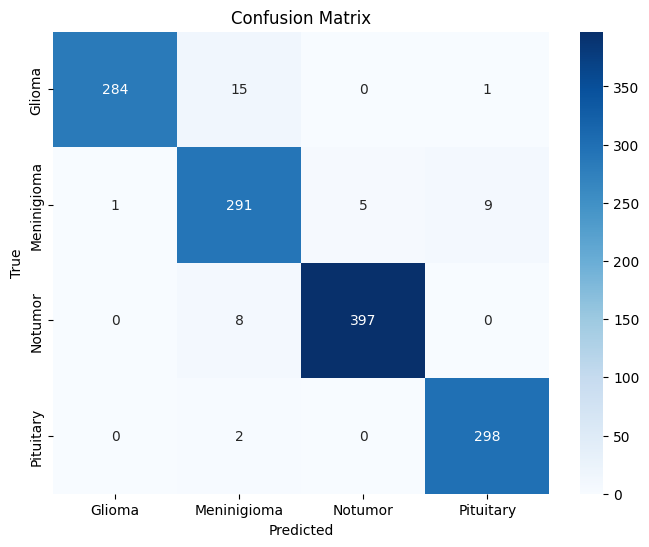

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [35]:
model_1.save("SSL_2_60-40.h5")

# SSL 2

In [36]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
from datetime import datetime
import shutil

# Define paths
MODEL_PATH = "SSL_2_60-40.h5"  # Update with actual model path
UNLABELED_DATASET_PATH = "BT100/low_confidence"  # Update with actual dataset path
OUTPUT_FOLDER = "BT100/Training"
LOW_CONF_FOLDER = "BT100/very_low_confidence"  # Folder for low-confidence images
CONFIDENCE_THRESHOLD = 0.90
IMG_SIZE = (168, 168)  # Use the same image size as during training

# Define class names
CLASS_NAMES = ["glioma", "meningioma", "notumor", "pituitary"]  # Update with actual class names

# Load trained model
model = tf.keras.models.load_model(MODEL_PATH)

# Ensure output folders exist
for class_name in CLASS_NAMES:
    os.makedirs(os.path.join(OUTPUT_FOLDER, class_name), exist_ok=True)
os.makedirs(LOW_CONF_FOLDER, exist_ok=True)  # Ensure low-confidence folder exists

# Get list of image files
image_files = [f for f in os.listdir(UNLABELED_DATASET_PATH) if f.endswith(('png', 'jpg', 'jpeg'))]

for img_file in tqdm(image_files):
    img_path = os.path.join(UNLABELED_DATASET_PATH, img_file)

    # Load and preprocess image
    img = load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')  # Load as grayscale
    img_array = img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Get predictions
    predictions = model.predict(img_array)
    class_id = np.argmax(predictions)
    confidence = np.max(predictions)

    # Debugging print statements
    print(f"{img_file} -> Class: {CLASS_NAMES[class_id]}, Confidence: {confidence:.2f}")

    # Save pseudo-labeled image if confidence is above threshold
    if confidence >= CONFIDENCE_THRESHOLD:
        class_folder = os.path.join(OUTPUT_FOLDER, CLASS_NAMES[class_id])

        # Ensure unique filenames to prevent overwriting
        unique_filename = f"{datetime.now().strftime('%Y%m%d_%H%M%S')}_{img_file}"
        output_path = os.path.join(class_folder, unique_filename)

        print(f"Moving {img_file} to {output_path}")
        shutil.move(img_path, output_path)  # Move instead of copy
    else:
        low_conf_path = os.path.join(LOW_CONF_FOLDER, img_file)
        shutil.move(img_path, low_conf_path)
        print(f"Moved low-confidence image {img_file} to {LOW_CONF_FOLDER}")

print("✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.")


  0%|          | 0/92 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


  1%|          | 1/92 [00:01<02:05,  1.38s/it]

Tr-me_0216.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0216.jpg to BT100/Training/meningioma/20250330_191817_Tr-me_0216.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


  2%|▏         | 2/92 [00:01<01:04,  1.40it/s]

Tr-me_0185.jpg -> Class: notumor, Confidence: 0.99
Moving Tr-me_0185.jpg to BT100/Training/notumor/20250330_191818_Tr-me_0185.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


  3%|▎         | 3/92 [00:01<00:42,  2.08it/s]

Tr-me_0243.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0243.jpg to BT100/Training/meningioma/20250330_191818_Tr-me_0243.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step


  4%|▍         | 4/92 [00:02<00:32,  2.69it/s]

Tr-gl_0359.jpg -> Class: glioma, Confidence: 0.94
Moving Tr-gl_0359.jpg to BT100/Training/glioma/20250330_191818_Tr-gl_0359.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


  5%|▌         | 5/92 [00:02<00:27,  3.16it/s]

Tr-gl_0188.jpg -> Class: glioma, Confidence: 0.84
Moved low-confidence image Tr-gl_0188.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


  7%|▋         | 6/92 [00:02<00:24,  3.50it/s]

Tr-me_1066.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1066.jpg to BT100/Training/meningioma/20250330_191819_Tr-me_1066.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


  8%|▊         | 7/92 [00:02<00:21,  3.97it/s]

Tr-pi_0865.jpg -> Class: pituitary, Confidence: 0.98
Moving Tr-pi_0865.jpg to BT100/Training/pituitary/20250330_191819_Tr-pi_0865.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


  9%|▊         | 8/92 [00:02<00:21,  4.00it/s]

Tr-gl_1002.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-gl_1002.jpg to BT100/Training/meningioma/20250330_191819_Tr-gl_1002.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 10%|▉         | 9/92 [00:03<00:18,  4.44it/s]

Tr-gl_0047.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0047.jpg to BT100/Training/glioma/20250330_191819_Tr-gl_0047.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 11%|█         | 10/92 [00:03<00:18,  4.41it/s]

Tr-gl_0947.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0947.jpg to BT100/Training/meningioma/20250330_191819_Tr-gl_0947.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


 12%|█▏        | 11/92 [00:03<00:17,  4.59it/s]

Tr-me_0226.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0226.jpg to BT100/Training/meningioma/20250330_191820_Tr-me_0226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 13%|█▎        | 12/92 [00:03<00:16,  4.77it/s]

Tr-gl_1274.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1274.jpg to BT100/Training/glioma/20250330_191820_Tr-gl_1274.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 14%|█▍        | 13/92 [00:03<00:15,  5.26it/s]

Tr-me_0195.jpg -> Class: notumor, Confidence: 0.77
Moved low-confidence image Tr-me_0195.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 15%|█▌        | 14/92 [00:03<00:13,  5.66it/s]

Tr-me_0340.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0340.jpg to BT100/Training/meningioma/20250330_191820_Tr-me_0340.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 16%|█▋        | 15/92 [00:04<00:12,  6.03it/s]

Tr-gl_0481.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0481.jpg to BT100/Training/glioma/20250330_191820_Tr-gl_0481.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 17%|█▋        | 16/92 [00:04<00:11,  6.63it/s]

Tr-meTr_0002.jpg -> Class: notumor, Confidence: 0.75
Moved low-confidence image Tr-meTr_0002.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|█▊        | 17/92 [00:04<00:11,  6.51it/s]

Tr-no_0265.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0265.jpg to BT100/Training/notumor/20250330_191820_Tr-no_0265.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 20%|█▉        | 18/92 [00:04<00:10,  6.76it/s]

Tr-gl_0524.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0524.jpg to BT100/Training/glioma/20250330_191821_Tr-gl_0524.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0230.jpg -> Class: glioma, Confidence: 0.72
Moved low-confidence image Tr-gl_0230.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 22%|██▏       | 20/92 [00:04<00:08,  8.21it/s]

Tr-no_0333.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-no_0333.jpg to BT100/Training/meningioma/20250330_191821_Tr-no_0333.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 23%|██▎       | 21/92 [00:04<00:08,  8.33it/s]

Tr-me_1121.jpg -> Class: meningioma, Confidence: 0.66
Moved low-confidence image Tr-me_1121.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▍       | 22/92 [00:04<00:08,  8.33it/s]

Tr-me_0271.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0271.jpg to BT100/Training/meningioma/20250330_191821_Tr-me_0271.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_0068.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-gl_0068.jpg to BT100/Training/pituitary/20250330_191821_Tr-gl_0068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 26%|██▌       | 24/92 [00:05<00:06, 10.01it/s]

Tr-gl_0326.jpg -> Class: meningioma, Confidence: 0.58
Moved low-confidence image Tr-gl_0326.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0184.jpg -> Class: meningioma, Confidence: 0.59
Moved low-confidence image Tr-gl_0184.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 28%|██▊       | 26/92 [00:05<00:05, 11.28it/s]

Tr-gl_1015.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_1015.jpg to BT100/Training/glioma/20250330_191821_Tr-gl_1015.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-me_0691.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0691.jpg to BT100/Training/meningioma/20250330_191821_Tr-me_0691.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 30%|███       | 28/92 [00:05<00:05, 11.83it/s]

Tr-gl_1026.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-gl_1026.jpg to BT100/Training/meningioma/20250330_191821_Tr-gl_1026.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0515.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-pi_0515.jpg to BT100/Training/meningioma/20250330_191822_Tr-pi_0515.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 33%|███▎      | 30/92 [00:05<00:04, 12.64it/s]

Tr-gl_1143.jpg -> Class: meningioma, Confidence: 0.98
Moving Tr-gl_1143.jpg to BT100/Training/meningioma/20250330_191822_Tr-gl_1143.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0062.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0062.jpg to BT100/Training/glioma/20250330_191822_Tr-gl_0062.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 35%|███▍      | 32/92 [00:05<00:04, 13.00it/s]

Tr-pi_0404.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0404.jpg to BT100/Training/pituitary/20250330_191822_Tr-pi_0404.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-no_0301.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0301.jpg to BT100/Training/notumor/20250330_191822_Tr-no_0301.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 37%|███▋      | 34/92 [00:05<00:04, 13.41it/s]

Tr-gl_1260.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-gl_1260.jpg to BT100/Training/notumor/20250330_191822_Tr-gl_1260.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Tr-gl_1161.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1161.jpg to BT100/Training/meningioma/20250330_191822_Tr-gl_1161.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 39%|███▉      | 36/92 [00:05<00:04, 12.51it/s]

Tr-gl_1145.jpg -> Class: meningioma, Confidence: 0.93
Moving Tr-gl_1145.jpg to BT100/Training/meningioma/20250330_191822_Tr-gl_1145.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-no_0209.jpg -> Class: meningioma, Confidence: 0.78
Moved low-confidence image Tr-no_0209.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 41%|████▏     | 38/92 [00:06<00:04, 12.97it/s]

Tr-me_0264.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0264.jpg to BT100/Training/meningioma/20250330_191822_Tr-me_0264.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1363.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1363.jpg to BT100/Training/pituitary/20250330_191822_Tr-pi_1363.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 40/92 [00:06<00:03, 13.12it/s]

Tr-no_0255.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-no_0255.jpg to BT100/Training/meningioma/20250330_191822_Tr-no_0255.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_1146.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1146.jpg to BT100/Training/glioma/20250330_191822_Tr-gl_1146.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 46%|████▌     | 42/92 [00:06<00:03, 13.28it/s]

Tr-gl_0975.jpg -> Class: glioma, Confidence: 0.99
Moving Tr-gl_0975.jpg to BT100/Training/glioma/20250330_191823_Tr-gl_0975.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1144.jpg -> Class: meningioma, Confidence: 0.94
Moving Tr-gl_1144.jpg to BT100/Training/meningioma/20250330_191823_Tr-gl_1144.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 48%|████▊     | 44/92 [00:06<00:03, 12.37it/s]

Tr-gl_0228.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0228.jpg to BT100/Training/glioma/20250330_191823_Tr-gl_0228.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0048.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0048.jpg to BT100/Training/glioma/20250330_191823_Tr-gl_0048.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 50%|█████     | 46/92 [00:06<00:03, 12.85it/s]

Tr-gl_0226.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0226.jpg to BT100/Training/glioma/20250330_191823_Tr-gl_0226.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0183.jpg -> Class: glioma, Confidence: 0.88
Moved low-confidence image Tr-gl_0183.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 48/92 [00:06<00:03, 12.17it/s]

Tr-no_0278.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0278.jpg to BT100/Training/notumor/20250330_191823_Tr-no_0278.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-me_0889.jpg -> Class: meningioma, Confidence: 0.51
Moved low-confidence image Tr-me_0889.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 54%|█████▍    | 50/92 [00:07<00:03, 10.99it/s]

Tr-pi_0036.jpg -> Class: meningioma, Confidence: 0.54
Moved low-confidence image Tr-pi_0036.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-pi_1039.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1039.jpg to BT100/Training/pituitary/20250330_191823_Tr-pi_1039.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 57%|█████▋    | 52/92 [00:07<00:03, 10.83it/s]

Tr-me_0087.jpg -> Class: meningioma, Confidence: 0.66
Moved low-confidence image Tr-me_0087.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0073.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0073.jpg to BT100/Training/meningioma/20250330_191824_Tr-me_0073.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 59%|█████▊    | 54/92 [00:07<00:03, 11.65it/s]

Tr-pi_0768.jpg -> Class: pituitary, Confidence: 0.99
Moving Tr-pi_0768.jpg to BT100/Training/pituitary/20250330_191824_Tr-pi_0768.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0225.jpg -> Class: glioma, Confidence: 0.97
Moving Tr-gl_0225.jpg to BT100/Training/glioma/20250330_191824_Tr-gl_0225.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 61%|██████    | 56/92 [00:07<00:02, 12.30it/s]

Tr-me_0656.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-me_0656.jpg to BT100/Training/glioma/20250330_191824_Tr-me_0656.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Tr-gl_1259.jpg -> Class: meningioma, Confidence: 0.61
Moved low-confidence image Tr-gl_1259.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 63%|██████▎   | 58/92 [00:07<00:02, 12.75it/s]

Tr-gl_0121.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0121.jpg to BT100/Training/glioma/20250330_191824_Tr-gl_0121.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_1141.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1141.jpg to BT100/Training/glioma/20250330_191824_Tr-gl_1141.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▌   | 60/92 [00:07<00:02, 12.21it/s]

Tr-gl_0945.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0945.jpg to BT100/Training/glioma/20250330_191824_Tr-gl_0945.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_0551.jpg -> Class: meningioma, Confidence: 0.87
Moved low-confidence image Tr-me_0551.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 67%|██████▋   | 62/92 [00:08<00:02, 11.83it/s]

Tr-pi_0322.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0322.jpg to BT100/Training/pituitary/20250330_191824_Tr-pi_0322.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1028.jpg -> Class: meningioma, Confidence: 0.82
Moved low-confidence image Tr-gl_1028.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 70%|██████▉   | 64/92 [00:08<00:02, 11.48it/s]

Tr-gl_1027.jpg -> Class: meningioma, Confidence: 0.62
Moved low-confidence image Tr-gl_1027.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-no_0358.jpg -> Class: notumor, Confidence: 0.62
Moved low-confidence image Tr-no_0358.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-no_0082.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-no_0082.jpg to BT100/Training/pituitary/20250330_191825_Tr-no_0082.jpg


 72%|███████▏  | 66/92 [00:08<00:02, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_1148.jpg -> Class: meningioma, Confidence: 0.90
Moving Tr-gl_1148.jpg to BT100/Training/meningioma/20250330_191825_Tr-gl_1148.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 74%|███████▍  | 68/92 [00:08<00:02, 11.71it/s]

Tr-gl_0022.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0022.jpg to BT100/Training/glioma/20250330_191825_Tr-gl_0022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0480.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0480.jpg to BT100/Training/glioma/20250330_191825_Tr-gl_0480.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 76%|███████▌  | 70/92 [00:08<00:01, 11.40it/s]

Tr-gl_0358.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_0358.jpg to BT100/Training/meningioma/20250330_191825_Tr-gl_0358.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1152.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-gl_1152.jpg to BT100/Training/meningioma/20250330_191825_Tr-gl_1152.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 78%|███████▊  | 72/92 [00:08<00:01, 11.95it/s]

Tr-me_0794.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0794.jpg to BT100/Training/meningioma/20250330_191825_Tr-me_0794.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Tr-me_1056.jpg -> Class: glioma, Confidence: 0.95
Moving Tr-me_1056.jpg to BT100/Training/glioma/20250330_191825_Tr-me_1056.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 80%|████████  | 74/92 [00:09<00:01, 10.90it/s]

Tr-gl_0419.jpg -> Class: pituitary, Confidence: 0.76
Moved low-confidence image Tr-gl_0419.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Tr-gl_0360.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0360.jpg to BT100/Training/glioma/20250330_191825_Tr-gl_0360.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 83%|████████▎ | 76/92 [00:09<00:01, 10.78it/s]

Tr-me_1061.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1061.jpg to BT100/Training/meningioma/20250330_191825_Tr-me_1061.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-gl_1275.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_1275.jpg to BT100/Training/glioma/20250330_191826_Tr-gl_1275.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 85%|████████▍ | 78/92 [00:09<00:01, 11.62it/s]

Tr-me_0012.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0012.jpg to BT100/Training/meningioma/20250330_191826_Tr-me_0012.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Tr-gl_0223.jpg -> Class: glioma, Confidence: 0.46
Moved low-confidence image Tr-gl_0223.jpg to BT100/very_low_confidence
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 87%|████████▋ | 80/92 [00:09<00:00, 12.04it/s]

Tr-me_0154.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_0154.jpg to BT100/Training/meningioma/20250330_191826_Tr-me_0154.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-pi_0875.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_0875.jpg to BT100/Training/pituitary/20250330_191826_Tr-pi_0875.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 89%|████████▉ | 82/92 [00:09<00:00, 12.66it/s]

Tr-no_0991.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0991.jpg to BT100/Training/notumor/20250330_191826_Tr-no_0991.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Tr-gl_0141.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0141.jpg to BT100/Training/glioma/20250330_191826_Tr-gl_0141.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Tr-gl_0185.jpg -> Class: meningioma, Confidence: 0.99
Moving Tr-gl_0185.jpg to BT100/Training/meningioma/20250330_191826_Tr-gl_0185.jpg


 91%|█████████▏| 84/92 [00:10<00:00, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Tr-me_1055.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1055.jpg to BT100/Training/meningioma/20250330_191826_Tr-me_1055.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 93%|█████████▎| 86/92 [00:10<00:00, 12.67it/s]

Tr-no_0462.jpg -> Class: notumor, Confidence: 1.00
Moving Tr-no_0462.jpg to BT100/Training/notumor/20250330_191826_Tr-no_0462.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-gl_0100.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0100.jpg to BT100/Training/glioma/20250330_191826_Tr-gl_0100.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 88/92 [00:10<00:00, 11.87it/s]

Tr-gl_0024.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0024.jpg to BT100/Training/glioma/20250330_191826_Tr-gl_0024.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-pi_1068.jpg -> Class: pituitary, Confidence: 1.00
Moving Tr-pi_1068.jpg to BT100/Training/pituitary/20250330_191827_Tr-pi_1068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 90/92 [00:10<00:00, 11.47it/s]

Tr-gl_0477.jpg -> Class: glioma, Confidence: 1.00
Moving Tr-gl_0477.jpg to BT100/Training/glioma/20250330_191827_Tr-gl_0477.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Tr-me_1068.jpg -> Class: meningioma, Confidence: 1.00
Moving Tr-me_1068.jpg to BT100/Training/meningioma/20250330_191827_Tr-me_1068.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


100%|██████████| 92/92 [00:10<00:00,  8.60it/s]

Tr-pi_1050.jpg -> Class: notumor, Confidence: 0.95
Moving Tr-pi_1050.jpg to BT100/Training/notumor/20250330_191827_Tr-pi_1050.jpg
✅ Pseudo-labeling completed. Check the output folder for labeled images and low-confidence images.


In [38]:
def count_files(folder_path):
    if not os.path.exists(folder_path):
        print("Folder does not exist.")
        return 0

    file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of files in '{folder_path}': {file_count}")
    return file_count

# Define the unlabelled folder path
unlabelled_folder = "BT100/very_low_confidence"  # Update with the actual path
count_files(unlabelled_folder)

Number of files in 'BT100/very_low_confidence': 19


19

In [39]:
import os

# Define the path to the training folder
TRAINING_FOLDER = "BT100/Training"  # Update with actual path if needed

# Count total files
total_files = sum(len(files) for _, _, files in os.walk(TRAINING_FOLDER))

print(f"Total number of files in the Training folder: {total_files}")

Total number of files in the Training folder: 5693


In [40]:
import os
import tensorflow as tf


train_paths = 'BT100/Training'
test_paths = 'BT100/Testing'


train_image_paths, train_index = get_data_labels(train_paths)

test_image_paths, test_index = get_data_labels(test_paths)


batch_size = 32
image_dim = (168, 168)
train_ds = get_dataset(train_image_paths, train_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_image_paths, test_index, image_dim, n_channels=1, num_classes=4, batch_size=batch_size)

In [41]:
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

In [42]:

# Printing traing and testing sample sizes
print('Training')
# print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_index)}')
print('\nTesting')
# print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_index)}')

Training
Number of Labels: 5693

Testing
Number of Labels: 1311


In [43]:
# Dta augmentation sequential model
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.02, fill_mode='constant'),
    RandomContrast(0.1),
    RandomZoom(height_factor=0.01, width_factor=0.05),
    RandomTranslation(height_factor=0.0015, width_factor=0.0015, fill_mode='constant'),
])

# Training augmentation and nornalization
def preprocess_train(image, label):
    # Apply data augmentation and Normalize
    image = data_augmentation(image) / 255.0
    return image, label




# For test dataset only appying normalization
def preprocess_test(image, label):
    return image / 255.0, label




# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)


In [44]:
num_classes = len(class_mappings.keys())
image_shape = (image_dim[0], image_dim[1], 1)

# Training epochs and batch size
epochs = 50
print(f'Number of Classes: {num_classes}')
print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

def encode_labels(image, label):
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)


Number of Classes: 4
Image shape: (168, 168, 1)
Epochs: 50
Batch size: 32


In [45]:
model_2 = Sequential([
    # Input tensor shape
    Input(shape=image_shape),

    # Convolutional layer 1
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),

    # Dense layers
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model_2.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 164, 164, 64)        │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 50, 50, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 13, 13, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 3, 3, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 1, 1, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 565,700 (2.16 MB)

 Trainable params: 565,700 (2.16 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.85, beta_2=0.9925)
model_2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

In [51]:
class ReduceLROnMultipleAccuracies(tf.keras.callbacks.Callback):
    def __init__(self, thresholds, factor, monitor='val_accuracy', verbose=1):
        super(ReduceLROnMultipleAccuracies, self).__init__()
        self.thresholds = thresholds  # List of accuracy thresholds
        self.factor = factor  # Factor to reduce the learning rate
        self.monitor = monitor
        self.verbose = verbose
        self.thresholds_reached = [False] * len(thresholds)  # Track each threshold

    def on_epoch_end(self, epoch, logs=None):
        current_accuracy = logs.get(self.monitor)
        for i, threshold in enumerate(self.thresholds):
            if current_accuracy >= threshold and not self.thresholds_reached[i]:
                optimizer = self.model.optimizer
                old_lr = optimizer.learning_rate.numpy()
                new_lr = old_lr * self.factor
                optimizer.learning_rate.assign(new_lr)
                self.thresholds_reached[i] = True  # Mark this threshold as reached
                if self.verbose > 0:
                    print(f"\nEpoch {epoch+1}: {self.monitor} reached {threshold}. Reducing learning rate from {old_lr} to {new_lr}.")

# Try a custom callback
thresholds = [0.96, 0.99, 0.9935]
lr_callback = ReduceLROnMultipleAccuracies(thresholds=thresholds, factor=0.75, monitor='val_accuracy', verbose=False)


In [52]:
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_lr=1e-4, patience=4, verbose=False)
model_mc = ModelCheckpoint('model_2.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=False)

# Training the model
history_2 = model_2.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc],
    verbose=True
)

Epoch 1/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 25s 119ms/step - accuracy: 0.5014 - loss: 1.0651 - val_accuracy: 0.7307 - val_loss: 0.7253 - learning_rate: 0.0010
Epoch 2/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 18s 100ms/step - accuracy: 0.8175 - loss: 0.4899 - val_accuracy: 0.8108 - val_loss: 0.5302 - learning_rate: 0.0010
Epoch 3/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 18s 102ms/step - accuracy: 0.8672 - loss: 0.3384 - val_accuracy: 0.8726 - val_loss: 0.3518 - learning_rate: 0.0010
Epoch 4/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.9028 - loss: 0.2489 - val_accuracy: 0.8970 - val_loss: 0.2702 - learning_rate: 0.0010
Epoch 5/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 21s 103ms/step - accuracy: 0.9282 - loss: 0.1870 - val_accuracy: 0.8978 - val_loss: 0.2945 - learning_rate: 0.0010
Epoch 6/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.9396 - loss: 0.1777 - val_accuracy: 0.9268 - val_loss: 0.2602 - learning_rate: 0.0010
Epoch 7/50
178/178 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.95

In [53]:
test_loss, test_acc = model_2.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc*100:0.4f}%")

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9723 - loss: 0.4841
Test accuracy: 97.1777%


In [54]:
from sklearn.metrics import classification_report

y_pred = model_2.predict(test_ds_preprocessed)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true labels as class indices instead of one-hot encoded vectors
true_labels = np.concatenate([np.argmax(y.numpy(), axis=-1) for x, y in test_ds_preprocessed], axis=0)
print(classification_report(true_labels, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       300
           1       0.94      0.95      0.94       306
           2       0.99      0.98      0.98       405
           3       0.97      0.99      0.98       300

    accuracy                           0.97      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.97      0.97      0.97      1311



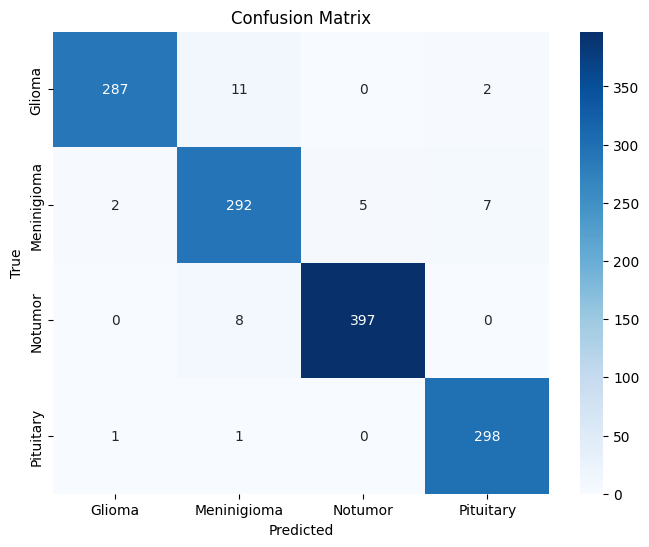

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
